<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_1C2024_GRUPO02_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [242]:
import pandas as pd
import numpy as np
import sklearn as sk

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Lectura de archivo

### Desde google drive

In [243]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/properati_argentina_2021.csv'
barrios_file = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/barrios.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [244]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# file_path = './dataset/properati_argentina_2021.csv'
# barrios_file = './dataset/barrios.csv'
# df = pd.read_csv(file_path)

In [245]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




#### Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [246]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [247]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [248]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [249]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [250]:
# DataSet filtrado
ds_propiedades_filtradas.head()

id  start_date    end_date  created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg==  2021-09-09  2021-09-26  2021-09-09        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw==  2021-09-09  2022-03-09  2021-09-09 -34.631621   

     longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
25        NaN  Capital Federal      NaN      NaN      NaN       NaN     Venta   
42 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
43 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
49 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   
51 -58.416825  Capital Federal    Boedo      NaN      NaN       NaN     Venta   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   

    property_surface_covered  property_price property_currency  \
25                     133.0        210000.0               USD   
42                      55.0         82900.0               USD   
43                      70.0         99000.0               USD   
49                     104.0        146000.0               USD   
51                      73.0        250000.0               USD   

                                 property_title  
25  VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42       VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43   Departamento - 4 Ambientes - Catalinas Sur  
49          Venta departamento 4 ambientes Once  
51                                   PH - Boedo

#### Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


In [251]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
prop_train, prop_test = train_test_split(ds_propiedades_filtradas, train_size=0.8)
print("Propiedades para entrenar:", len(prop_train))
print("Propiedades para testear:", len(prop_test))

Propiedades para entrenar: 75399
Propiedades para testear: 18850


## Exploración Inicial

### Medidas de resumen de las variables cuantitativas del Dataset

In [252]:
# Creo resumen con describe
prop_train_resumen = prop_train.describe()
# Agrego moda a la tabla resumen
prop_train_resumen.loc['mode'] = prop_train.mode().iloc[0]
prop_train_resumen


latitud      longitud  place_l6  property_rooms  \
count  72468.000000  72468.000000       0.0    74555.000000   
mean     -34.591873    -58.449578       NaN        2.823070   
std        0.183822      0.290220       NaN        1.430561   
min      -53.788624    -71.471192       NaN        1.000000   
25%      -34.615926    -58.466487       NaN        2.000000   
50%      -34.595769    -58.438983       NaN        3.000000   
75%      -34.577438    -58.408862       NaN        4.000000   
max      -24.219827    -54.133330       NaN       40.000000   
mode     -34.541250    -58.472966       NaN        3.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       66589.000000            71524.000000              72717.000000   
mean            2.015904              110.498140                 85.734753   
std             1.138342             1062.333248                693.692071   
min            -1.000000               10.000000                  1.000000   
25%             1.000000               45.000000                 40.000000   
50%             2.000000               65.000000                 57.000000   
75%             3.000000              105.000000                 88.000000   
max            70.000000           137000.000000             123000.000000   
mode            1.000000               50.000000                 40.000000   

       property_price  
count    7.539900e+04  
mean     2.261020e+05  
std      3.216353e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.430000e+05  
75%      2.350000e+05  
max      2.140000e+07  
mode     1.100000e+05

En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

### Cantidad de valores posibles para cada variable cualitativo

In [253]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
prop_train[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             604
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

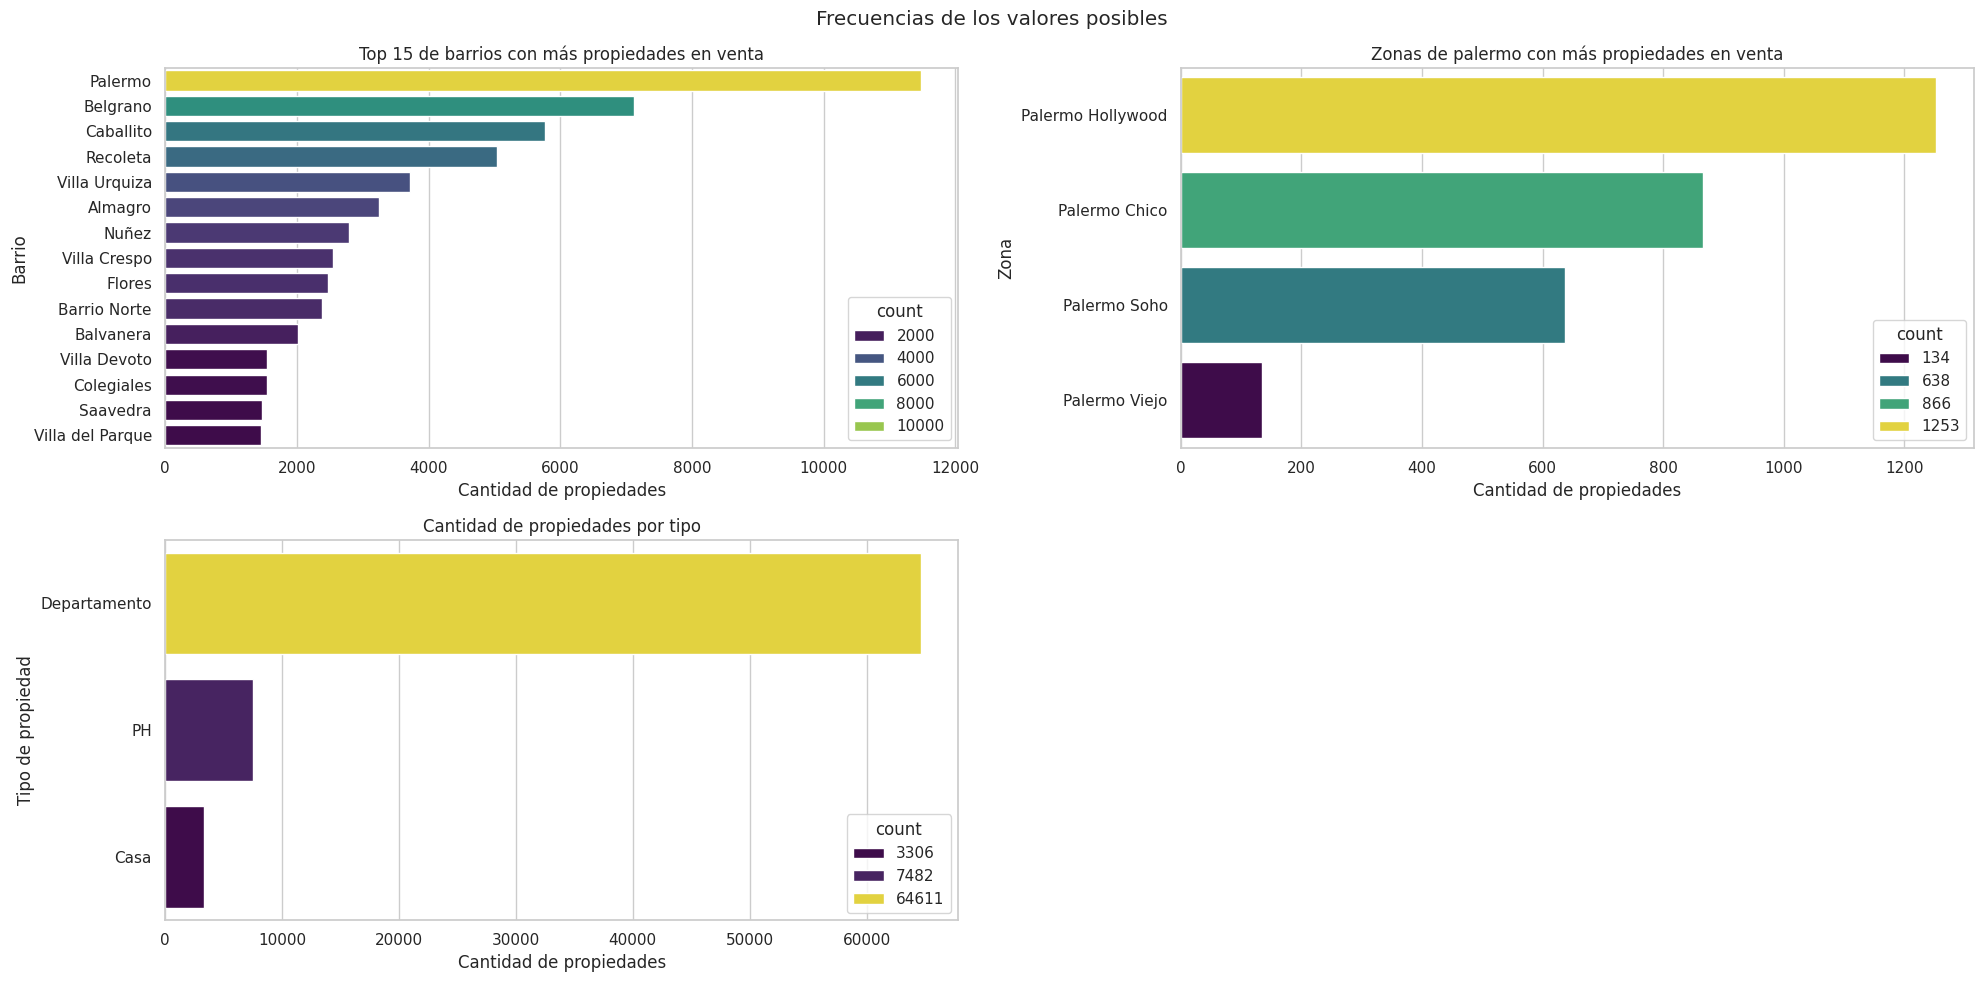

In [254]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = prop_train["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = prop_train["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = prop_train["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

plt.tight_layout()
plt.show()

*Anotacion: todos los place_l4 que no son NaN son zonas de palermo.*

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l2**: siempre son capital federal debido al primer filtro
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan/se crean, de lo contrario no es relevante.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l2
* place_l5/l6 (se abordara en la seccion de datos faltantes)
* operation
* property_currency
* property title

In [255]:
# Nuevo filtro para eliminar dichas columnas
columnas_a_eliminar = ['place_l2', 'operation', 'property_currency', 'property_title']
prop_train.drop(columns = columnas_a_eliminar,inplace=True)
prop_test.drop(columns = columnas_a_eliminar,inplace=True)

### Analisis grafico de distribucion de variables mas relevantes

* distribucion de precios
* distribucion de publicaciones por mes
* distribucion de habitaciones y dormitorios

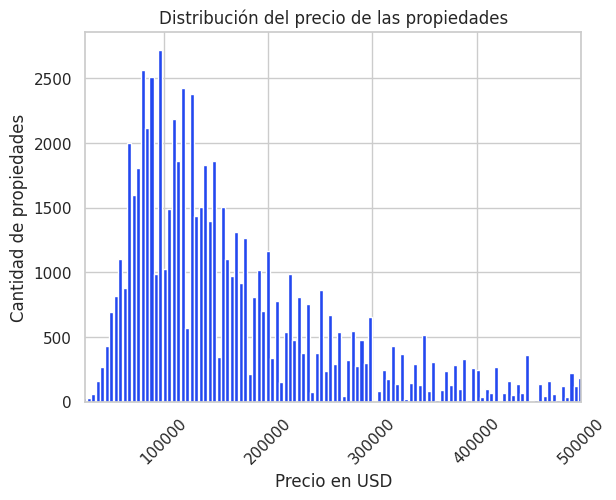

In [256]:
# plot de distribucion de property_price

plt.hist(data=prop_train,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)

plt.show()

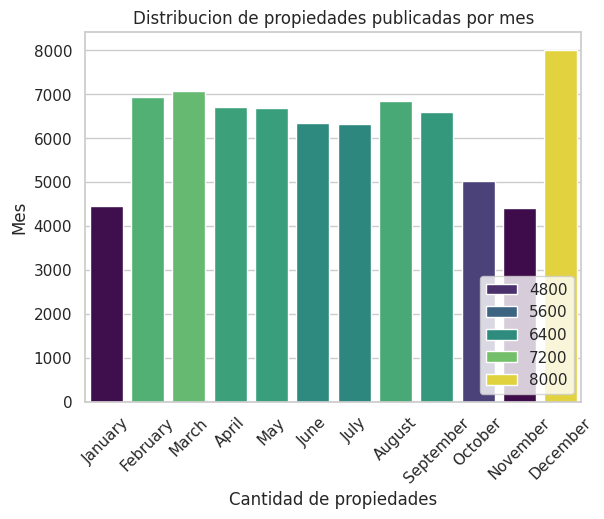

In [257]:
# bar plot distribucion de ventas por mes

prop_train["created_on"] = pd.to_datetime(prop_train["created_on"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = prop_train["created_on"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='lower right')
plt.title('Distribucion de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.show()

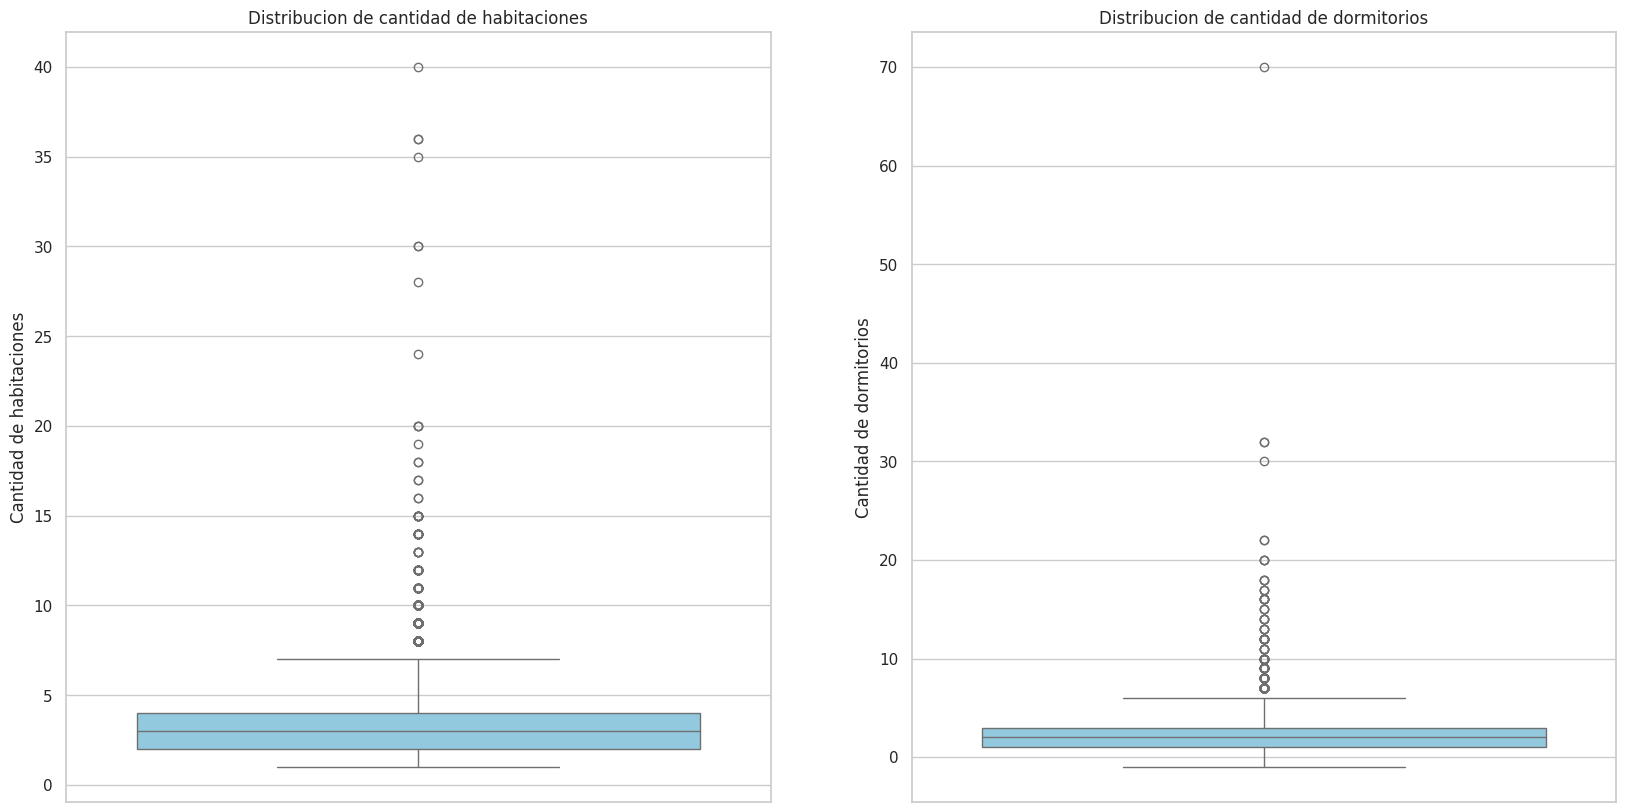

In [258]:
# Boxplot de property_rooms y property_bedrooms
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1 posicion
sns.boxplot(data=prop_train, y='property_rooms', color='skyblue')
plt.title('Distribucion de cantidad de habitaciones')
plt.ylabel('Cantidad de habitaciones')

plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2 posicion
sns.boxplot(data=prop_train, y='property_bedrooms', color='skyblue')
plt.title('Distribucion de cantidad de dormitorios')
plt.ylabel('Cantidad de dormitorios')

plt.show()

### Analisis de correlaciones existentes entre variables

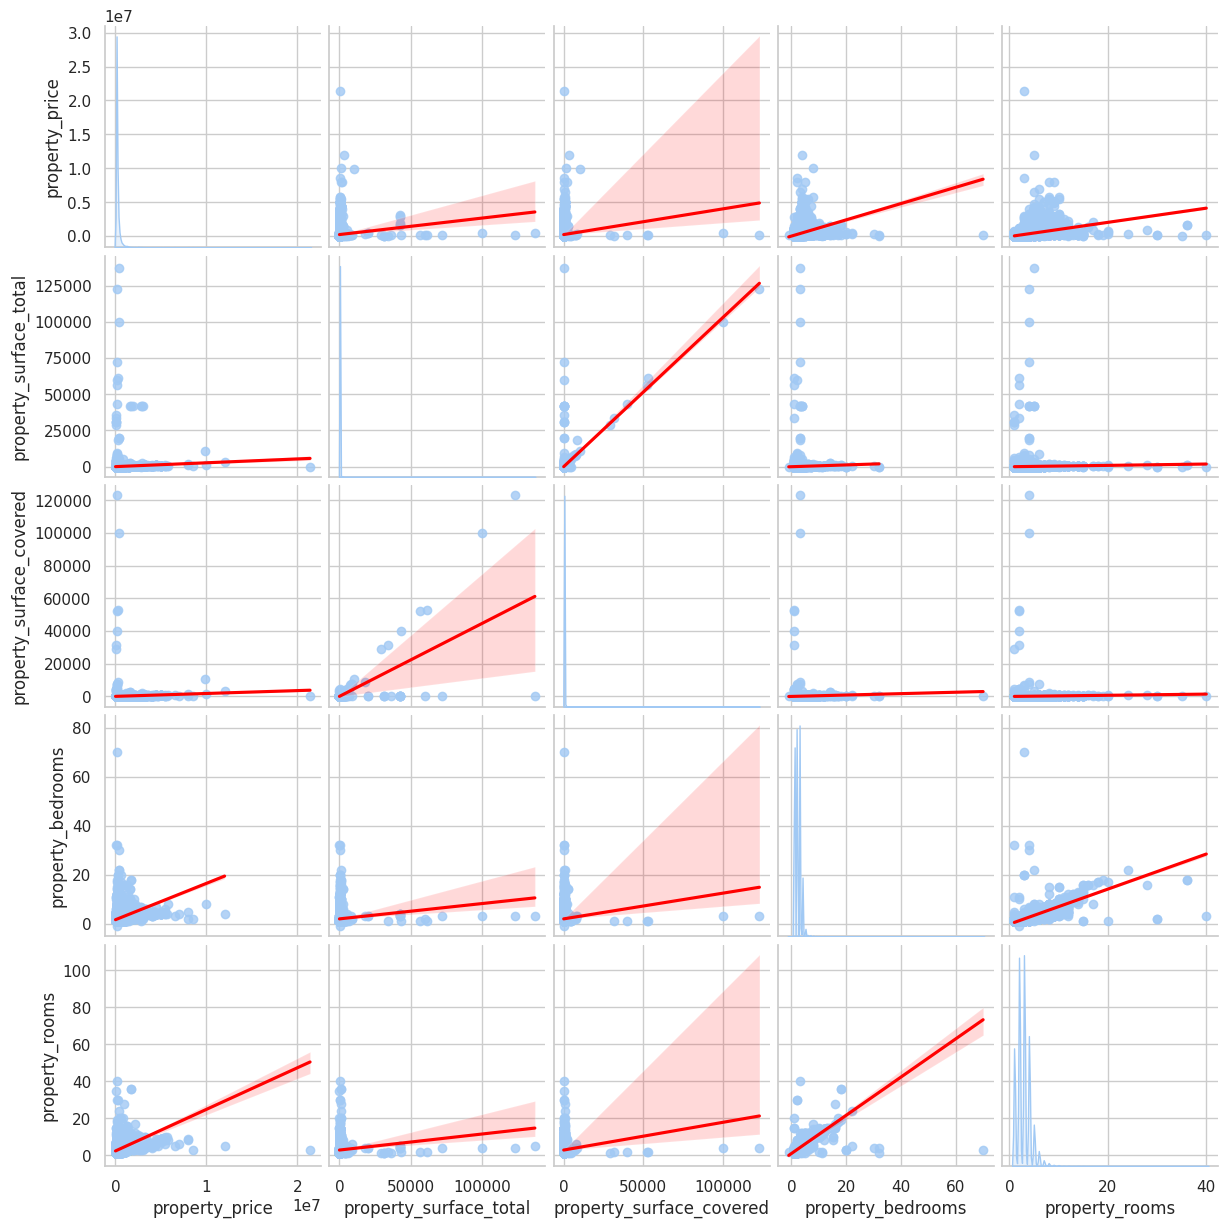

In [259]:
# pairplot con price, surface_total, surface_covered, bedrooms, rooms
sns.pairplot(prop_train[['property_price', 'property_surface_total', 'property_surface_covered', 'property_bedrooms', 'property_rooms']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

Observando este grafico de relaciones se pueden ver que algunas de estas variables tienen claramente una relacion y otras no tanto.

* La relacion entre la **superficie total** y **superficie cubierta** es lineal y acendente, es decir da la impresion que una dependiera de la otra, y si se piensa logicamente esto tiene sentido (si hay mas espacio se cubre mas espacio) aunque no siempre es necesariamente el caso (puede haber una casa pequeña en un terreno grande)
* La relacion entre el **precio** y la cantidad de **habitaciones** y **dormitorios**, en esta se puede notar que a mas habitaciones y/o dormitorios mas aumenta el maximo precio pero no deja de haber precios mas bajos, sin embargo, pasada una cierta cantidad (aproximadamente ~15) el precio deja de aumentar y mas bien se queda constante (entre los valores hasta ~250,000 USD)
* La relacion entre **habitaciones** y **dormitorios** tambien es lineal y acendente, lo cual puede deberse a que cuando una casa tiene muchas habitaciones esta probablemente tenga tambien muchos dormitorios.

*Extra: hay ciertos valores outliers que pueden afectar a la correlacion entre variables por ejemplo una propiedad con mas de 60 habitaciones, estos seran analizados en la seccion de valores atipicos*

Para hacer un analisis mas profundo de estos datos se analiza la *covarianza* y *correlacion* entre las variables usadas en la figura anterior:

In [260]:
# covarianza y correlacion entre property_surface_total y property_surface_covered
covariance = prop_train['property_surface_total'].cov(prop_train['property_surface_covered'])
correlation = prop_train['property_surface_total'].corr(prop_train['property_surface_covered'])
print(f'Surface Total vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_rooms
covariance = prop_train['property_price'].cov(prop_train['property_rooms'])
correlation = prop_train['property_price'].corr(prop_train['property_rooms'])
print(f'Price vs Rooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_bedrooms
covariance = prop_train['property_price'].cov(prop_train['property_bedrooms'])
correlation = prop_train['property_price'].corr(prop_train['property_bedrooms'])
print(f'Price vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_total
covariance = prop_train['property_price'].cov(prop_train['property_surface_total'])
correlation = prop_train['property_price'].corr(prop_train['property_surface_total'])
print(f'Price vs Surface Total\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_covered
covariance = prop_train['property_price'].cov(prop_train['property_surface_covered'])
correlation = prop_train['property_price'].corr(prop_train['property_surface_covered'])
print(f'Price vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre property_rooms y property_bedrooms
covariance = prop_train['property_rooms'].cov(prop_train['property_bedrooms'])
correlation = prop_train['property_rooms'].corr(prop_train['property_bedrooms'])
print(f'Rooms vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

Surface Total vs Surface Covered
Covariance: 522879.00 & Correlation: 0.68

Price vs Rooms
Covariance: 214516.96 & Correlation: 0.49

Price vs Bedrooms
Covariance: 155363.65 & Correlation: 0.42

Price vs Surface Total
Covariance: 27466616.05 & Correlation: 0.08

Price vs Surface Covered
Covariance: 18240995.69 & Correlation: 0.08

Rooms vs Bedrooms
Covariance: 1.30 & Correlation: 0.86



Esto nos dice que en efecto lo previamente observado era el caso. Tambien ahora gracias a este analisis se ve que las relaciones mas debiles son las dadas entre el precio y las superficies totales/cubiertas.

## Visualización de los datos

In [261]:
# Crear una copia del DataFrame original prop_train
visu_prop_train = prop_train.copy()

# Aplicar el filtro por la columna 'property_rooms' < 6 en la copia
visu_prop_train = visu_prop_train[visu_prop_train['property_rooms'] < 6]

# Filtrar propiedades con precios entre 20,000 y 500,000
visu_prop_train = visu_prop_train[(visu_prop_train['property_price'] > 20000) &
                             (visu_prop_train['property_price'] < 500000)]

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_prop_train.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

df_visu

#Modificamos un rango para que se vea mejor la visualizacion

property_rooms                  1.0            2.0            3.0  \
place_l3                                                            
Abasto                 68553.571429   93903.316667  125571.717391   
Agronomía              71650.827586  105208.468085  172836.538462   
Almagro                76249.672609   96917.323194  140518.688129   
Balvanera              66523.257790   77687.677909  118119.229373   
Barracas               88908.885714  108580.207469  155401.854103   
Barrio Norte           96229.727763  115514.220679  194635.724080   
Belgrano              104076.491677  145578.287961  214936.727848   
Boca                   60647.595238   69583.000000   86772.764045   
Boedo                  68582.077519   91627.415033  135912.006024   
Caballito              85194.965368  110109.291110  164696.898004   
Catalinas              50500.000000            NaN  128000.000000   
Centro / Microcentro   60108.333333   82050.000000  122000.000000   
Chacarita              82746.795276  108842.478723  176465.715232   
Coghlan                86112.065868  126092.440816  194388.069307   
Colegiales             88985.227451  129916.967890  191957.292994   
Congreso               65642.238095   81587.543307  117066.057377   
Constitución           58803.356436   68919.122642   94203.123596   
Flores                 70006.873469   90579.993579  133570.778351   
Floresta               66180.819672   86440.432727  130354.716783   
Las Cañitas           110000.000000  265000.000000            NaN   
Liniers                64315.909091   87534.993789  136313.348148   
Mataderos              64272.638298   91904.024194  134659.127551   
Monserrat              76775.865942   85585.013953  119376.648889   
Monte Castro           78867.880000   96586.930435  148966.129032   
Nuñez                 101147.152968  142055.444565  208833.368039   
Once                   51330.000000   78652.000000  120044.444444   
Palermo               104517.743430  149851.809137  237946.079630   
Parque Avellaneda      73700.000000   81720.000000  111086.734694   
Parque Centenario      77711.111111  101899.636364  140738.888889   
Parque Chacabuco       78238.330357   94112.891509  140932.534296   
Parque Chas            76906.628205  108573.670732  181314.691176   
Parque Patricios       65740.527027   86940.259259  108973.389831   
Paternal               76952.698795   92038.536913  131014.608696   
Pompeya                45200.000000   59480.612903   95520.689655   
Puerto Madero         254791.311688  330803.533762  400400.621359   
Recoleta               97347.670315  126542.571298  227485.805627   
Retiro                 95086.427778  101329.770213  180734.285714   
Saavedra               92906.236364  117865.579909  188087.052356   
San Cristobal          62802.263598   77756.098940  113687.933993   
San Nicolás            60499.996622   77878.376947  118624.045000   
San Telmo              80761.680000  105134.642202  138187.631944   
Tribunales             62312.421053   86700.000000  115727.952381   
Velez Sarsfield        67717.391304   90657.222222  144416.981132   
Versalles              76073.913043  105833.508772  157066.666667   
Villa Crespo           82312.562863  106395.317197  152974.494444   
Villa Devoto           91303.078261  114179.378446  177886.825188   
Villa General Mitre    72411.307692   88064.333333  134552.173913   
Villa Lugano           63853.750000   85641.428571   89275.554054   
Villa Luro             72341.891892   93838.787234  138402.231214   
Villa Ortuzar          77558.212389   99643.028409  180396.456140   
Villa Pueyrredón       78788.398230  109589.297030  162497.010526   
Villa Real             81200.000000  107245.000000  143332.432432   
Villa Riachuelo                 NaN   86250.000000   81633.333333   
Villa Santa Rita       78250.766667   95738.235294  144300.598214   
Villa Soldati          53000.000000   67000.000000   91892.857143   
Villa Urquiza          90951.687898  123599.796828  190064.352627  

Text(70.93749999999999, 0.5, 'Zonas de Capital Federal')

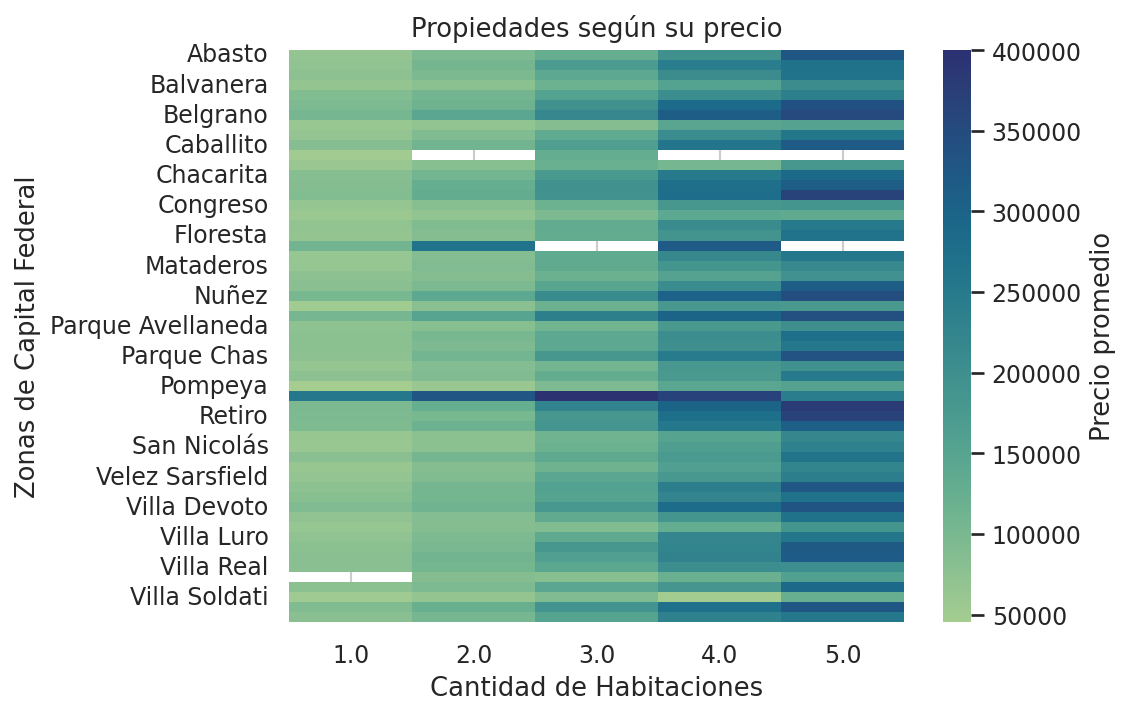

In [262]:
# Nueva figura con un dpi de 155 para mejorar la calidad de la visualización
plt.figure(dpi=155)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, square=False, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Establecer etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")

# Heatmap que muestra el precio promedio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicación

La visualización presentada es un mapa de calor (heatmap) que muestra el precio promedio de las propiedades en función de la cantidad de habitaciones y su ubicación en diferentes zonas de la Ciudad Autónoma de Buenos Aires (CABA). Al observar el heatmap, es posible identificar patrones en los precios según la ubicación y el tamaño de la propiedad. Por ejemplo, puede haber áreas donde las propiedades con más habitaciones tienden a tener precios más altos, mientras que en otras zonas los precios son más uniformes independientemente del tamaño de la propiedad.La visualización proporciona una manera efectiva de entender cómo se relacionan el precio promedio de las propiedades, la cantidad de habitaciones y la ubicación en diferentes áreas de la Ciudad Autónoma de Buenos Aires. Ayuda a los interesados a tomar decisiones informadas sobre la compra o inversión en propiedades en la ciudad.

<ipython-input-263-ee8e753002fe>:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



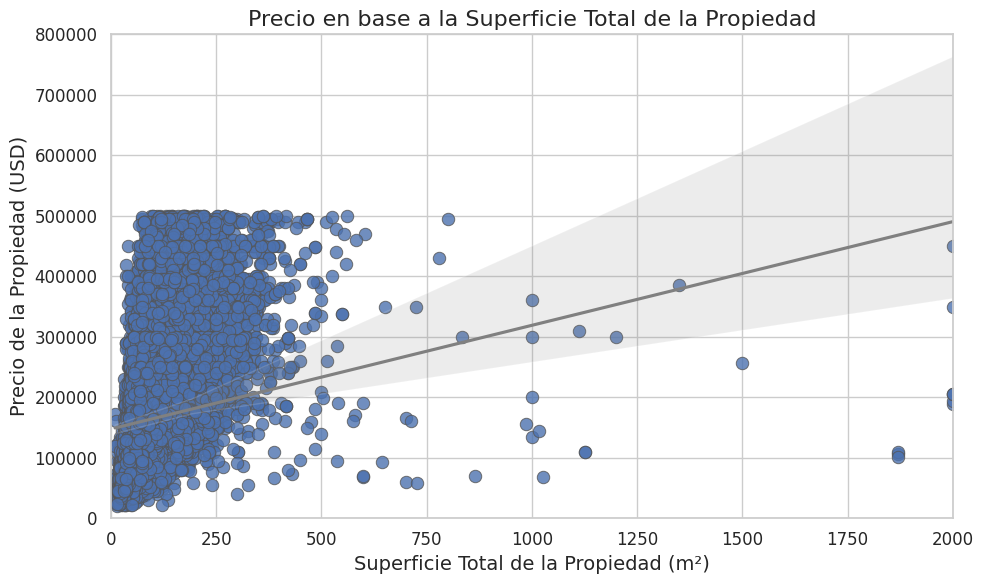

In [263]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el scatter plot utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
                x='property_surface_total', y='property_price', palette='pastel', s=80, alpha=0.8)

# Agregar una línea de regresión
sns.regplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
            x='property_surface_total', y='property_price', scatter=False, color='gray')

# Ajustar título y etiquetas
plt.title('Precio en base a la Superficie Total de la Propiedad', fontsize=16)
plt.xlabel('Superficie Total de la Propiedad (m²)', fontsize=14)
plt.ylabel('Precio de la Propiedad (USD)', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar el rango de los ejes
plt.xlim(0, 2000)  # Establecer el rango x hasta 20,000
plt.ylim(0, 800000)
# Añadir sombreado alrededor de las burbujas
plt.gca().collections[0].set_edgecolor("#555555")

plt.tight_layout()
plt.show()

Esta visualización muestra un diagrama de dispersión (scatter plot) que relaciona el precio de la propiedad con su superficie total, con el agregado de una línea de regresión para visualizar la tendencia general de los datos.La línea de regresión trazada en el gráfico muestra la tendencia general de los datos. Permite ver si hay una relación lineal entre el precio y la superficie total de la propiedad. En este caso, la pendiente de la línea de regresión indica la tasa de cambio en el precio para cada unidad adicional de superficie.Cada punto en el diagrama de dispersión representa una propiedad individual, y su posición relativa en el gráfico indica su precio y superficie total. Esto facilita la identificación de propiedades que pueden estar por encima o por debajo de la tendencia general.

In [264]:
# Calcular el precio promedio por barrio
precio_promedio_por_barrio = visu_prop_train.groupby('place_l3')['property_price'].mean().reset_index()

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='place_l3',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio promedio por barrio',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio promedio'})
fig.show()

Esta visualización muestra un gráfico de burbujas agrupadas que representa el precio promedio de las propiedades en cada barrio.El gráfico de burbujas agrupadas proporciona una representación visual del precio promedio de las propiedades en cada barrio de interés. Cada burbuja representa un barrio, y el tamaño de la burbuja indica el precio promedio de las propiedades en ese barrio. Los colores de las burbujas pueden indicar diferentes barrios para facilitar la identificación visual, las burbujas más grandes representan barrios con precios promedio más altos, mientras que las burbujas más pequeñas representan barrios con precios promedio más bajos.El gráfico de burbujas agrupadas es interactivo, lo que permite a los usuarios explorar los datos con mayor detalle al pasar el cursor sobre las burbujas para ver información adicional, como el nombre del barrio y el precio promedio.

In [265]:
# Filtramos los Nan de latitud ya que es impresindible contar con este dato para asignarlo al mapa
visu_prop_train = visu_prop_train.dropna(subset=['latitud'])

def generar_mapa_con_registros_por_barrio(df):
    """
    Función para generar un mapa con los registros por barrio.

    Parámetros:
    - visu_prop_train: DataFrame que contiene los datos de las propiedades filtradas.

    Devuelve:
    - mapa: Objeto del mapa de Folium.
    """
    # Coordenadas del centro de la Ciudad Autónoma de Buenos Aires
    latitud_caba = -34.6037
    longitud_caba = -58.3816

    # Crear el mapa centrado en CABA
    mapa = folium.Map(location=[latitud_caba, longitud_caba], zoom_start=12)

    # Agregar un grupo de marcadores
    marker_cluster = MarkerCluster().add_to(mapa)

    # Contar la cantidad de registros por barrio
    registros_por_barrio = visu_prop_train['place_l3'].value_counts()

    # Agregar marcadores en el mapa para cada barrio
    for barrio, cantidad in registros_por_barrio.items():
        latitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['latitud'].iloc[0]
        longitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['longitud'].iloc[0]

        folium.Marker(location=[latitud, longitud],
                      tooltip=f"{barrio}: {cantidad} Propiedad en Venta").add_to(marker_cluster)

    return mapa

# Generar el mapa con los registros por barrio
mapa = generar_mapa_con_registros_por_barrio(visu_prop_train)

# Mostrar el mapa
mapa

La visualización proporciona un mapa interactivo que muestra la ubicación de las propiedades en venta en la Ciudad Autónoma de Buenos Aires (CABA), agrupadas por barrio.Cada marcador en el mapa representa una propiedad, y su ubicación específica está determinada por las coordenadas de latitud y longitud proporcionadas en los datos.Los grupos de marcadores en el mapa indican la concentración de propiedades en cada barrio, lo que puede proporcionar información sobre la popularidad y la demanda de viviendas en diferentes áreas de CABA.

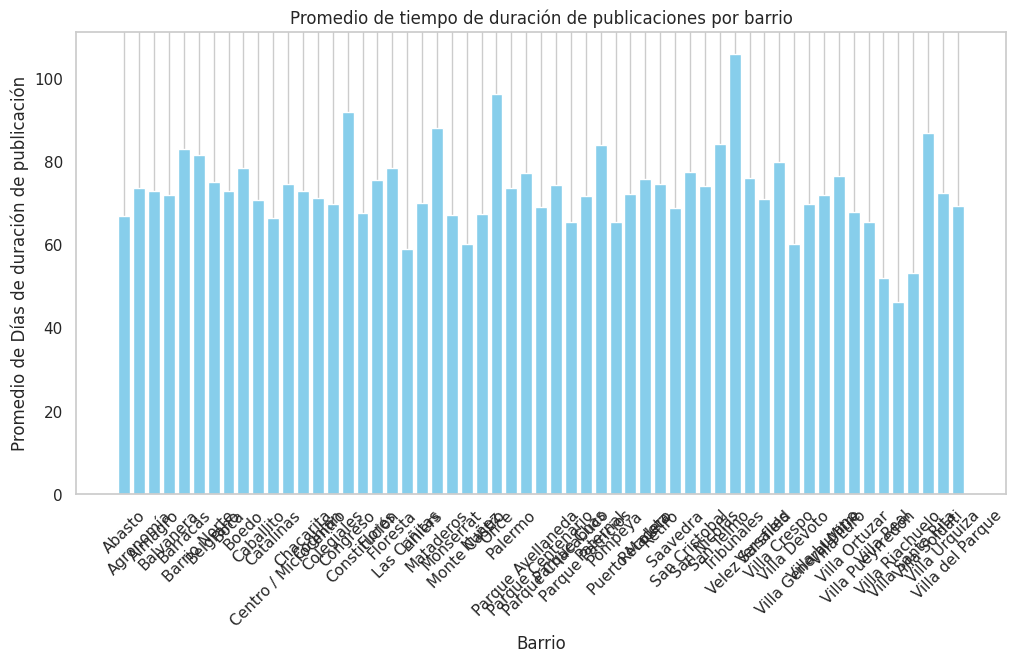

In [266]:
# Convertir las fechas a tipo datetime si no están en ese formato
visu_prop_train['start_date'] = pd.to_datetime(visu_prop_train['start_date'], errors='coerce')
visu_prop_train['end_date'] = pd.to_datetime(visu_prop_train['end_date'], errors='coerce')

# Calcular la duración de cada publicación
visu_prop_train['duracion_publicacion'] = (visu_prop_train['end_date'] - visu_prop_train['start_date']).dt.days

# Agrupar por barrio y calcular el promedio de duración de las publicaciones
promedio_duracion_por_barrio = visu_prop_train.groupby('place_l3')['duracion_publicacion'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(promedio_duracion_por_barrio['place_l3'], promedio_duracion_por_barrio['duracion_publicacion'], color='skyblue')
plt.title('Promedio de tiempo de duración de publicaciones por barrio')
plt.xlabel('Barrio')
plt.ylabel('Promedio de Días de duración de publicación')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.xticks(rotation=45)

plt.show()

Esta visualización presenta un gráfico de barras que muestra el promedio de tiempo de duración de las publicaciones por barrio en la Ciudad Autónoma de Buenos Aires (CABA). Cada barra en el gráfico representa un barrio específico, y su altura indica el promedio de días que las publicaciones permanecen activas en ese barrio.La visualización permite comparar fácilmente la duración promedio de las publicaciones entre diferentes barrios de la ciudad. Las barras más altas indican que las publicaciones en ese barrio tienden a permanecer activas por más tiempo, mientras que las barras más cortas indican una duración promedio más corta de las publicaciones.Los barrios con barras más altas pueden indicar áreas de la ciudad donde la demanda de propiedades es más alta o donde las propiedades tienden a permanecer en el mercado por períodos más prolongados. Esto puede ser útil para comprender las dinámicas del mercado inmobiliario en diferentes áreas de la ciudad.

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes

### Análisis de datos faltantes a nivel columna

#### Análisis previo

In [267]:
ds_train = prop_train
ds_test = prop_test

In [268]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l3', 'place_l4', 'place_l5', 'place_l6', 'property_type',
       'property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [269]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [270]:
filas = obtener_filas(ds_train)
columnas = obtener_columnas(ds_train)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 75399 filas y 16 columnas


Obtengo el porcentaje de cada columna que contiene datos nulos

In [271]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_train)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.887319
longitud                      3.887319
place_l3                      0.428388
place_l4                     96.165732
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.119378
property_bedrooms            11.684505
property_surface_total        5.139325
property_surface_covered      3.557076
property_price                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [272]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_train)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      2931
longitud                     2931
place_l3                      323
place_l4                    72508
place_l5                    75399
place_l6                    75399
property_type                   0
property_rooms                844
property_bedrooms            8810
property_surface_total       3875
property_surface_covered     2682
property_price                  0
dtype: int64

Grafico esta relación

<ipython-input-273-f848825aef01>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



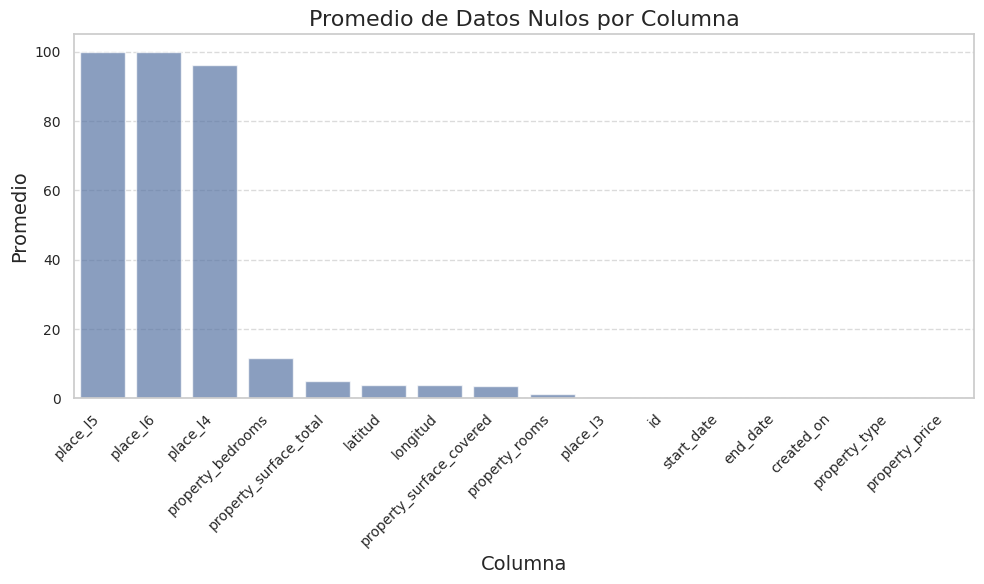

In [273]:
ds_porcentaje = promedio_datos_nulos

# Ordenar los valores en orden descendente
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)

# Establecer el estilo del gráfico
sns.set_style("whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar el gráfico de barras
bar_plot = sns.barplot(x=ds_porcentaje.index, y=ds_porcentaje.values, alpha=0.7)

# Agregar título y etiquetas
bar_plot.set_title("Promedio de Datos Nulos por Columna", fontsize=16)
bar_plot.set_xlabel("Columna", fontsize=14)
bar_plot.set_ylabel("Promedio", fontsize=14)

# Rotar etiquetas del eje x para una mejor legibilidad
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Agregar líneas de la cuadrícula y ajustar el tamaño de la fuente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Entonces los datos que debo analizar son:

In [274]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_train)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.165732
property_bedrooms            11.684505
property_surface_total        5.139325
latitud                       3.887319
longitud                      3.887319
property_surface_covered      3.557076
property_rooms                1.119378
place_l3                      0.428388
dtype: float64

In [275]:
obtener_cantidad_nulos(ds_test)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.010610
property_bedrooms            11.549072
property_surface_total        5.140584
latitud                       4.238727
longitud                      4.238727
property_surface_covered      3.564987
property_rooms                1.061008
place_l3                      0.498674
dtype: float64

#### Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [276]:
columnas = ['place_l6','place_l5','place_l4']
ds_train.drop(columns=columnas, inplace=True)
ds_test.drop(columns=columnas, inplace=True)

In [277]:
ds_train.head()

id  start_date    end_date created_on  \
45748   MAewqGlr+bEVCoz1BmrrVA==  2021-05-02  2021-06-05 2021-05-02   
173359  D7yJnGrID2bxDTkuca6LYA==  2021-05-11  2022-02-09 2021-05-11   
255728  9YqLDx1M2/a+dn6jUriUmA==  2021-11-03  2022-09-17 2021-11-03   
328392  +I/B18XvSK8LXIJrA8qlaQ==  2021-12-14  2022-01-27 2021-12-14   
397628  w8Ade7GPHXOZwfOFRgnIag==  2021-02-13  2021-03-01 2021-02-13   

          latitud   longitud          place_l3 property_type  property_rooms  \
45748  -34.603915 -58.416817           Almagro  Departamento             4.0   
173359 -34.636153 -58.425937  Parque Chacabuco          Casa             6.0   
255728 -34.629834 -58.463767            Flores  Departamento             3.0   
328392 -34.599342 -58.488135  Villa del Parque  Departamento             3.0   
397628 -34.590965 -58.425679           Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
45748                 3.0                     NaN                      72.0   
173359                4.0                   262.0                     175.0   
255728                2.0                   106.0                      69.0   
328392                2.0                    78.0                      59.0   
397628                1.0                    59.0                      52.0   

        property_price  
45748         165000.0  
173359        360000.0  
255728        240000.0  
328392        146000.0  
397628        195000.0

In [278]:
ds_test.head()

id  start_date    end_date  created_on  \
176567  k0geST92a1S/KCcJLrB9Bw==  2021-08-31  2021-09-03  2021-08-31   
17970   qI6Y/O2nOZDF7y2fTqGBKA==  2021-08-28  2022-06-27  2021-08-28   
270818  PEs5++ryksuh3Ih2gwdNxQ==  2021-07-13  2021-09-01  2021-07-13   
303099  FTl0xDv5BARF6HTi73WKLg==  2021-08-26  2021-10-17  2021-08-26   
58741   Pz6vvY78L/09D0Ly1ZV2EA==  2021-03-13  2021-03-18  2021-03-13   

          latitud   longitud       place_l3 property_type  property_rooms  \
176567 -34.613056 -58.360278  Puerto Madero  Departamento             2.0   
17970  -34.568651 -58.493884  Villa Urquiza  Departamento             2.0   
270818 -34.558886 -58.460713       Belgrano  Departamento             4.0   
303099 -34.615488 -58.385905      Monserrat  Departamento             4.0   
58741  -34.574876 -58.442355     Colegiales            PH             6.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
176567                1.0                    82.0                      78.0   
17970                 1.0                    45.0                      42.0   
270818                3.0                    95.0                      95.0   
303099                3.0                   102.0                     102.0   
58741                 4.0                   168.0                     125.0   

        property_price  
176567        380000.0  
17970         100000.0  
270818        275000.0  
303099        125000.0  
58741         245000.0

In [279]:
nulos_preimputacion = obtener_cantidad_nulos(ds_train)

In [280]:
obtener_cantidad_nulos(ds_test)

property_bedrooms           11.549072
property_surface_total       5.140584
latitud                      4.238727
longitud                     4.238727
property_surface_covered     3.564987
property_rooms               1.061008
place_l3                     0.498674
dtype: float64

#### Generar funciones para análisis

In [281]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_train[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [282]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [283]:
def generar_grafico(ds, columna):
  # Ajustar el tamaño de la figura
  plt.figure(figsize=(10, 6))

  # Agrupar por 'longitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
  ds.groupby(columna).size().plot(kind='barh', color=sns.color_palette('Dark2'))

  # Ocultar los ejes superior y derecho
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  titulo = 'Tamaño de Grupo por ' + columna
  # Configurar el tamaño de la letra del título y las etiquetas
  plt.title(titulo, fontsize=16)
  plt.xlabel('Cantidad', fontsize=14)
  plt.ylabel(columna, fontsize=14)

  # Mostrar el gráfico
  plt.show()
    #titulo = "Gráfico de barras: Cantidad de nulos en la variable " + columna
    #ds[columna].value_counts().plot.bar(alpha=0.5, title=titulo, xlabel="tipo de dato", ylabel="cantidad de filas", fontsize=10)

#### Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [284]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()



latitud longitud
45748   no nulo  no nulo
173359  no nulo  no nulo
255728  no nulo  no nulo
328392  no nulo  no nulo
397628  no nulo  no nulo

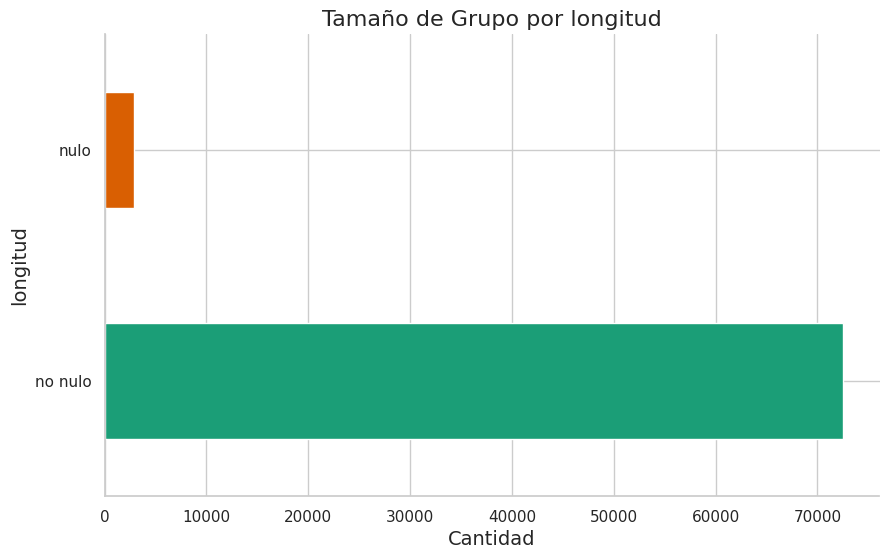

In [285]:
generar_grafico(latatitud_longitud, 'longitud')

In [286]:
cant_nulos_longitud,cant_no_nulos_longitud = contar_ds(latatitud_longitud,'longitud')
imprimir_cantidades(cant_nulos_longitud,cant_no_nulos_longitud,'longitud')

Cantidad de datos NULOS en longitud: 72468
Cantidad de datos NO NULOS en longitud: 2931


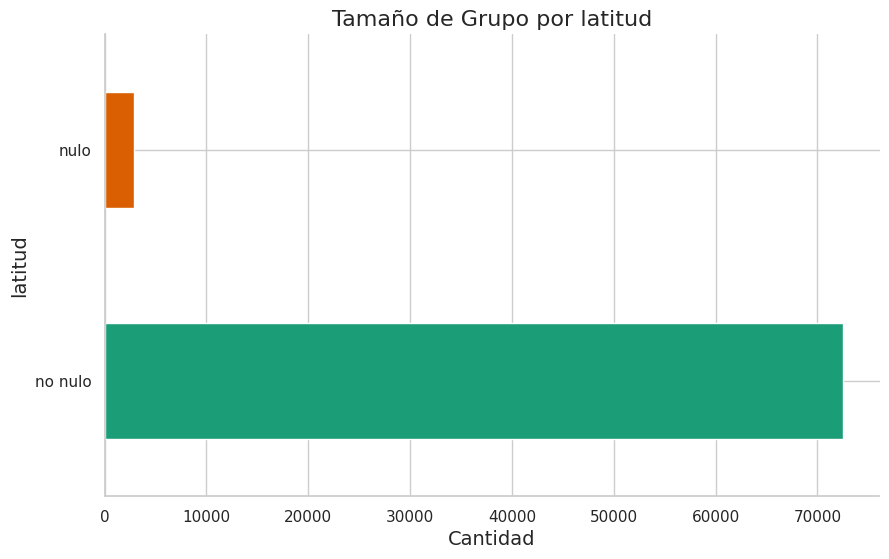

In [287]:
generar_grafico(latatitud_longitud,'latitud')

In [288]:
cant_nulos_longitud,cant_no_nulos_longitud = contar_ds(latatitud_longitud,'latitud')
imprimir_cantidades(cant_nulos_longitud,cant_no_nulos_longitud,'latitud')

Cantidad de datos NULOS en latitud: 72468
Cantidad de datos NO NULOS en latitud: 2931


#### Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [289]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

property_surface_total property_surface_covered
45748                    nulo                  no nulo
173359                no nulo                  no nulo
255728                no nulo                  no nulo
328392                no nulo                  no nulo
397628                no nulo                  no nulo

In [290]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_total')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 71524
Cantidad de datos NO NULOS en property_surface_total: 3875


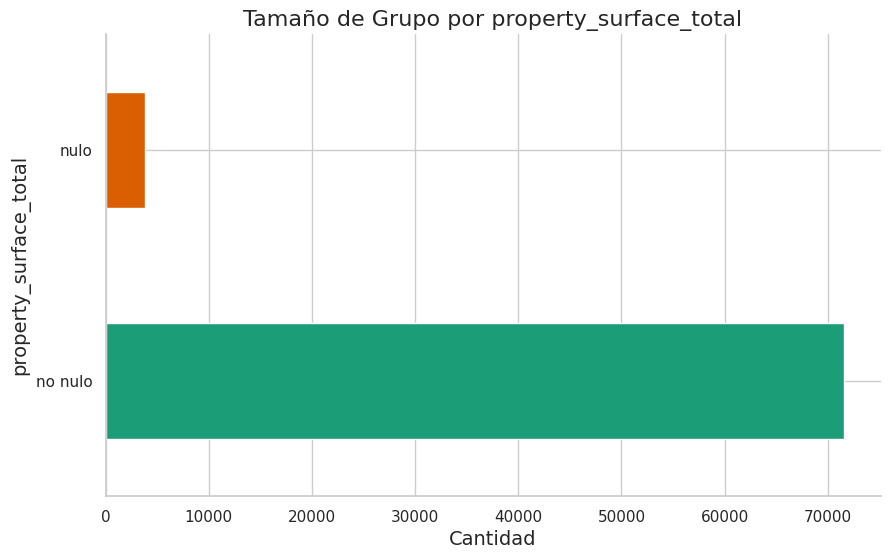

In [291]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [292]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_covered')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 72717
Cantidad de datos NO NULOS en property_surface_covered: 2682


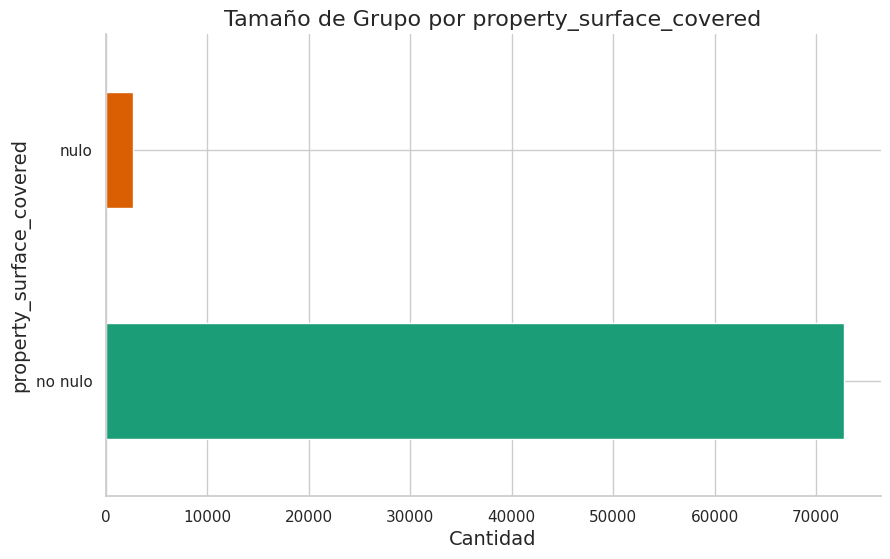

In [293]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

#### Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [294]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

property_rooms property_bedrooms
45748         no nulo           no nulo
173359        no nulo           no nulo
255728        no nulo           no nulo
328392        no nulo           no nulo
397628        no nulo           no nulo

In [295]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_rooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_rooms')

Cantidad de datos NULOS en property_rooms: 74555
Cantidad de datos NO NULOS en property_rooms: 844


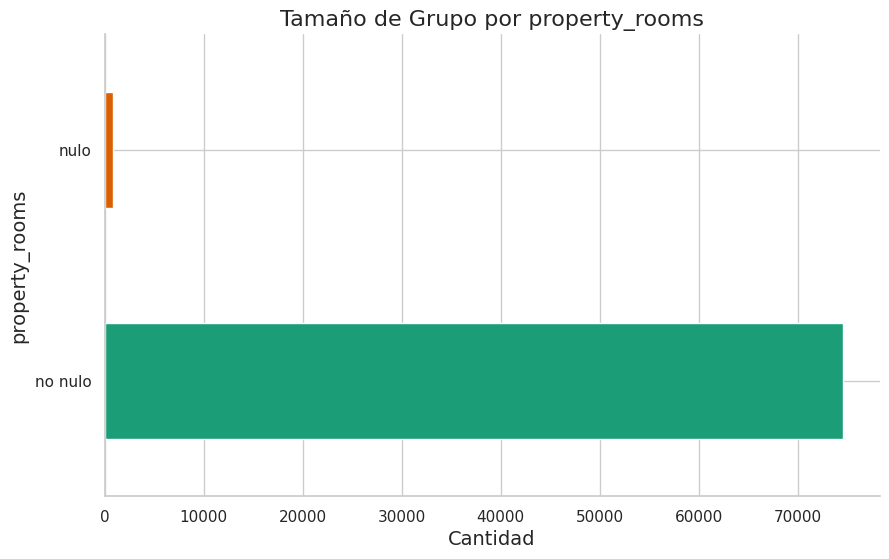

In [296]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [297]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_bedrooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 66589
Cantidad de datos NO NULOS en property_bedrooms: 8810


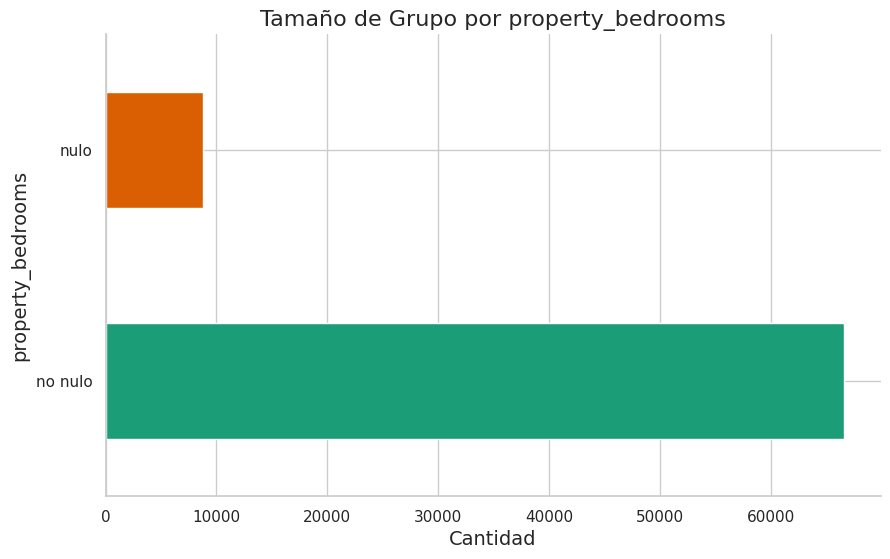

In [298]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

#### Barrio (place_l3)

In [299]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

45748     no nulo
173359    no nulo
255728    no nulo
328392    no nulo
397628    no nulo
Name: place_l3, dtype: object

In [300]:
imprimir_cantidades(barrio.value_counts()[0],barrio.value_counts()[1],'place_l3')

Cantidad de datos NULOS en place_l3: 75076
Cantidad de datos NO NULOS en place_l3: 323


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

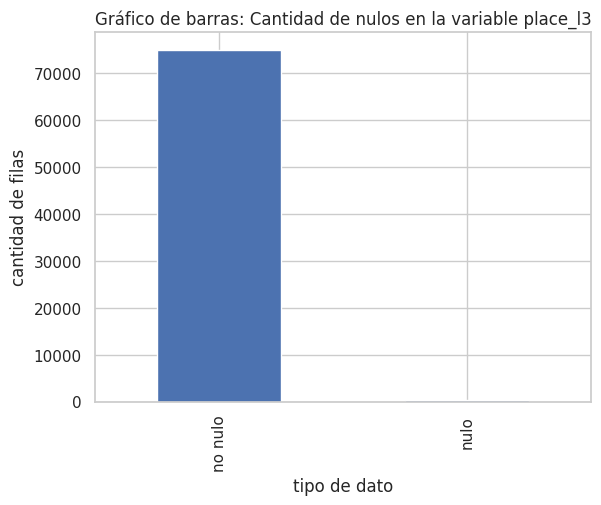

In [301]:
barrio.value_counts().plot.bar(alpha=1,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

#### Precio

In [302]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

45748     no nulo
173359    no nulo
255728    no nulo
328392    no nulo
397628    no nulo
Name: property_price, dtype: object

In [303]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))
precio.value_counts()

Cantidad de datos NO NULOS en property_price: property_price
no nulo    75399
Name: count, dtype: int64


property_price
no nulo    75399
Name: count, dtype: int64

<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

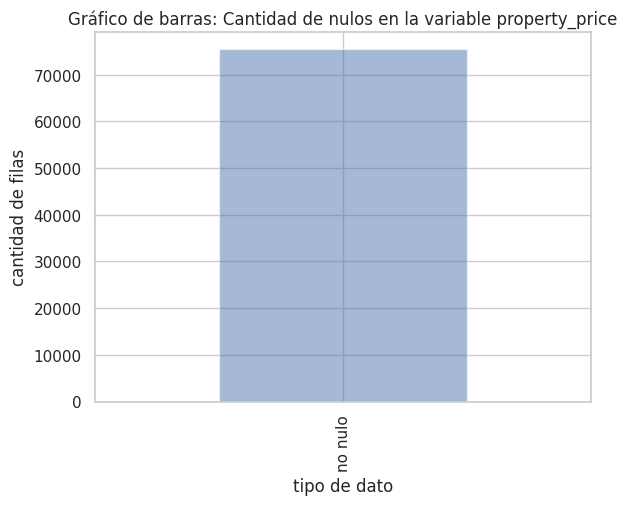

In [304]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

### Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [305]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_train.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  17063


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en ds_train'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

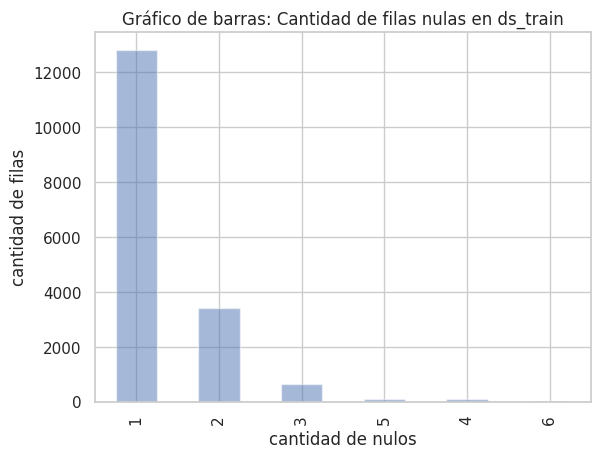

In [306]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en ds_train", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

### Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_train

In [307]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.684505
property_surface_total       5.139325
latitud                      3.887319
longitud                     3.887319
property_surface_covered     3.557076
property_rooms               1.119378
place_l3                     0.428388
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

#### Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [308]:
ds_pre_imputacion = ds_train.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [309]:
ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_train)
completar_barrios(ds_test)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [310]:
# Ordenar el DataFrame por 'place_l3'
ds_train_sorted = ds_train.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_train_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_train_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_train_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_train_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_train_sorted

place_l3                        id  start_date    end_date  \
27      AGRONOMIA                       NaN         NaN         NaN   
4         ALMAGRO                       NaN         NaN         NaN   
183334     Abasto  8MvDjJl7KnpE4wwa5+h7+Q==  2021-11-14  2021-11-18   
228367     Abasto  /UM4f5dQpK59gBUlu8XjeA==  2021-03-08  2021-06-05   
27433      Abasto  BYCUgbiO1i4nFDyxaPN0ig==  2021-12-03  2022-01-27   
...           ...                       ...         ...         ...   
101433        NaN  cmRbmuzeNxXiwul+tw+Zwg==  2021-05-28  2021-06-05   
411053        NaN  y41y+zCHtknU3E19ftou1A==  2021-03-02  2021-06-05   
130469        NaN  D5VeRalUQtKaxg1wSOPqPA==  2021-05-27  2021-06-05   
125436        NaN  M5Sv89K3N2XSS7cK57DNxg==  2021-10-05  2021-10-16   
131201        NaN  3TupSuGFOw7CerK8cDO5ug==  2021-05-27  2021-06-05   

       created_on    latitud   longitud property_type  property_rooms  \
27            NaT        NaN        NaN           NaN             NaN   
4             NaT        NaN        NaN           NaN             NaN   
183334 2021-11-14 -34.603787 -58.414353  Departamento             3.0   
228367 2021-03-08 -34.601053 -58.408362            PH             3.0   
27433  2021-12-03 -34.601614 -58.412602  Departamento             3.0   
...           ...        ...        ...           ...             ...   
101433 2021-05-28 -32.971045 -60.631107          Casa             NaN   
411053 2021-03-02 -32.993973 -60.626941  Departamento             4.0   
130469 2021-05-27 -31.622865 -60.609933          Casa             NaN   
125436 2021-10-05        NaN        NaN  Departamento             1.0   
131201 2021-05-27 -31.595840 -60.940230  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
27                    NaN                     NaN                       NaN   
4                     NaN                     NaN                       NaN   
183334                2.0                    49.0                      46.0   
228367                1.0                    63.0                       NaN   
27433                 2.0                    60.0                      56.0   
...                   ...                     ...                       ...   
101433                2.0                     NaN                     200.0   
411053                2.0                    55.0                      55.0   
130469                3.0                     NaN                     100.0   
125436                NaN                    62.0                      36.0   
131201                2.0                    75.0                      75.0   

        property_price  
27                 NaN  
4                  NaN  
183334         87000.0  
228367        195000.0  
27433         126000.0  
...                ...  
101433        140000.0  
411053         20000.0  
130469        110000.0  
125436         69000.0  
131201         68000.0  

[75419 rows x 13 columns]

Vemos que hay datos NaN en el barrio

In [311]:
ds_train['place_l3'].isna().value_counts()

place_l3
False    75096
True       323
Name: count, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [312]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_train = ds_train.dropna(subset=columnas_a_eliminar)
ds_test =  ds_test.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [313]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.569219
property_surface_total       5.018124
property_surface_covered     3.537729
property_rooms               0.971250
dtype: float64

#### Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

##### Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [314]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                          True
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [315]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

id  start_date    end_date  created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18  2021-01-07   

          latitud   longitud         place_l2       place_l3 place_l4  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
406880      NaN       NaN     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880               -1.0                    61.0                      43.0   

        property_price property_currency  \
406880        125000.0               USD   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

Como hay un registro, procederemos a asignarlo nulo.

In [461]:
ds_train.loc[ds_train['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

In [475]:
filtro = ds_train['property_bedrooms'] < 1
ds_train[filtro]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms, place_encoded, type_encoded, score_property_surface, score_price_surface_total, score_location_price, property_location_surface_covered]
Index: []

[0 rows x 21 columns]

Se verifica si hay valores menores o iguales que cero.

In [462]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Se realiza el mismo análisis con ds_test

In [463]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_test[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

##### Análisis de duplicados

Verificamos si hay datos duplicados en estas columnas

In [464]:
ds_train[ds_train.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms, place_encoded, type_encoded, score_property_surface, score_price_surface_total, score_location_price, property_location_surface_covered]
Index: []

[0 rows x 21 columns]

In [465]:
ds_test[ds_test.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

Procederemos a eliminar filas duplicadas

In [321]:
size_antes = len(ds_train)
ds_train_filtrado = ds_train.drop_duplicates()
size_despues = len(ds_train_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_train")

Se eliminaron: 0 filas duplicadas de ds_train


In [322]:
ds_train_filtrado.reset_index(drop=True, inplace=True)

In [323]:
size_antes = len(ds_test)
ds_test_filtrado = ds_test.drop_duplicates()
size_despues = len(ds_test_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_test")

Se eliminaron: 0 filas duplicadas de ds_test


In [324]:
ds_test_filtrado.reset_index(drop=True, inplace=True)

##### Completacion de las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijiremos el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [325]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_train,columnas_con_numeros)


<ipython-input-325-72180959683a>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [326]:
obtener_promedio_nulos(ds_train)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64

In [327]:
obtener_cantidad_nulos(ds_train)

'No existen valores NaN'

### Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [328]:
ds_pre_imputacion.head()

id  start_date    end_date created_on  \
45748   MAewqGlr+bEVCoz1BmrrVA==  2021-05-02  2021-06-05 2021-05-02   
173359  D7yJnGrID2bxDTkuca6LYA==  2021-05-11  2022-02-09 2021-05-11   
255728  9YqLDx1M2/a+dn6jUriUmA==  2021-11-03  2022-09-17 2021-11-03   
328392  +I/B18XvSK8LXIJrA8qlaQ==  2021-12-14  2022-01-27 2021-12-14   
397628  w8Ade7GPHXOZwfOFRgnIag==  2021-02-13  2021-03-01 2021-02-13   

          latitud   longitud          place_l3 property_type  property_rooms  \
45748  -34.603915 -58.416817           Almagro  Departamento             4.0   
173359 -34.636153 -58.425937  Parque Chacabuco          Casa             6.0   
255728 -34.629834 -58.463767            Flores  Departamento             3.0   
328392 -34.599342 -58.488135  Villa del Parque  Departamento             3.0   
397628 -34.590965 -58.425679           Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
45748                 3.0                     NaN                      72.0   
173359                4.0                   262.0                     175.0   
255728                2.0                   106.0                      69.0   
328392                2.0                    78.0                      59.0   
397628                1.0                    59.0                      52.0   

        property_price  
45748         165000.0  
173359        360000.0  
255728        240000.0  
328392        146000.0  
397628        195000.0

Recordemos que datos imputamos

In [329]:
nulos_preimputacion

property_bedrooms           11.684505
property_surface_total       5.139325
latitud                      3.887319
longitud                     3.887319
property_surface_covered     3.557076
property_rooms               1.119378
place_l3                     0.428388
dtype: float64

In [330]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

#### Funciones de distribución

In [331]:
def generar_distribucion(variable):
  # Configuración de estilo y colores
  sns.set(style="whitegrid")
  sns.set_palette("pastel")

  # Creo la cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0], width=0.5)
  axes[0].set_title("Boxplot {} pre-imputación".format(variable), fontsize=14)
  axes[0].set_ylabel("Valor", fontsize=12)
  axes[0].set_xlabel("", fontsize=12)

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1], width=0.5)
  axes[1].set_title("Boxplot {} post-imputación".format(variable), fontsize=14)
  axes[1].set_ylabel("Valor", fontsize=12)
  axes[1].set_xlabel("", fontsize=12)

  # Ajusto el diseño
  plt.tight_layout()

  plt.show()

  return

In [332]:
def generar_distribucion_zoom(variable):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  plt.show()
  return

In [333]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [476]:
def comparar_imputacion(pre, post, columna):
    for i in range(len(pre)):
        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, post[columna][i], columna))
    return

#### Comparación property_bedrooms

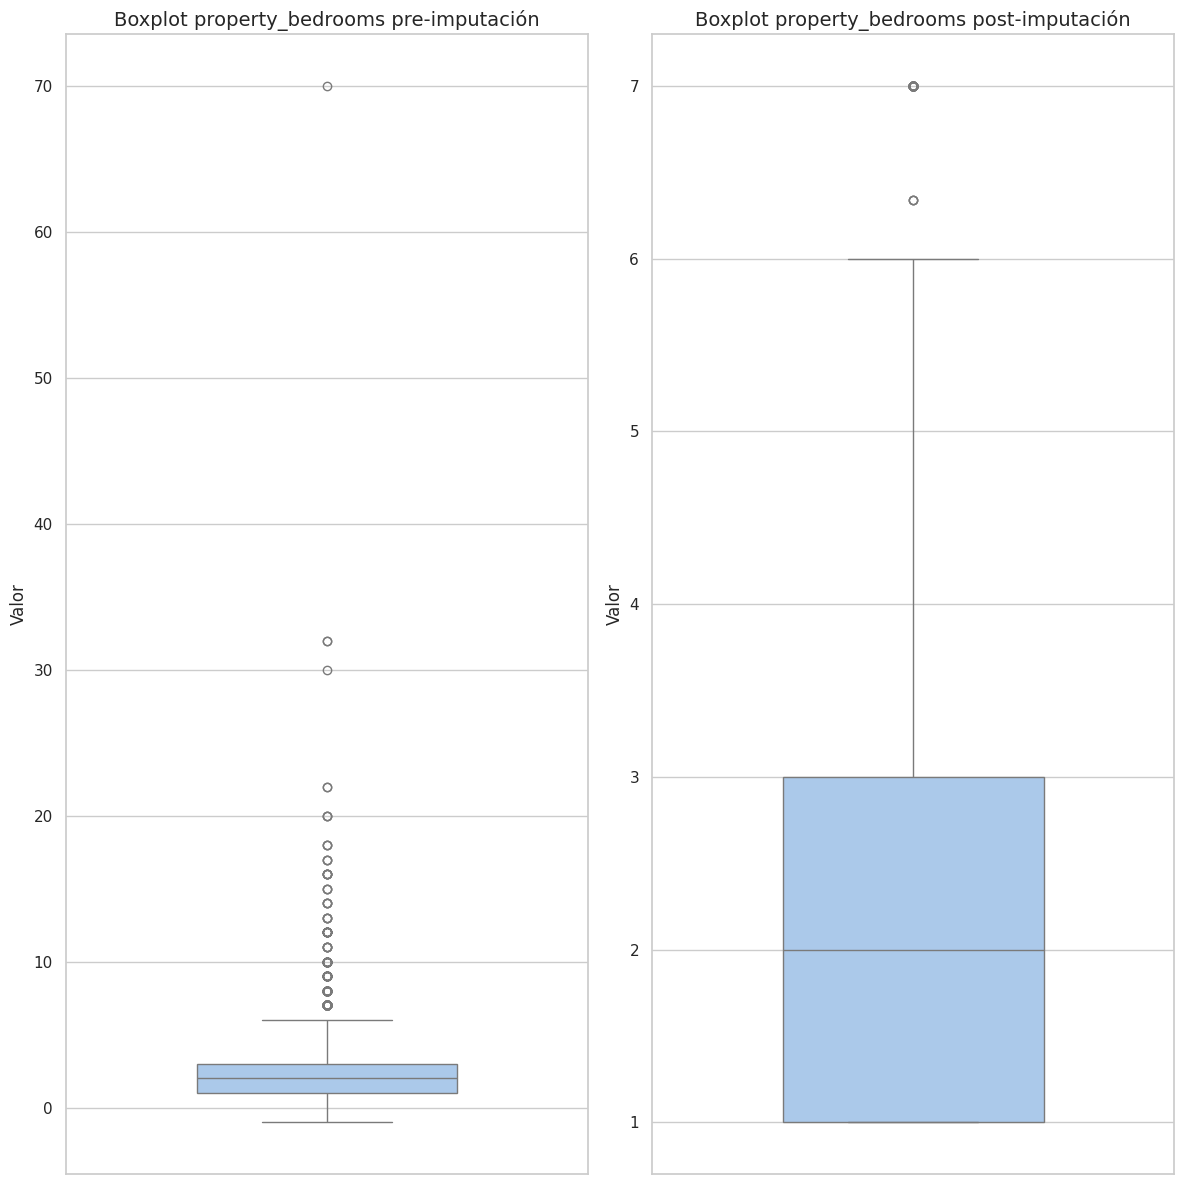

In [477]:
generar_distribucion("property_bedrooms")

Un poco de zoom

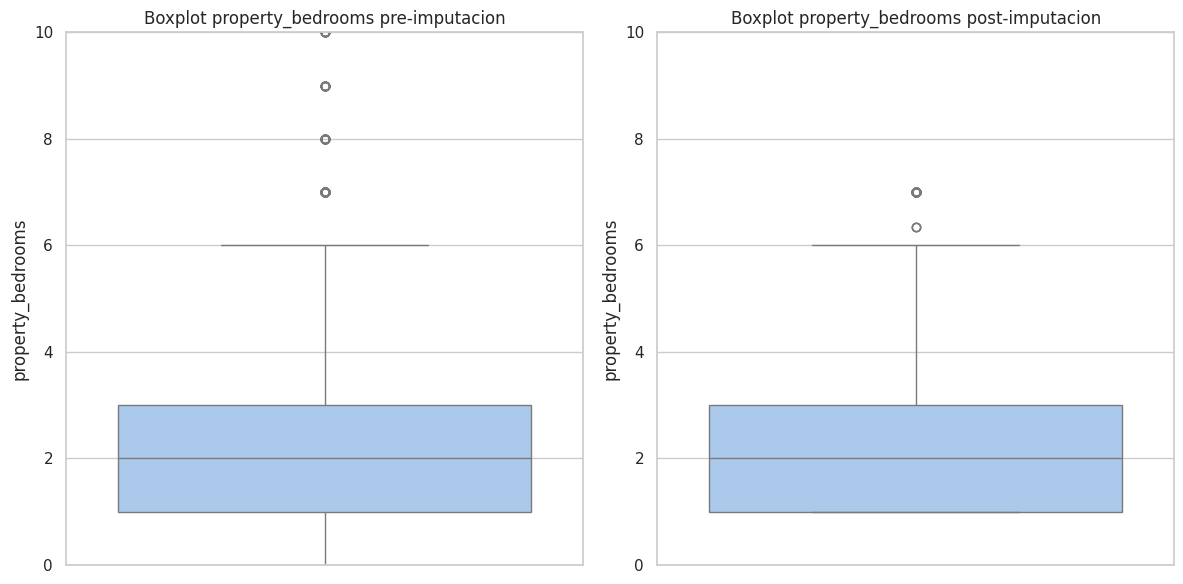

In [478]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [479]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

property_bedrooms  cantidad
0                1.0     25578
1                2.0     21867
2                3.0     14117
3                4.0      3857
4                5.0       741

In [480]:
post_bedrooms = obtener_cantidad_variables(ds_train,'property_bedrooms')
post_bedrooms.head()

property_bedrooms  cantidad
0                1.0     31962
1                2.0     21083
2                3.0     13516
3                4.0      3628
4                5.0       670

Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [481]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

6384 registros se imputaron con el valor de 1.0 property_bedrooms
784 registros se imputaron con el valor de 2.0 property_bedrooms
601 registros se imputaron con el valor de 3.0 property_bedrooms
229 registros se imputaron con el valor de 4.0 property_bedrooms
71 registros se imputaron con el valor de 5.0 property_bedrooms
35 registros se imputaron con el valor de 6.0 property_bedrooms
12 registros se imputaron con el valor de 7.0 property_bedrooms
2 registros se imputaron con el valor de 2.0794415416798357 property_bedrooms
3 registros se imputaron con el valor de 2.4849066497880004 property_bedrooms
0 registros se imputaron con el valor de 2.302585092994046 property_bedrooms
9 registros se imputaron con el valor de 2.1972245773362196 property_bedrooms
10 registros se imputaron con el valor de 2.3978952727983707 property_bedrooms
3 registros se imputaron con el valor de 1.261859519313732 property_bedrooms
3 registros se imputaron con el valor de 1.26187325470131 property_bedrooms
3 re

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

#### Comparación property_rooms

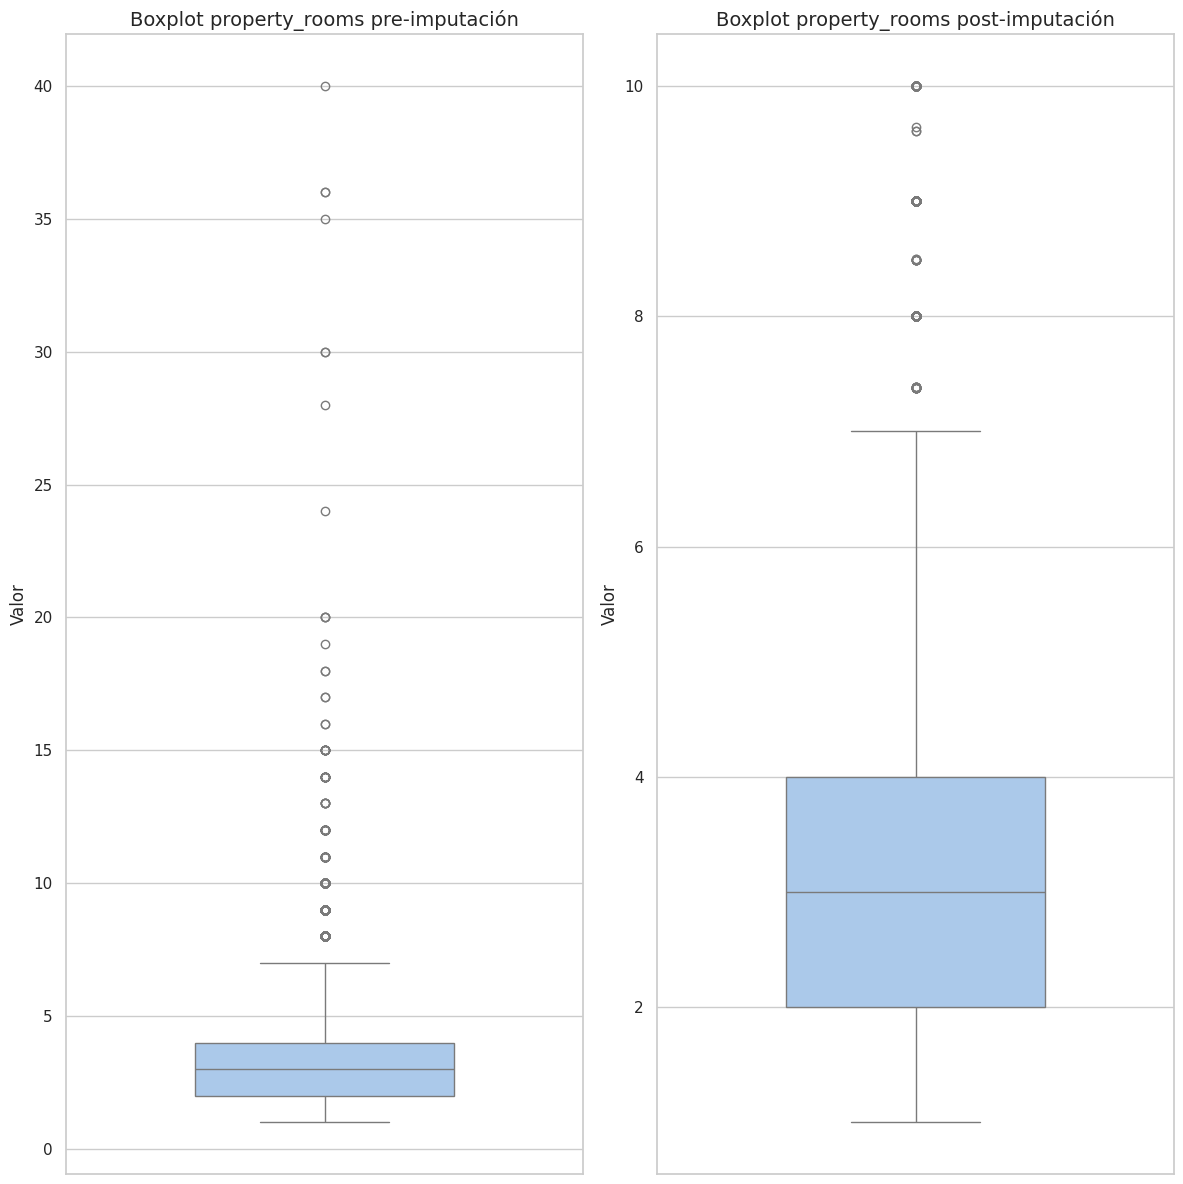

In [482]:
generar_distribucion("property_rooms")

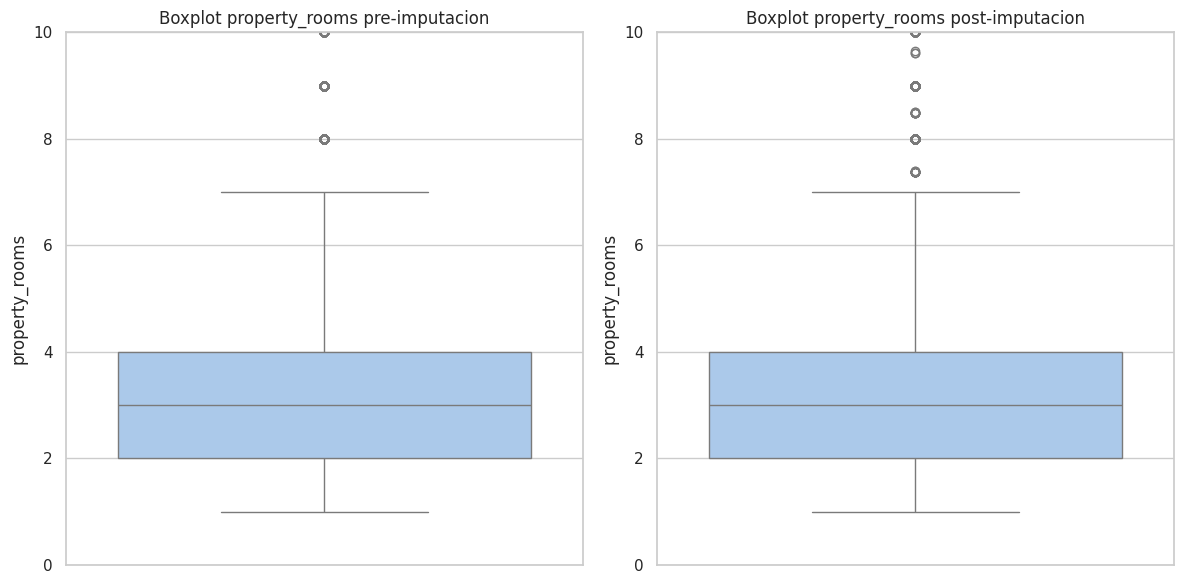

In [483]:
generar_distribucion_zoom("property_rooms")

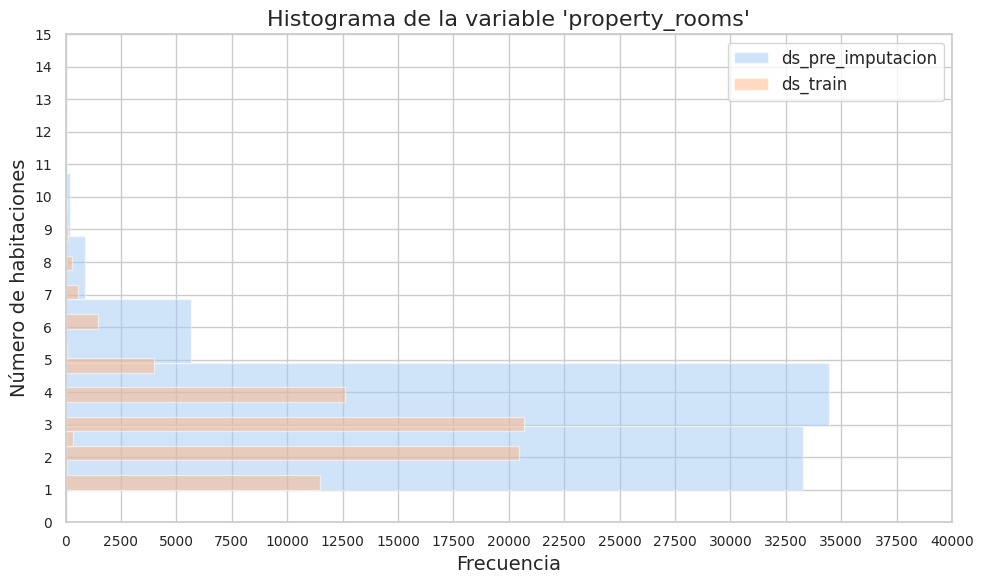

In [484]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_train')

# Ajustes de título y etiquetas
plt.title("Histograma de la variable 'property_rooms'", fontsize=16)
plt.xlabel("Frecuencia", fontsize=14)
plt.ylabel("Número de habitaciones", fontsize=14)

# Ajustes de límites de los ejes (zoom)
plt.ylim(0, 15)
plt.xlim(0, 40000)

# Establecer intervalos del eje x
plt.xticks(np.arange(0, 40001, 2500), fontsize=10)

# Añadir leyenda
plt.legend(fontsize=12)

# Establecer intervalos del eje y
plt.yticks(np.arange(16), fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='property_rooms'>

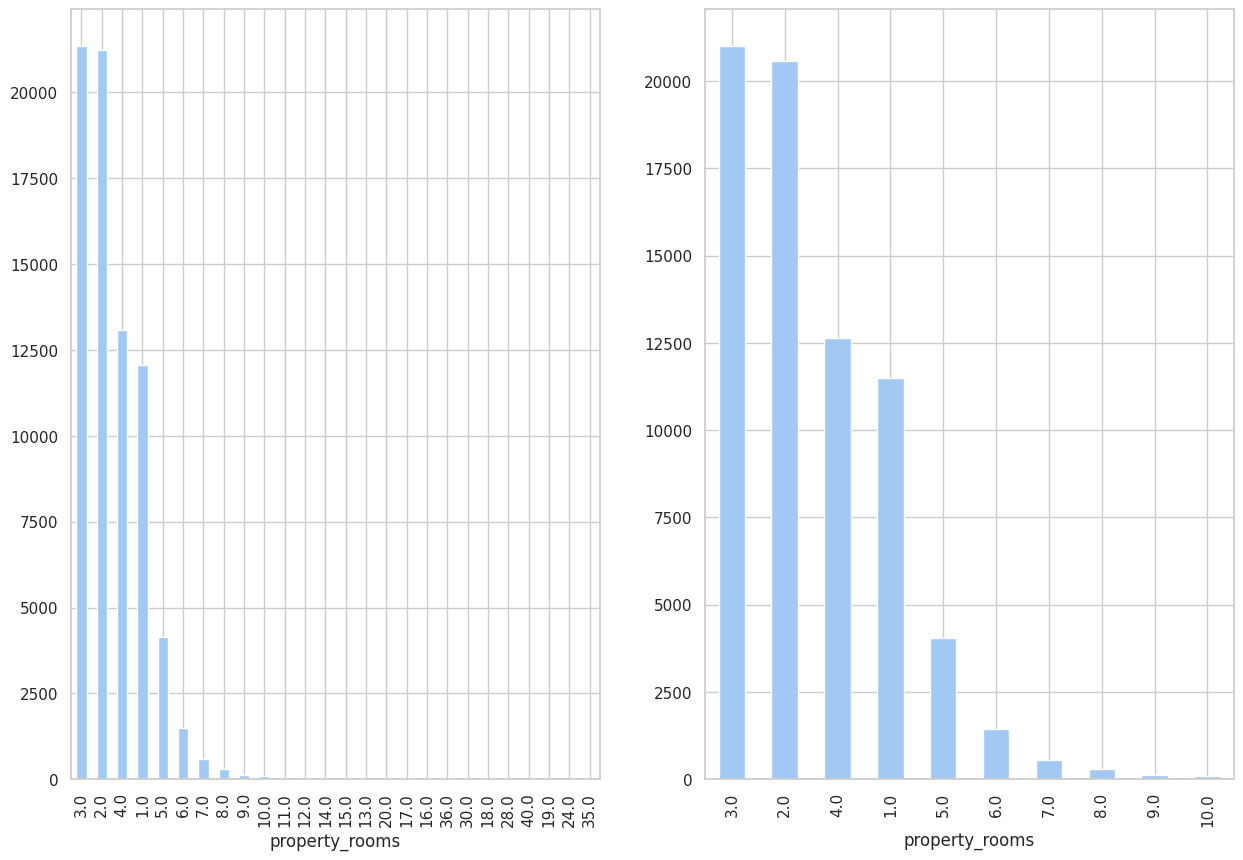

In [485]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [486]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

property_rooms  cantidad
0             3.0     21353
1             2.0     21226
2             4.0     13083
3             1.0     12066
4             5.0      4149

In [487]:
post_rooms = obtener_cantidad_variables(ds_train,'property_rooms')
post_rooms.head()

property_rooms  cantidad
0             3.0     20582
1             2.0     20457
2             4.0     12535
3             1.0     11504
4             5.0      3971

In [488]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

771 registros se imputaron con el valor de 3.0 property_rooms
769 registros se imputaron con el valor de 2.0 property_rooms
548 registros se imputaron con el valor de 4.0 property_rooms
562 registros se imputaron con el valor de 1.0 property_rooms
178 registros se imputaron con el valor de 5.0 property_rooms
75 registros se imputaron con el valor de 6.0 property_rooms
34 registros se imputaron con el valor de 7.0 property_rooms
13 registros se imputaron con el valor de 8.0 property_rooms
1 registros se imputaron con el valor de 9.0 property_rooms
4 registros se imputaron con el valor de 10.0 property_rooms
11 registros se imputaron con el valor de 2.3978952727983707 property_rooms
10 registros se imputaron con el valor de 2.6390573296152584 property_rooms
4 registros se imputaron con el valor de 2.4849066497880004 property_rooms
1 registros se imputaron con el valor de 5.179130476277103 property_rooms
3 registros se imputaron con el valor de 5.160000795492899 property_rooms
5 registros

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

#### Comparación property_surface_total

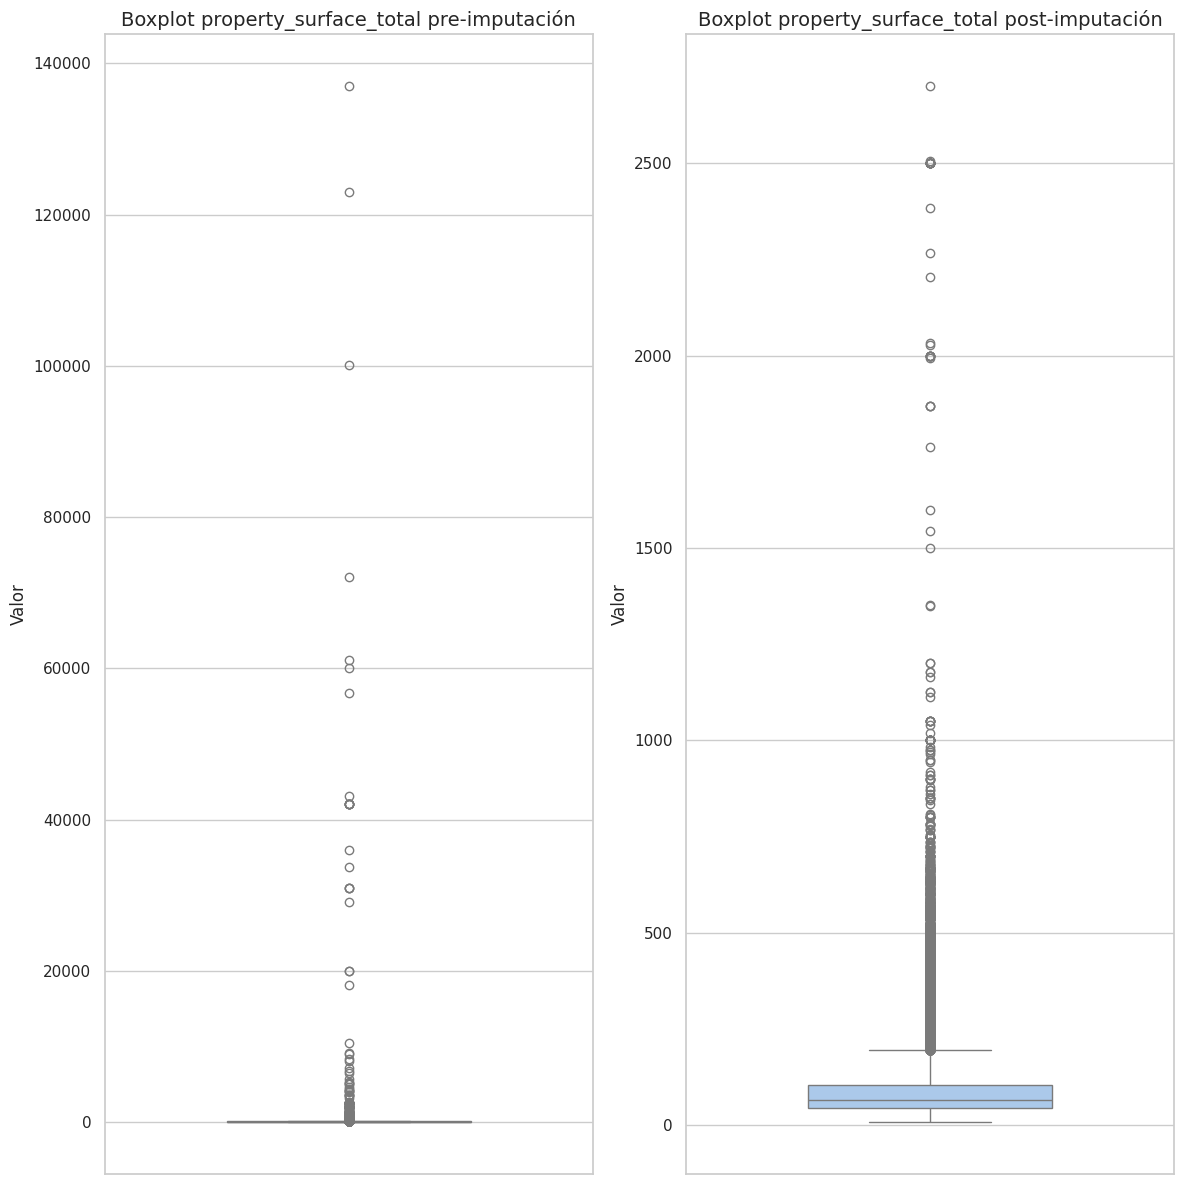

In [489]:
generar_distribucion("property_surface_total")

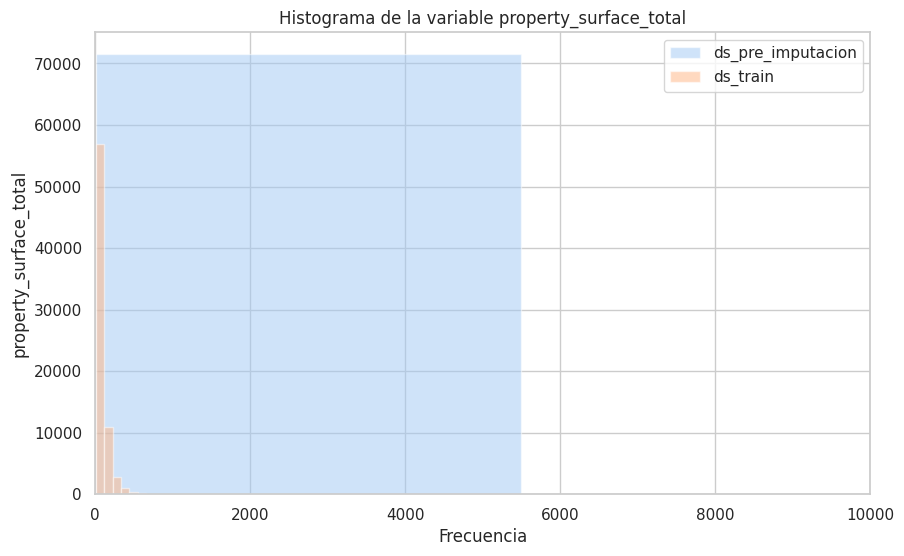

In [490]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_total'], bins=25, alpha=0.5, label='ds_train')

plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)

plt.legend()

plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [491]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

property_surface_total  cantidad
0                    50.0      1427
1                    40.0      1371
2                    45.0      1276
3                    42.0      1265
4                    35.0      1204

In [492]:
post_total = obtener_cantidad_variables(ds_train,'property_surface_total')
post_total.head()

property_surface_total  cantidad
0                    50.0      1356
1                    40.0      1334
2                    45.0      1222
3                    42.0      1221
4                    35.0      1153

In [493]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

71 registros se imputaron con el valor de 50.0 property_surface_total
37 registros se imputaron con el valor de 40.0 property_surface_total
54 registros se imputaron con el valor de 45.0 property_surface_total
44 registros se imputaron con el valor de 42.0 property_surface_total
51 registros se imputaron con el valor de 35.0 property_surface_total
48 registros se imputaron con el valor de 60.0 property_surface_total
52 registros se imputaron con el valor de 38.0 property_surface_total
48 registros se imputaron con el valor de 55.0 property_surface_total
39 registros se imputaron con el valor de 37.0 property_surface_total
29 registros se imputaron con el valor de 44.0 property_surface_total
33 registros se imputaron con el valor de 43.0 property_surface_total
42 registros se imputaron con el valor de 36.0 property_surface_total
54 registros se imputaron con el valor de 48.0 property_surface_total
46 registros se imputaron con el valor de 34.0 property_surface_total
43 registros se impu

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 73 m²


#### Comparación property_surface_covered

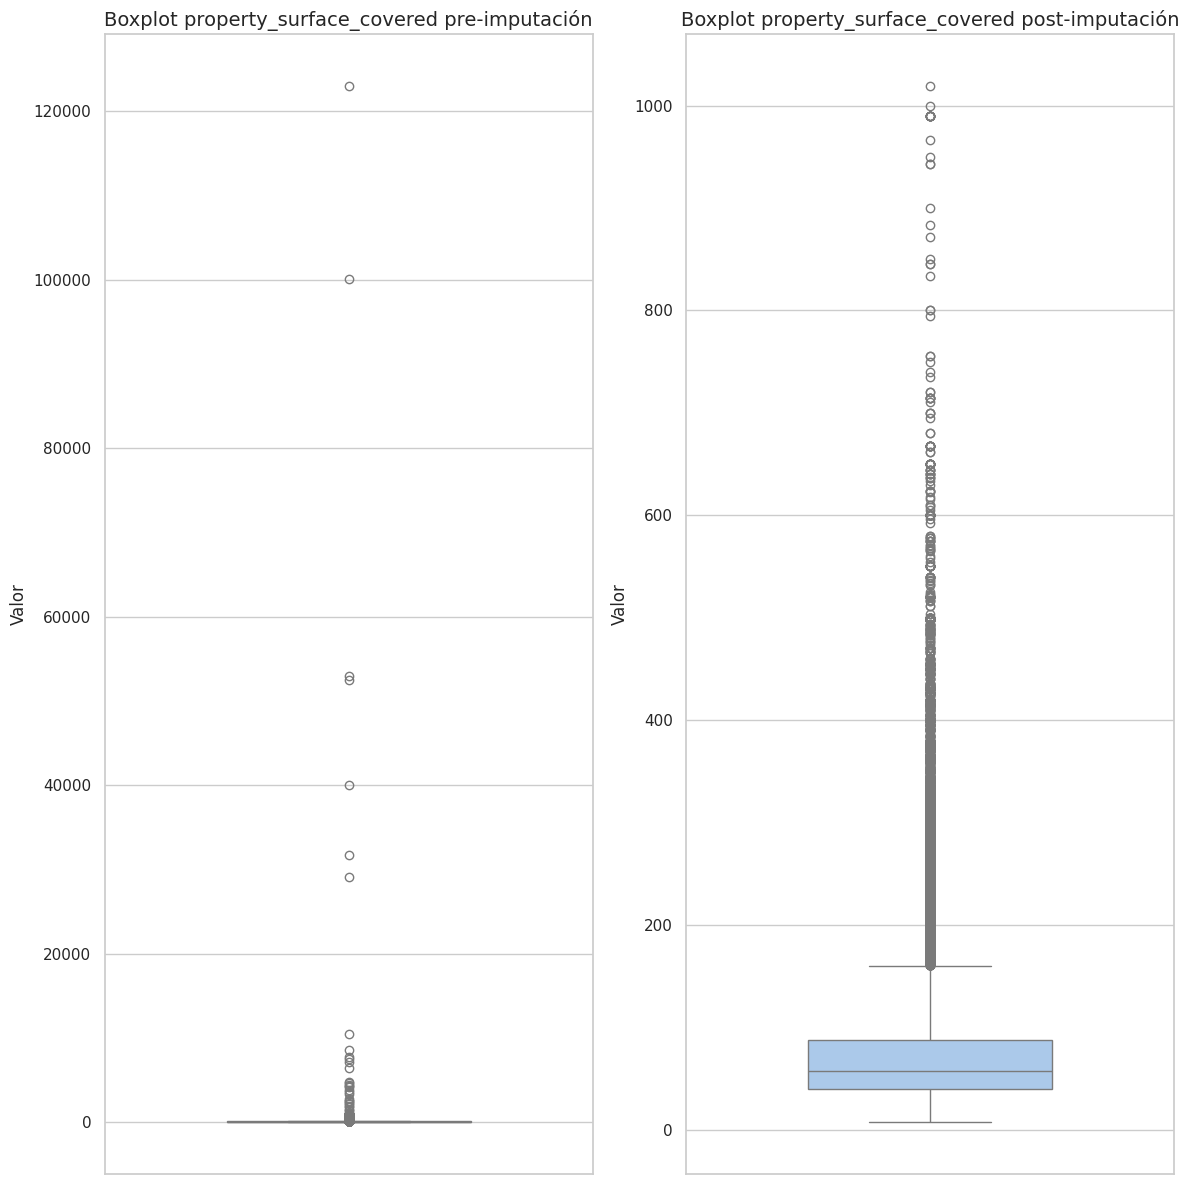

In [494]:
generar_distribucion("property_surface_covered")

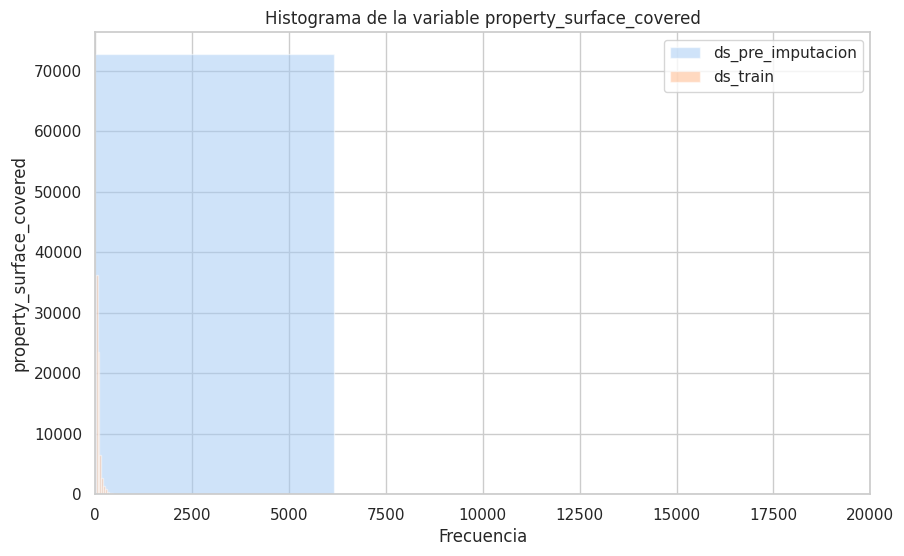

In [495]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_covered'], bins=20, alpha=0.5,  label='ds_train')


plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)

plt.legend()

plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable tenía entre los menos valores nulos.

In [496]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1886
1                      38.0      1612
2                      50.0      1592
3                      45.0      1577
4                      35.0      1457

In [497]:
post_cubierto = obtener_cantidad_variables(ds_train,'property_surface_covered')
post_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1831
1                      50.0      1550
2                      38.0      1541
3                      45.0      1508
4                      42.0      1414

In [498]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

55 registros se imputaron con el valor de 40.0 property_surface_covered
62 registros se imputaron con el valor de 50.0 property_surface_covered
51 registros se imputaron con el valor de 38.0 property_surface_covered
69 registros se imputaron con el valor de 45.0 property_surface_covered
43 registros se imputaron con el valor de 42.0 property_surface_covered
63 registros se imputaron con el valor de 35.0 property_surface_covered
46 registros se imputaron con el valor de 60.0 property_surface_covered
61 registros se imputaron con el valor de 32.0 property_surface_covered
52 registros se imputaron con el valor de 37.0 property_surface_covered
44 registros se imputaron con el valor de 36.0 property_surface_covered
55 registros se imputaron con el valor de 30.0 property_surface_covered
54 registros se imputaron con el valor de 34.0 property_surface_covered
54 registros se imputaron con el valor de 33.0 property_surface_covered
38 registros se imputaron con el valor de 41.0 property_surface_

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 78 m²

#### Comparación latitud

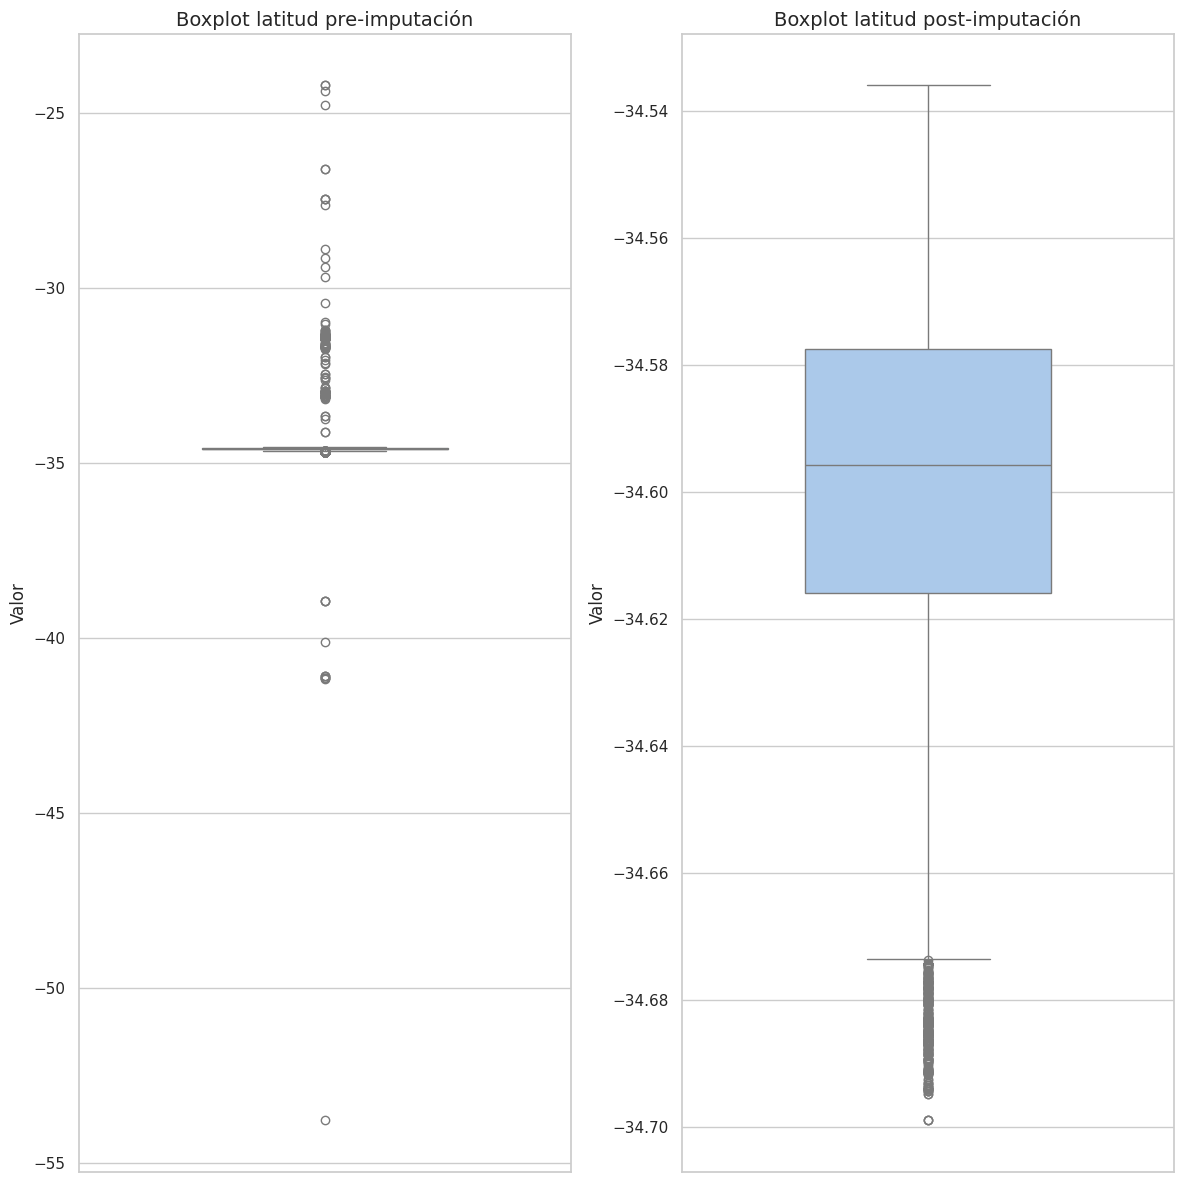

In [499]:
generar_distribucion("latitud")

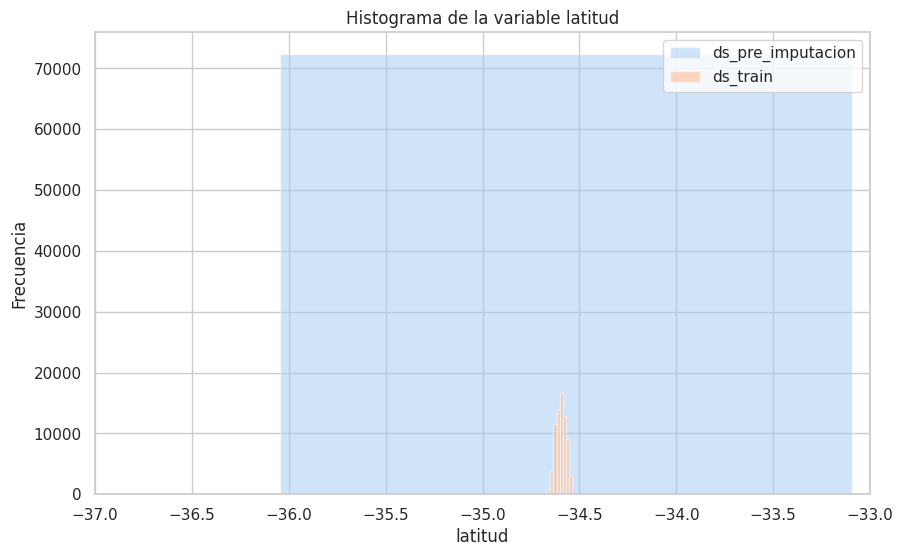

In [500]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['latitud'], bins=10, alpha=0.5, label='ds_train')

plt.xlim(-37, -33)

plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

plt.legend()

plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [501]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

latitud  cantidad
0     -34.541250       107
1     -34.604538        99
2     -34.619406        92
3     -34.541616        84
4     -34.581910        73
...          ...       ...
39363 -34.573496         1
39364 -34.558641         1
39365 -34.644264         1
39366 -34.569412         1
39367 -34.597395         1

[39368 rows x 2 columns]

In [502]:
post_latitud = obtener_cantidad_variables(ds_train,'latitud')
post_latitud

latitud  cantidad
0     -34.541250       107
1     -34.604538        99
2     -34.619406        92
3     -34.541616        84
4     -34.581910        73
...          ...       ...
39223 -34.573496         1
39224 -34.558641         1
39225 -34.644264         1
39226 -34.569412         1
39227 -34.597395         1

[39228 rows x 2 columns]

Parecieran ser iguales... pero lo hemos imputado

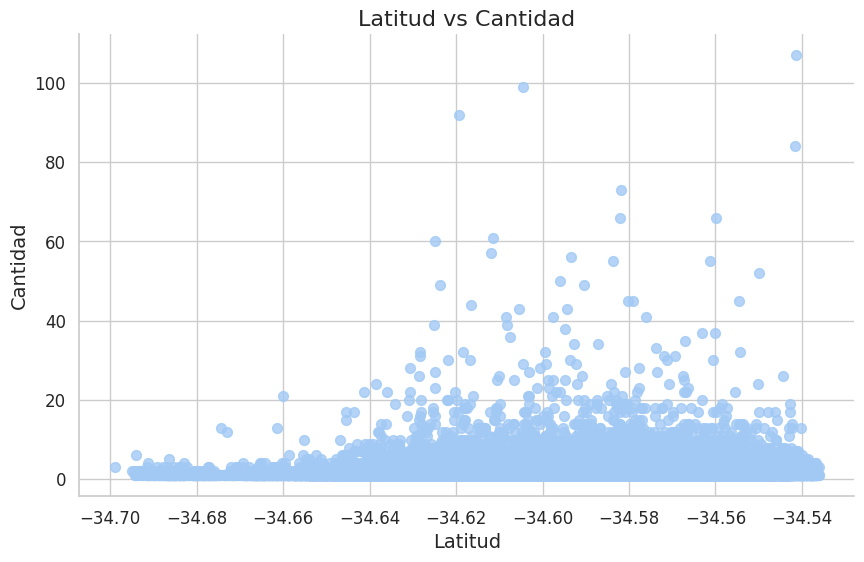

In [503]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_latitud['latitud'], post_latitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Latitud vs Cantidad", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [504]:
pre_latitud.equals(post_latitud)

False

In [505]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

39368
39228
diferencia: 140


#### Comparación longitud

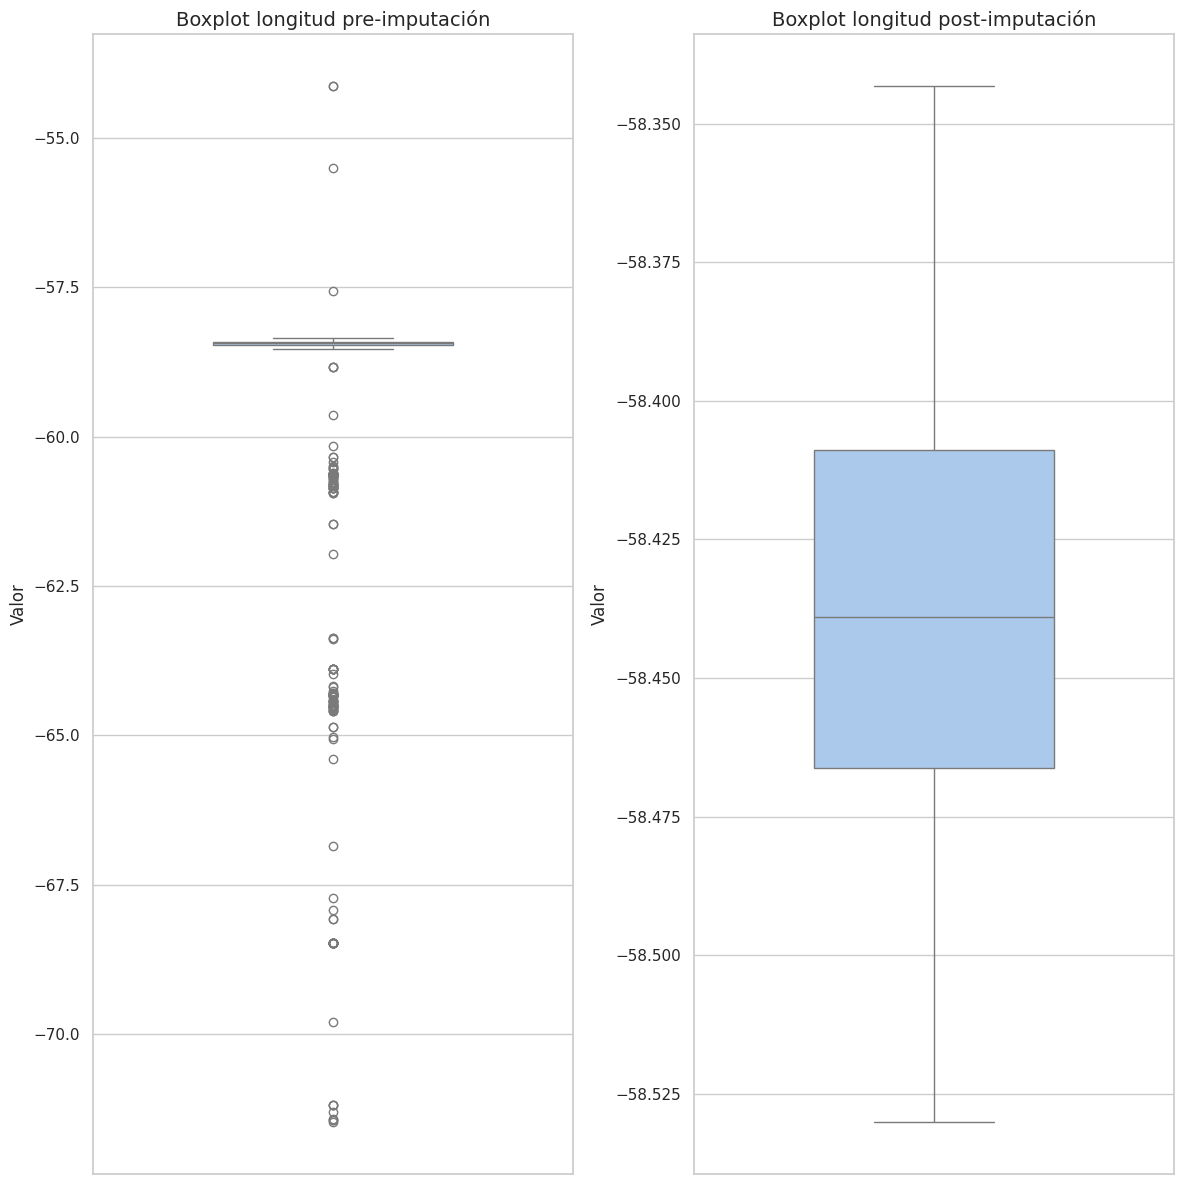

In [506]:
generar_distribucion("longitud")

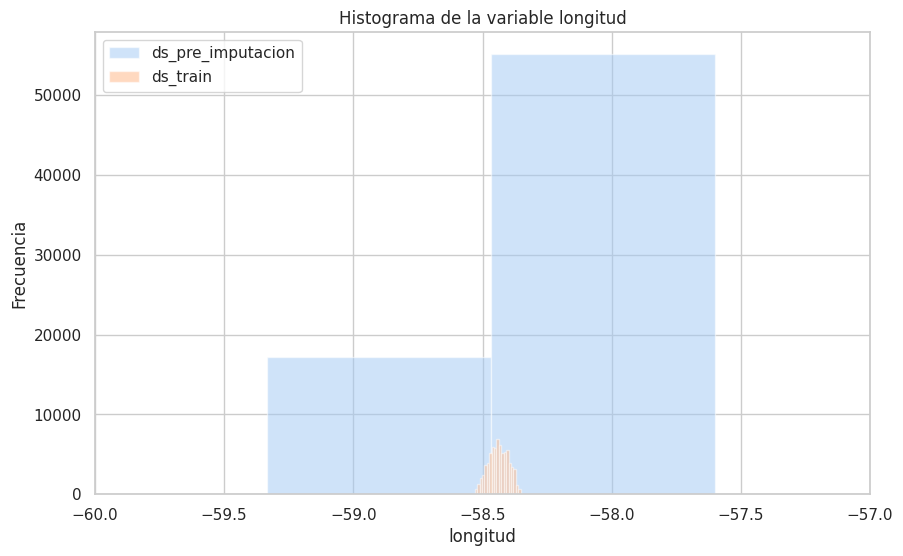

In [507]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['longitud'], bins=20, alpha=0.5, label='ds_train')


plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")

plt.xlim(-60, -57)

plt.legend()

plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.5 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [508]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

longitud  cantidad
0 -58.472966       107
1 -58.424956        99
2 -58.451999        92
3 -58.473377        84
4 -58.449381        73

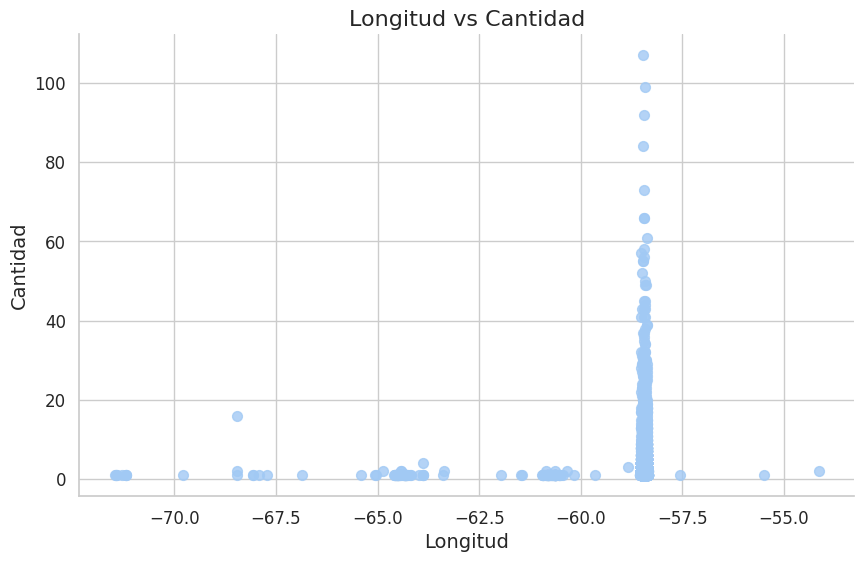

In [509]:
# @title longitud vs cantidad

# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pre_longitud['longitud'], pre_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [510]:
post_longitud = obtener_cantidad_variables(ds_train,'longitud')
post_longitud.head()

longitud  cantidad
0 -58.472966       107
1 -58.424956        99
2 -58.451999        92
3 -58.473377        84
4 -58.449381        73

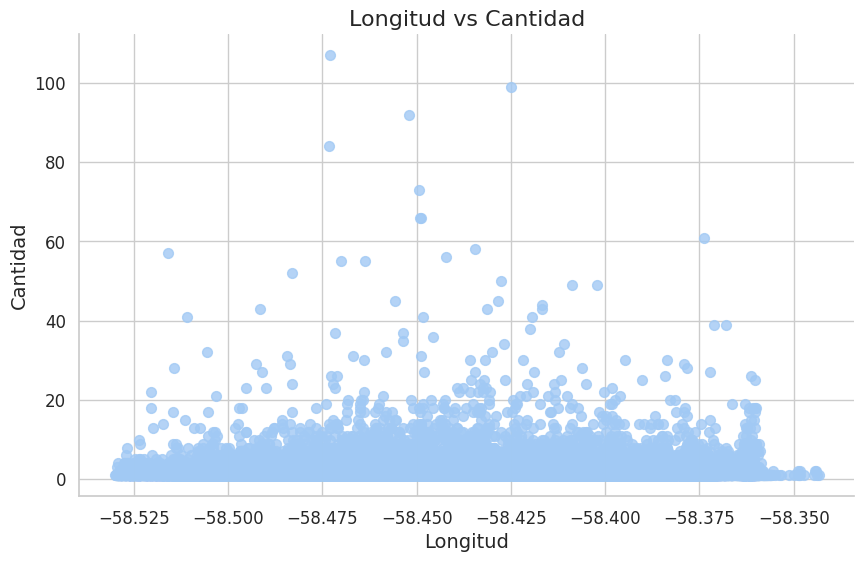

In [511]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_longitud['longitud'], post_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [512]:
pre_longitud.equals(post_longitud)

False

In [513]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

39181
39041
diferencia: 140


#### Comparación place_l3

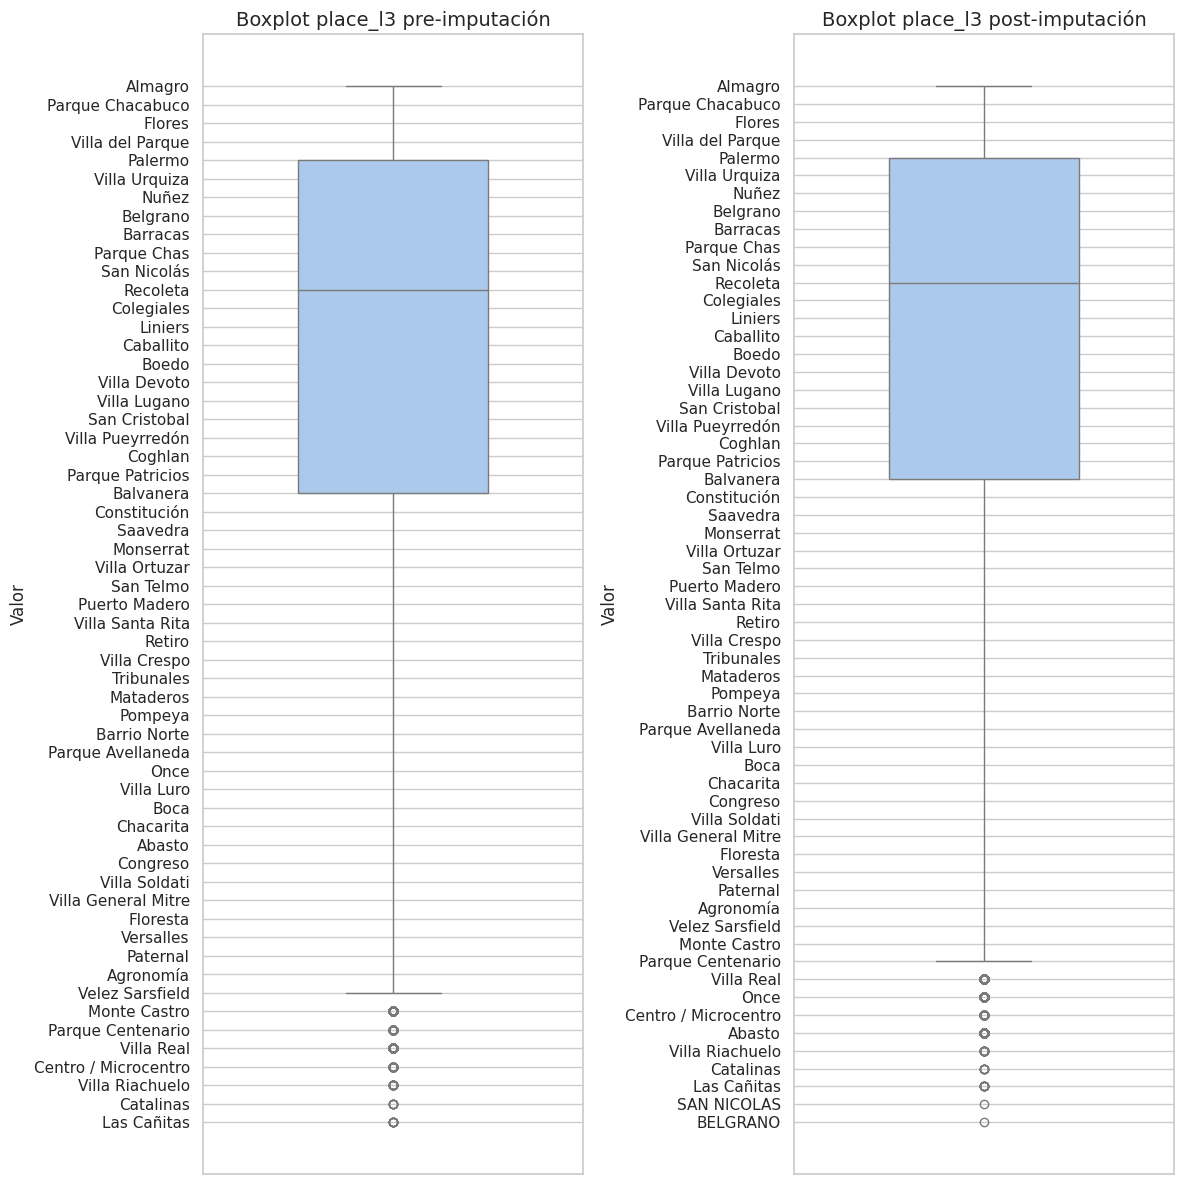

In [514]:
generar_distribucion("place_l3")

Se observa que antes de la imputación, el barrio con mayor cantidad de propiedades era San Cristóbal, mientras que después de la imputación, la media ha cambiado y ahora es Villa Urquiza. No obstante, Palermo continúa siendo el barrio con la mayor cantidad de propiedades en ambos casos.

In [515]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

place_l3  cantidad
0        Palermo     11471
1       Belgrano      7125
2      Caballito      5770
3       Recoleta      5045
4  Villa Urquiza      3726

In [516]:
post_barrio = obtener_cantidad_variables(ds_train,'place_l3')
post_barrio.head()

place_l3  cantidad
0        Palermo     10767
1       Belgrano      6615
2      Caballito      5630
3       Recoleta      4860
4  Villa Urquiza      3610

In [517]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

704 registros se imputaron con el valor de Palermo place_l3
510 registros se imputaron con el valor de Belgrano place_l3
140 registros se imputaron con el valor de Caballito place_l3
185 registros se imputaron con el valor de Recoleta place_l3
116 registros se imputaron con el valor de Villa Urquiza place_l3
132 registros se imputaron con el valor de Almagro place_l3
174 registros se imputaron con el valor de Nuñez place_l3
89 registros se imputaron con el valor de Villa Crespo place_l3
89 registros se imputaron con el valor de Flores place_l3
146 registros se imputaron con el valor de Barrio Norte place_l3
61 registros se imputaron con el valor de Balvanera place_l3
5 registros se imputaron con el valor de Villa Devoto place_l3
7 registros se imputaron con el valor de Colegiales place_l3
7 registros se imputaron con el valor de Saavedra place_l3
6 registros se imputaron con el valor de Villa del Parque place_l3
56 registros se imputaron con el valor de Puerto Madero place_l3
78 regist

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

### *Prefacio*

Recordando lo visto en la sección de variables cualitativas en Exploración inicial.

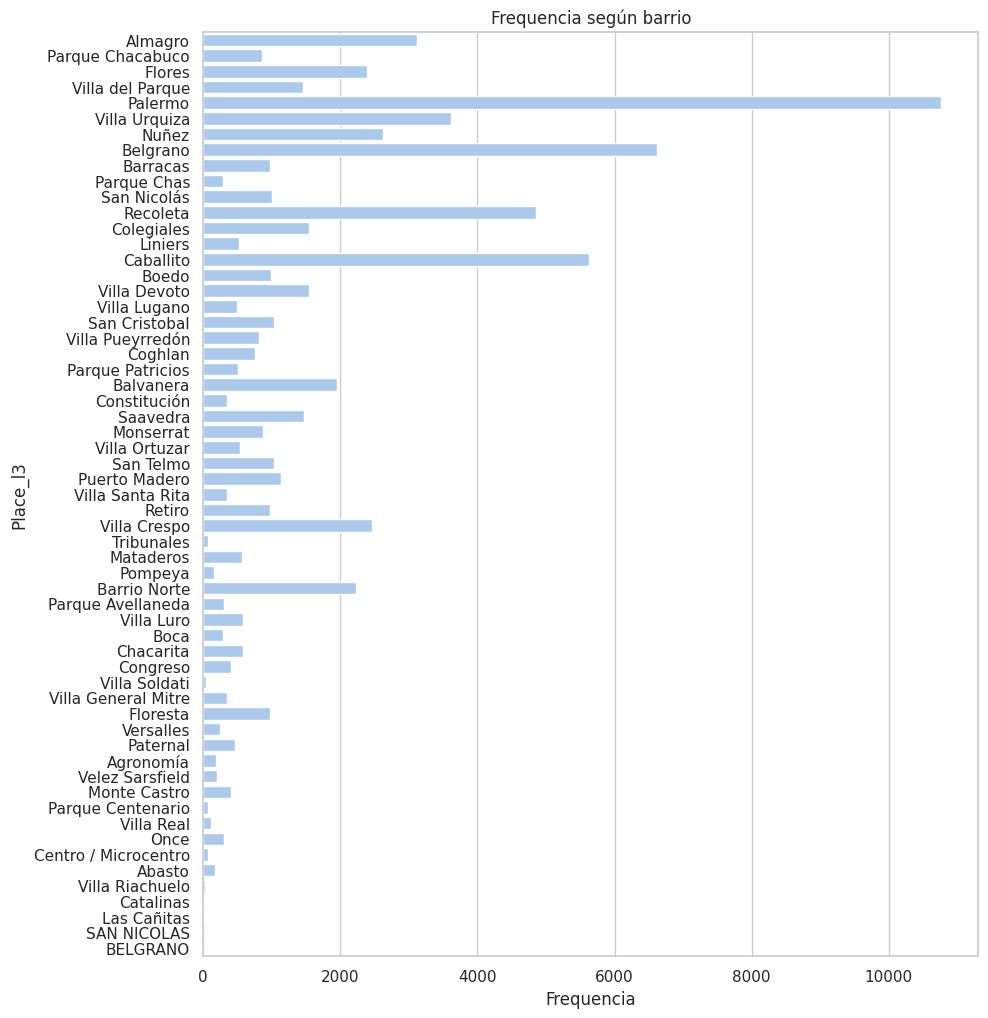

In [376]:
# Hacemos un gráfico de frecuencias de los barrios
plt.figure(figsize=(10, 12))
sns.countplot(y=ds_train.place_l3)
plt.xlabel('Frequencia')
plt.ylabel('Place_l3')
plt.title('Frequencia según barrio')
plt.show()

Las Cañitas, Catalinas, San Nicolas tienen una representación nula/casi nula.
Villa Soldati, Microcentro, Parque Centenario, Villa Riachuelo, Tribunales tienen una representación tan pequeña que tenemos que tener en cuenta que los registros pueden ser casos aislados/no representativos de la realidad de las ventas de inmuebles en el barrio.

In [377]:
# Hacemos una copia del dataset hasta el momento
ds_atipicos = ds_train.copy()

Funciones auxiliares para el análisis:



In [378]:
#Función para cálculo de limite superior e inferior de outliers según cuartiles
def limite_rango_iq(df, variable):
  # Cuartiles
  Q1 = np.quantile(df[variable], 0.25)
  Q3 = np.quantile(df[variable], 0.75)

  # Rango intercuartil
  IQR = Q3 - Q1

  # Limite inferior Outliers
  out_inf = Q1 - 1.5 * IQR

  # Limite superior Outliers
  out_sup = Q1 + 1.5 * IQR

  return out_inf, out_sup

# Funcion para cálculo de Z Score normal
def calculo_z_score(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

#Función para calculo de Z Score modificado
def calculo_z_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

# Grafico comparativo
def plot_comparativo(df_antes, df_despues, var):

  # Create subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot for df_antes
  sns.boxplot(y=df_antes[var], ax=axs[0])
  axs[0].set_title('Antes')

  # Plot for df_despues
  sns.boxplot(y=df_despues[var], ax=axs[1])
  axs[1].set_title('Después')

  # Show plots
  plt.tight_layout()
  plt.show()
  return

# Boxplot por barrio de la variable a evaluar
def plot_por_barrio(df, var):
  # Lista de barrios
  barrios = ['Coghlan','Colegiales','Abasto','Nuñez','Constitución',
             'Boedo', 'San Nicolás', 'Retiro', 'Liniers', 'Almagro',
             'Boca', 'Palermo', 'Balvanera','Barracas', 'Caballito',
             'Villa Ortuzar', 'Villa Luro', 'Puerto Madero', 'Pompeya', 'Saavedra',
             'Parque Chacabuco', 'Belgrano', 'Recoleta', 'Floresta', 'Monserrat',
             'Villa del Parque', 'San Telmo', 'Villa Crespo', 'Tribunales', 'Once',
             'Barrio Norte', 'Villa Lugano', 'Congreso', 'Villa Urquiza', 'Mataderos',
             'Villa Devoto', 'Recoleta', 'San Cristobal', 'Villa Pueyrredon', 'Congreso']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, barrio in enumerate(barrios):
      filtered_data = df[df['place_l3'] == barrio]

      sns.boxplot(y=filtered_data[var], ax=axs[i])

      axs[i].set_title(f'{var} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return



### Análisis univariado

Vamos a intentar identificar los outliers univariados utilizando los IQR y el Z Score.

*Análisis según cantidad de habitaciones(property_bedrooms)*

<Axes: ylabel='property_bedrooms'>

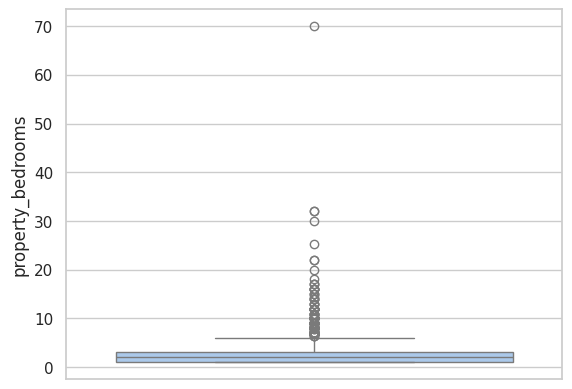

In [379]:
sns.boxplot(y=ds_train.property_bedrooms)

In [380]:
limite_rango_iq(ds_train, 'property_bedrooms')

(-2.0, 4.0)

Primero analizamos el outlier más notorio y verificamos si es un valor posible.

In [381]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 40]
outlier

id  start_date    end_date created_on    latitud  \
94998  4TbEkLoqy/0c3zakd66/FQ==  2021-09-24  2022-01-27 2021-09-24 -34.646632   

        longitud    place_l3 property_type  property_rooms  property_bedrooms  \
94998 -58.497902  Villa Luro  Departamento             3.0               70.0   

       property_surface_total  property_surface_covered  property_price  
94998              807.326652                      70.0        135000.0

Es un departamento de 3 ambientes con 70 habitaciones, lo cual no es posible. Tampoco podemos asumir que es un error de tipeo. A su vez, la superficie total es exagerada en comparación de la superficie cubierta y el precio de la propiedad.  Vamos a eliminar el outlier y visualizar nuevamente el código.  

<ipython-input-382-a0f165733f40>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: ylabel='property_bedrooms'>

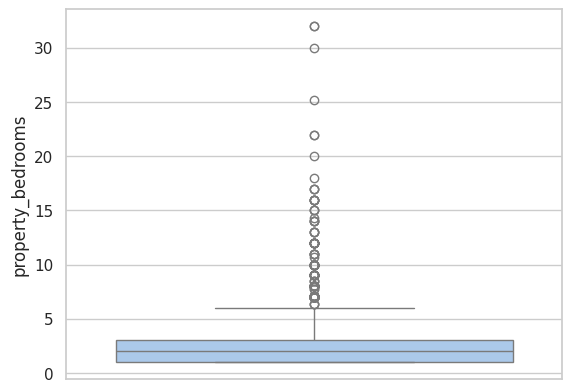

In [382]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_bedrooms'] > 40].index
ds_train.drop(id_outlier,inplace=True)

# Visualizamos
sns.boxplot(y=ds_train.property_bedrooms)

Existen muchos valores atípicos por sobre el umbral marcado por los cuartiles, pero teniendo en cuenta que estamos trabajando con casas, PH y departamentos unicamente, revisaremos las anomalías mayores a 15, a partir de donde no hay muchas ocurrencias.



In [383]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 15]
outlier

id  start_date    end_date created_on  \
292167  CxZv3EmTnK+m6EJD2uQ5fw==  2021-02-23  2021-03-03 2021-02-23   
362676  Gj3g5KCtRbYcwZIuh/wJGg==  2021-01-16  2021-08-06 2021-01-16   
389282  +xTrflFUv4fEGjwpwhP68w==  2021-05-05  2021-06-05 2021-05-05   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
208593  CtbHDgBLf3+kTc20y2iVhw==  2021-11-29  2022-01-14 2021-11-29   
346602  yzI9zylc11wllHX16av6jA==  2021-09-30  2021-11-02 2021-09-30   
307211  uqM9/WXFJkEJnXEQefcpRQ==  2021-09-19  2021-09-19 2021-09-19   
49960   O/JMW/VVo7OmWF7SkXtBuA==  2021-10-16  2021-12-24 2021-10-16   
285222  WHu8kgA8Vu692UM8Dz3gnA==  2021-02-24  2022-02-09 2021-02-24   
48279   r3sXlEIiCgBG5TtUkN93mw==  2021-03-14  2021-06-05 2021-03-14   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
354668  +SPkA/Y4DHEHf+HIppYFKg==  2021-03-31  2021-04-16 2021-03-31   
362696  KuzGWi8jCNPL9nvKAUqLKw==  2021-01-16  2021-08-06 2021-01-16   
402448  9OrT+9jZlW4rMGyZYsmNPA==  2021-09-07  2022-02-09 2021-09-07   
332857  760pAR/aW7whZAZRLML/ZA==  2021-09-17  2022-02-25 2021-09-17   

          latitud   longitud          place_l3 property_type  property_rooms  \
292167 -34.616487 -58.371596         San Telmo            PH            24.0   
362676 -34.618485 -58.377993         San Telmo          Casa            16.0   
389282 -34.570959 -58.458106          Belgrano          Casa            28.0   
86014  -34.591110 -58.400685          Recoleta  Departamento             4.0   
208593 -34.629796 -58.363928              Boca            PH            18.0   
346602 -34.632537 -58.360577              Boca  Departamento            19.0   
307211 -34.611905 -58.382384         Monserrat            PH            15.0   
49960  -34.630186 -58.389156  Parque Patricios  Departamento             1.0   
285222 -34.638432 -58.369712          Barracas            PH            20.0   
48279  -34.608645 -58.485619  Villa del Parque  Departamento             4.0   
150885 -34.642037 -58.438995  Parque Chacabuco  Departamento            35.0   
36421  -34.576061 -58.421289           Palermo  Departamento             3.0   
140832 -34.588454 -58.385257          Recoleta  Departamento             5.0   
354668 -34.611905 -58.382384         Monserrat            PH            15.0   
362696 -34.618485 -58.377993         San Telmo  Departamento            16.0   
402448 -34.611413 -58.389221         Monserrat          Casa            17.0   
332857 -34.611905 -58.382384         Monserrat  Departamento            18.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
292167          22.000000              800.000000                     650.0   
362676          16.000000             1176.853151                     943.0   
389282          16.000000              845.000000                     845.0   
86014           30.000000              148.000000                     138.0   
208593          17.000000              386.000000                     323.0   
346602          18.000000              372.000000                     318.0   
307211          16.000000              587.000000                     276.0   
49960           32.000000               32.000000                      32.0   
285222          17.000000              807.000000                     470.0   
48279           32.000000               83.000000                      75.0   
150885          25.191427               37.000000                      33.0   
36421           20.000000              127.000000                     117.0   
140832          22.000000              386.593307                     144.0   
354668          16.000000              587.000000                     276.0   
362696          16.000000             1176.853151                     943.0   
402448          16.000000              585.000

Tenemos 230 anomalías. Los casos donde el número de ambientes es razonable, parece error de tipeo. Lo corregimos

In [384]:
condition = (ds_train['property_bedrooms'] > 15) & (ds_train['property_rooms'] < 10)
ds_train.loc[condition, 'property_surface_covered'] /= 10

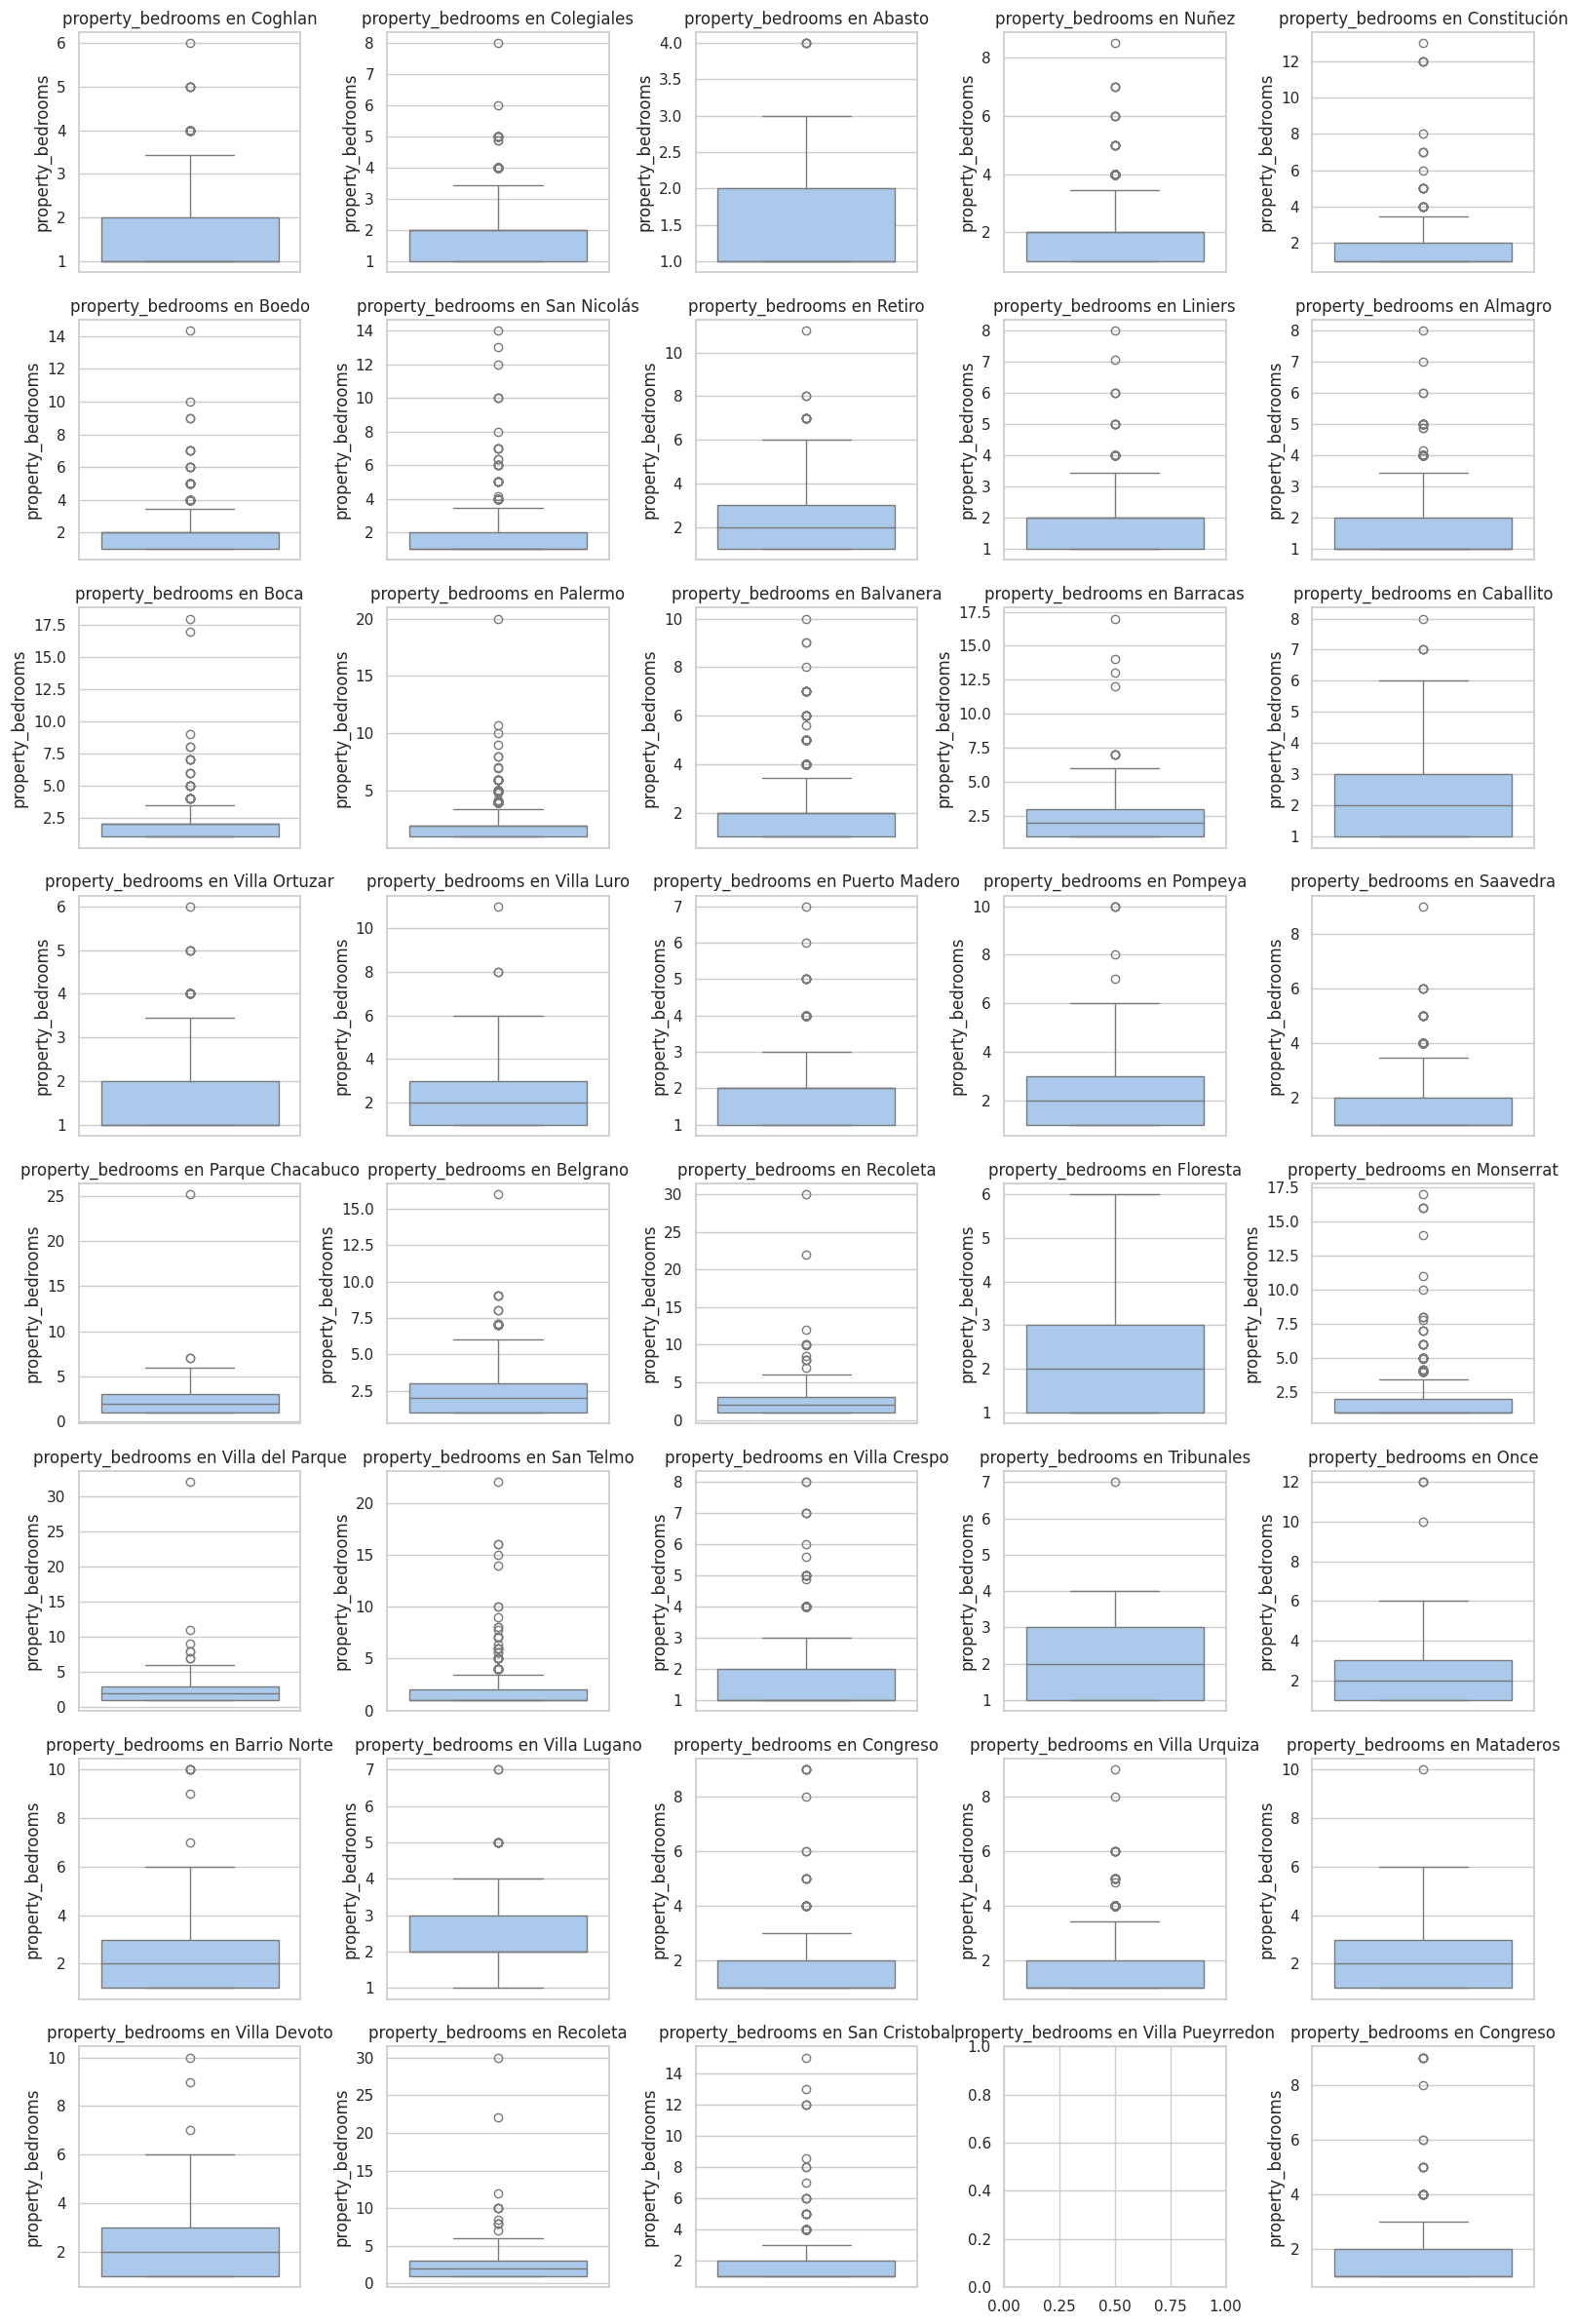

In [385]:
plot_por_barrio(ds_train, 'property_bedrooms')

Analizando los boxplot de la cantidad de habitaciones pero dividido según el barrio en el que se encuentra la propiedad, podemos ver aún teniendo en cuenta las variaciones, que aquellos casos de casas con más de 8 habitaciones son outliers extremos y decidimos normalizarlas utilizando una transformación logaritmica.

Nota: el limite intercuartil en general para la zona de CABA era 4, pero como vemos en barrios como Caballito esto se encuentra totalmente dentro de la norma.

In [386]:
ds_train.loc[ds_train['property_bedrooms'] > 7.0, 'property_bedrooms'] = np.log(ds_train['property_bedrooms'])

In [387]:
ds_train[ds_train['property_bedrooms'] > 6]

id  start_date    end_date created_on  \
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
338774  +OlRqaMH9p1Z9IPpkiPABg==  2021-06-01  2021-06-19 2021-06-01   
353761  T0kixYWXY/Anuassk+UQug==  2021-11-04  2022-01-27 2021-11-04   
342818  mqoxNDn8Gn/UkxbHPo7iOA==  2021-08-11  2021-09-01 2021-08-11   
...                          ...         ...         ...        ...   
115164  LRNvV58vN16ANMg0WmEEgw==  2021-12-07  2022-01-27 2021-12-07   
99383   WeWHPktY5rlQRW3bVp8lpQ==  2021-02-19  2021-04-16 2021-02-19   
72640   RBSIx9grSfooVB473NbCfA==  2021-05-29  2021-07-22 2021-05-29   
446881  FCKQIqoZzcZ7V9FAbGTc7g==  2021-05-22  2021-06-07 2021-05-22   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   

          latitud   longitud           place_l3 property_type  property_rooms  \
239181 -34.572554 -58.469842           Belgrano          Casa             8.0   
354636 -34.641514 -58.367007               Boca            PH            10.0   
338774 -34.562157 -58.464230           Belgrano          Casa             7.0   
353761 -34.646550 -58.464703  Parque Avellaneda          Casa            11.0   
342818 -34.616128 -58.394715          Balvanera          Casa             8.0   
...           ...        ...                ...           ...             ...   
115164 -34.639049 -58.423623          Caballito            PH            10.0   
99383  -34.599727 -58.372693        San Nicolás  Departamento             9.0   
72640  -34.602843 -58.386216        San Nicolás  Departamento             8.0   
446881 -34.629273 -58.418845              Boedo          Casa            12.0   
303903 -34.593316 -58.377201             Retiro  Departamento             9.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
239181           7.000000                   400.0                     400.0   
354636           7.000000                   123.0                     118.0   
338774           7.000000                   118.0                     118.0   
353761           7.000000                   897.0                     605.0   
342818           7.000000                   164.0                     143.0   
...                   ...                     ...                       ...   
115164           7.000000                   525.0                     430.0   
99383            6.338616                   213.0                     213.0   
72640            7.000000                   195.0                     190.0   
446881           7.000000                   500.0                     500.0   
303903           7.000000                   380.0                     350.0   

        property_price  
239181        920000.0  
354636        150000.0  
338774        175000.0  
353761        990000.0  
342818        230000.0  
...                ...  
115164        270000.0  
99383         268000.0  
72640         198000.0  
446881        450000.0  
303903        690000.0  

[89 rows x 13 columns]

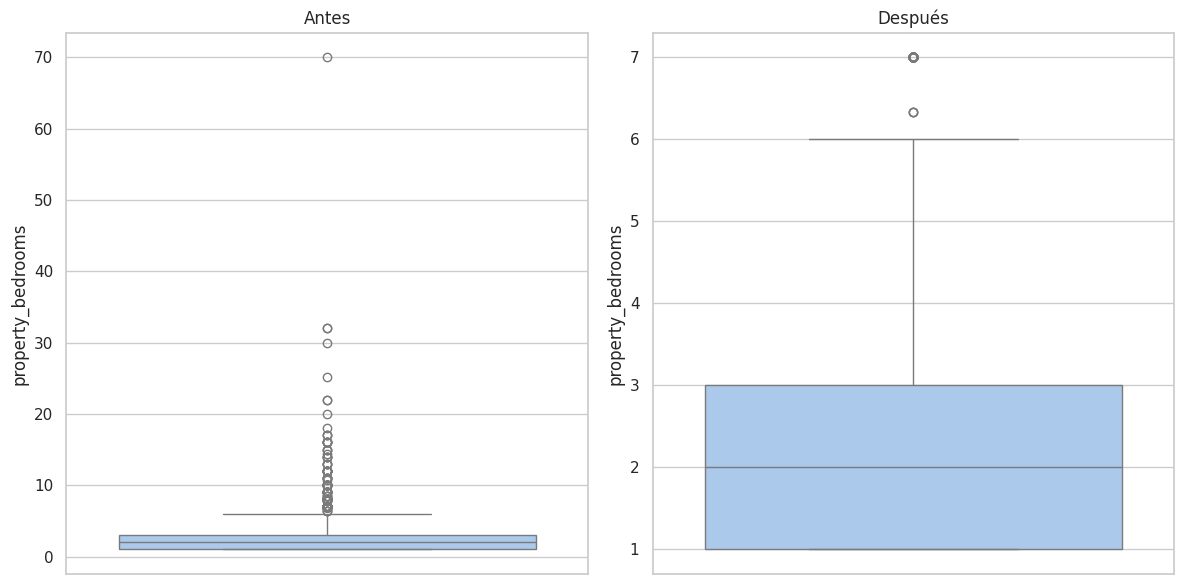

In [388]:
plot_comparativo(ds_atipicos, ds_train, 'property_bedrooms')

Podemos ver que se han solucionado la mayoría de las anomalías. Dejaremos las restantes (84 registros) para el análisis multivariado.

*Análisis según cantidad de ambientes (property_rooms)*

<Axes: ylabel='property_rooms'>

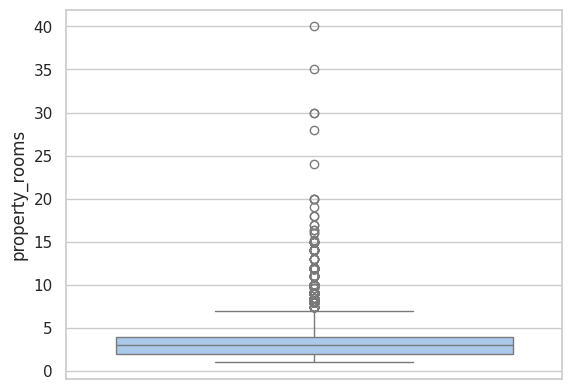

In [389]:
sns.boxplot(y=ds_train.property_rooms)

In [390]:
limite_rango_iq(ds_train, 'property_rooms')

(-1.0, 5.0)

El limite intercuartil superior es 5.0. Vemos que si bien hay muchos outliers por sobre el limite de 5 ambientes, esto se acentúa una vez que se superan los 20 ambientes.



In [391]:
# Observación anómala
outlier = ds_train[ds_train['property_rooms'] > 20]
outlier

id  start_date    end_date created_on  \
292167  CxZv3EmTnK+m6EJD2uQ5fw==  2021-02-23  2021-03-03 2021-02-23   
389282  +xTrflFUv4fEGjwpwhP68w==  2021-05-05  2021-06-05 2021-05-05   
21009   bmop3OsDu5kJmbAVgJ5wzA==  2021-03-15  2021-06-05 2021-03-15   
52157   HwHiC1DJIxRAjUAOmujXsg==  2021-02-07  2021-06-15 2021-02-07   
356618  +e6yeZZqYElYRYq4/cd9qg==  2021-11-18  2021-12-02 2021-11-18   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   

          latitud   longitud           place_l3 property_type  property_rooms  \
292167 -34.616487 -58.371596          San Telmo            PH            24.0   
389282 -34.570959 -58.458106           Belgrano          Casa            28.0   
21009  -34.616391 -58.456038          Caballito  Departamento            30.0   
52157  -34.649872 -58.483012  Parque Avellaneda            PH            30.0   
356618 -34.588742 -58.422459            Palermo  Departamento            40.0   
150885 -34.642037 -58.438995   Parque Chacabuco  Departamento            35.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
292167           3.091042                   800.0                     650.0   
389282           2.772589                   845.0                     845.0   
21009            2.000000                    79.0                      79.0   
52157            2.000000                    72.0                      60.0   
356618           3.000000                    75.0                      68.0   
150885           3.226504                    37.0                      33.0   

        property_price  
292167        350000.0  
389282        950000.0  
21009         230000.0  
52157         123500.0  
356618        145000.0  
150885         67000.0

Si bien los datos de habitaciones y ambientes no son posibles, por ahora no serán borrados ya que el resto (superficie cubierta, precio) parecen coherentes con el resto del dataset y pueden ser útiles.

Controlaremos según barrio.

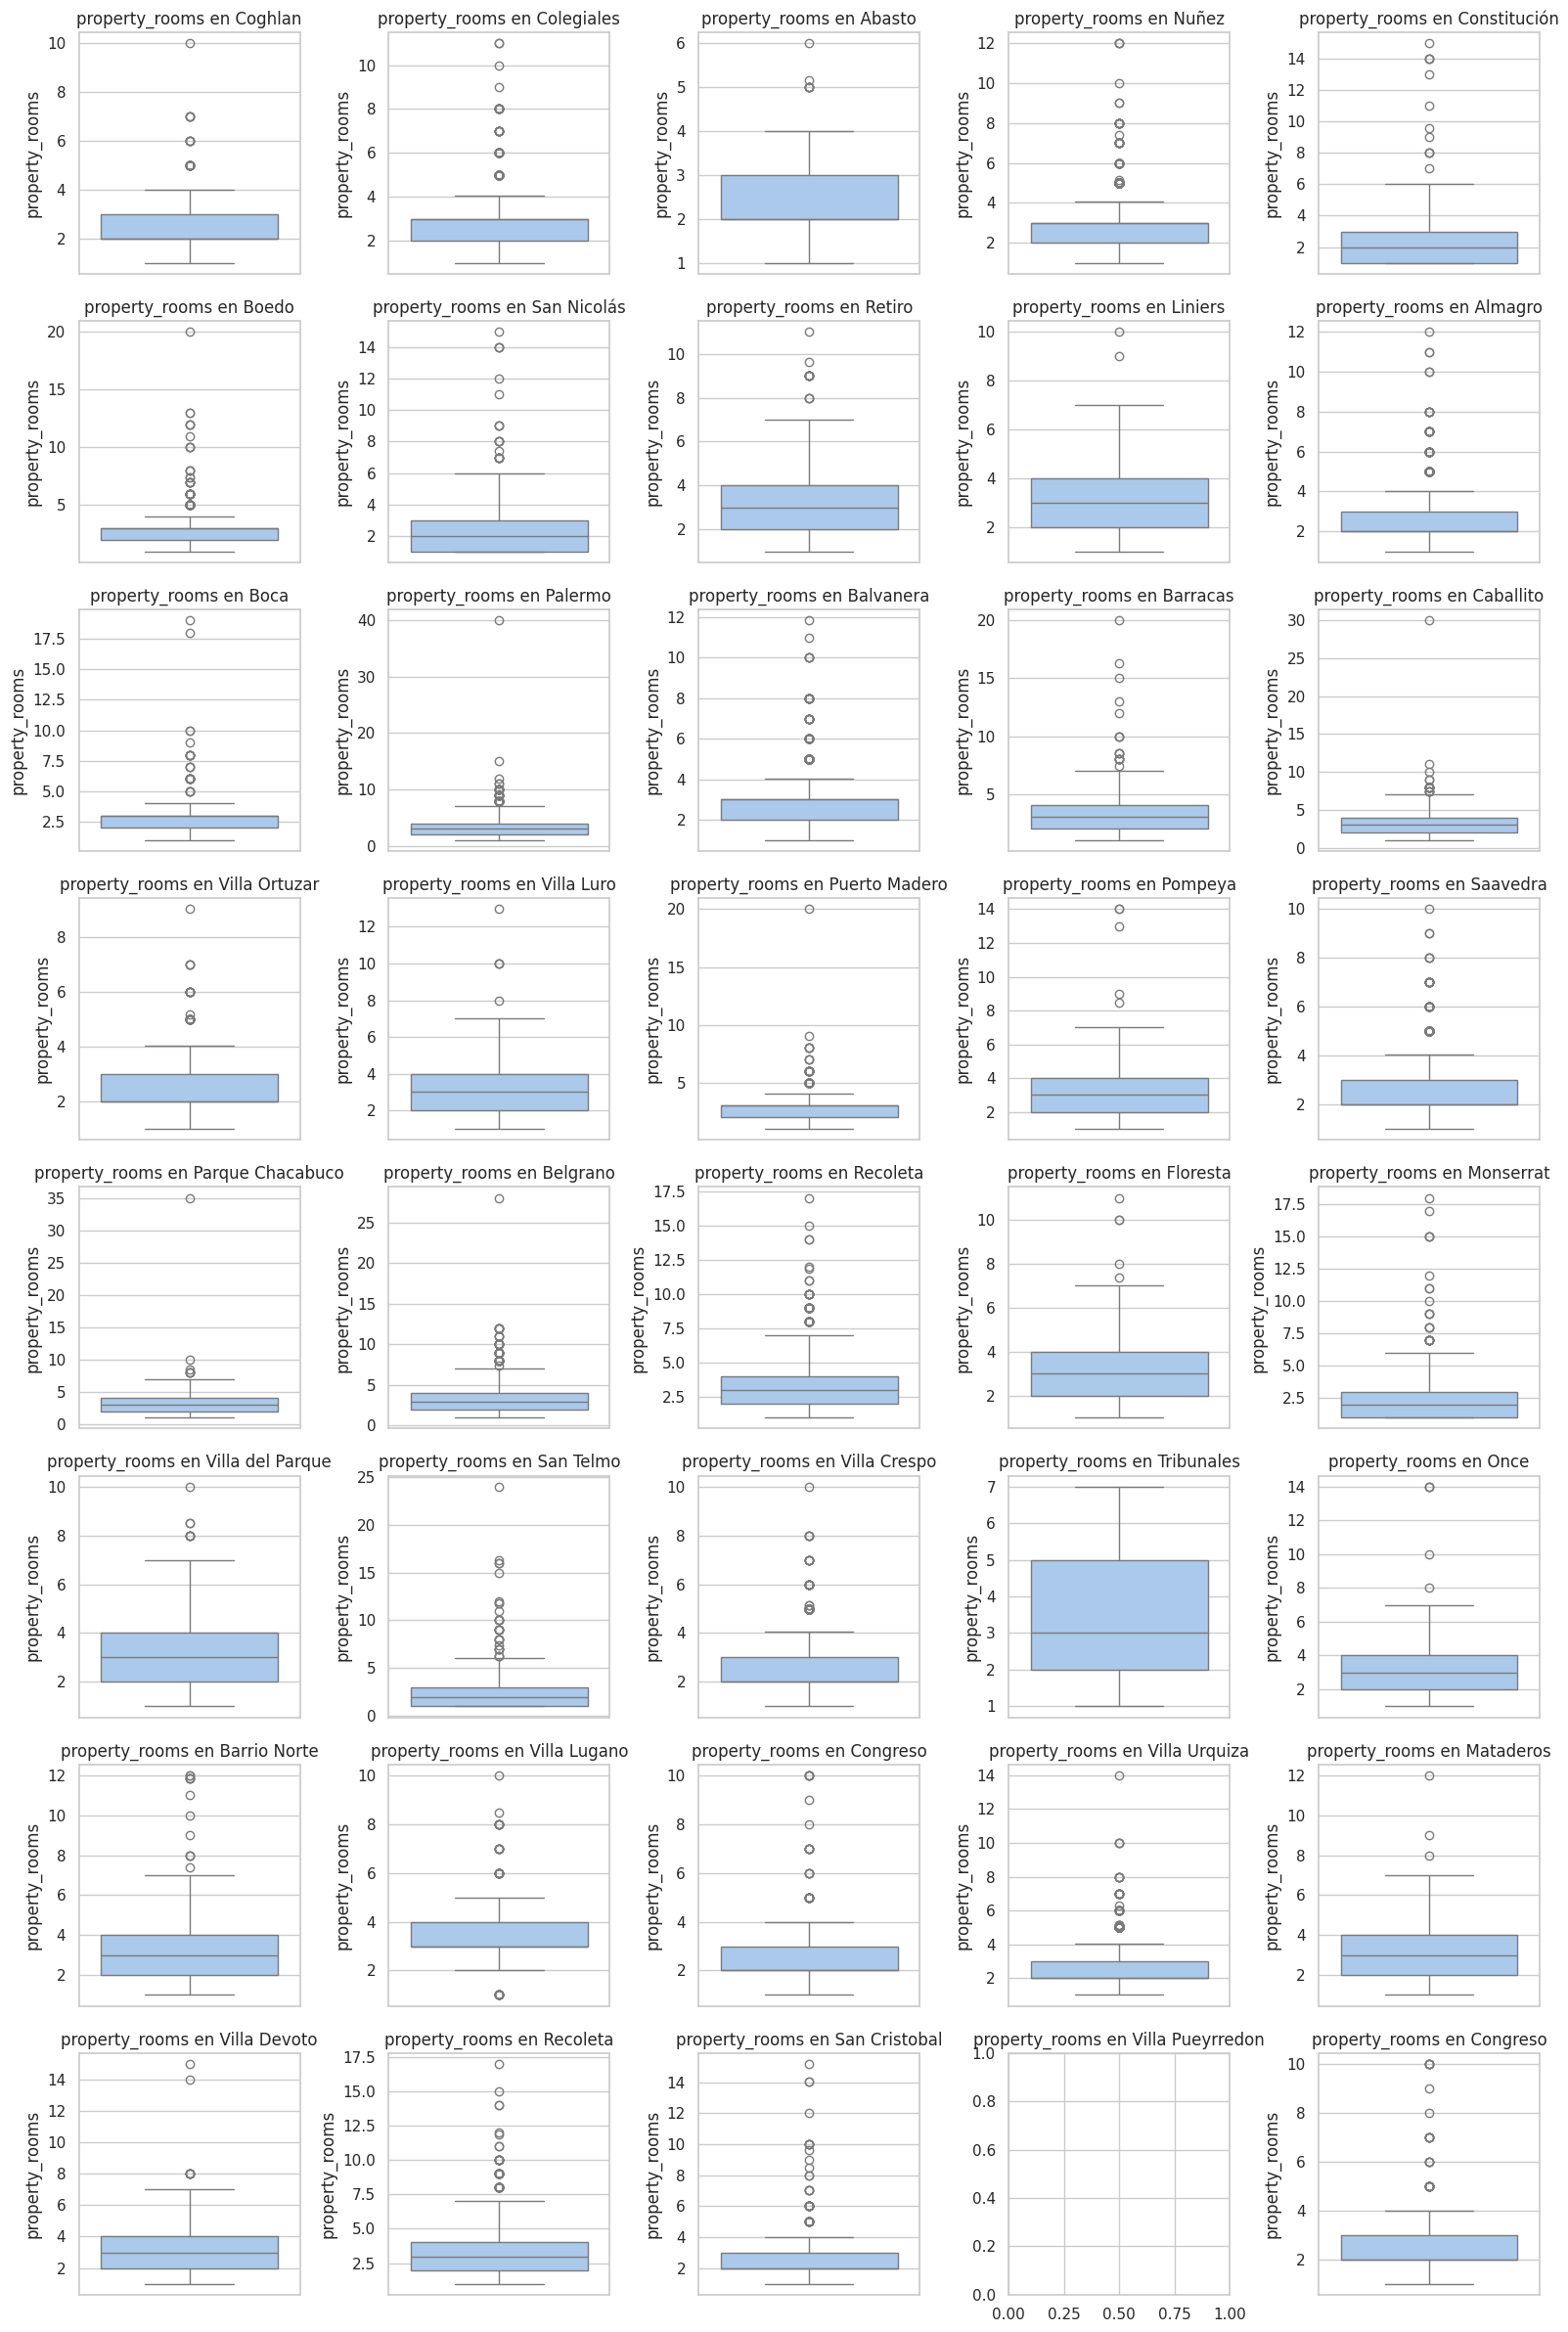

In [392]:
plot_por_barrio(ds_train, 'property_rooms')

Si bien nuestro límite intercuartil era de 5.0 vemos una tendencia un poco superior al ver los boxplot por barrio, así que realizaremos una corrección en aquellos registros atípicos que superen los 10 ambientes.

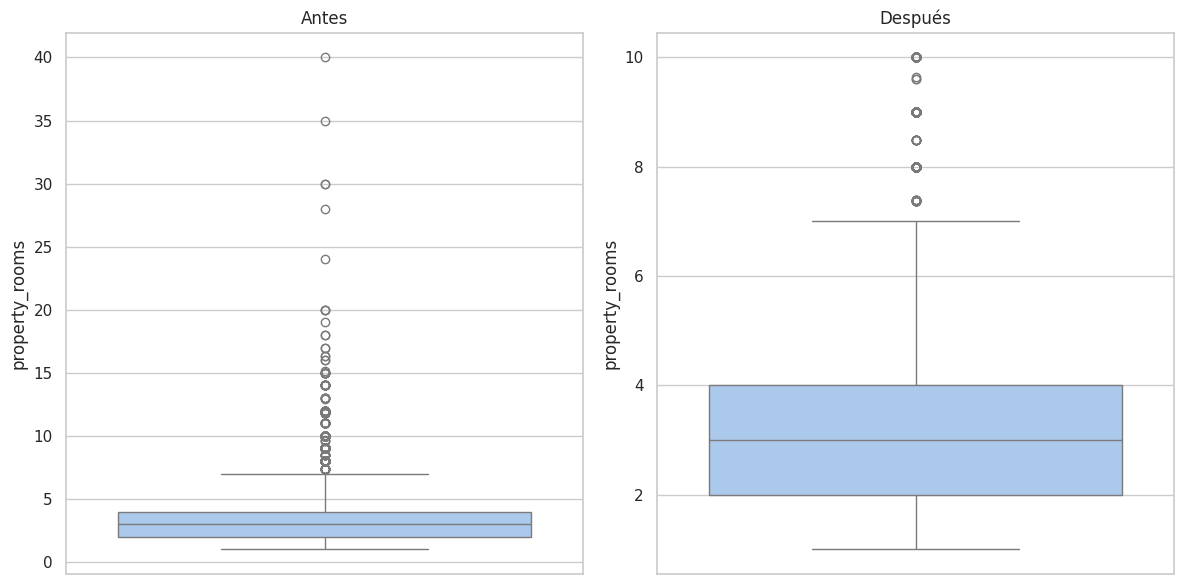

In [393]:
#Normalizacion logaritmica
ds_train.loc[ds_train['property_rooms'] > 10.0, 'property_rooms'] = np.log(ds_train['property_rooms'])

#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_rooms')

In [394]:
ds_train[(ds_train['property_rooms'] > 7.0)]

id  start_date    end_date created_on  \
7664    Cxh2q82VC5YE0myjvIOMvQ==  2021-02-09  2021-03-04 2021-02-09   
377896  VyPbKx1CD/VWSszsFFxN5A==  2021-03-16  2021-06-05 2021-03-16   
390841  toJNKApwEMOQh3InhxcXog==  2021-04-12  2021-06-05 2021-04-12   
249252  Kt0DWK1jRrfiPanKT3a6ig==  2021-04-29  2021-05-12 2021-04-29   
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
...                          ...         ...         ...        ...   
256995  pYfiVRZuXrvzOcmdidRzaQ==  2021-11-03  2022-01-27 2021-11-03   
231535  mKMlmVF118x9dfvdExBFdg==  2021-03-20  2021-03-28 2021-03-20   
351230  Wtwszya8Vq/u6Bj/1DIdLQ==  2021-04-16  2021-06-05 2021-04-16   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   
329630  VjyAHutPQVQq4ARXdkg69A==  2021-08-12  2021-09-03 2021-08-12   

          latitud   longitud          place_l3 property_type  property_rooms  \
7664   -34.590923 -58.384214          Recoleta  Departamento             9.0   
377896 -34.590995 -58.385289          Recoleta  Departamento             8.0   
390841 -34.594737 -58.379566            Retiro  Departamento             8.0   
249252 -34.635502 -58.502165        Villa Luro          Casa            10.0   
239181 -34.572554 -58.469842          Belgrano          Casa             8.0   
...           ...        ...               ...           ...             ...   
256995 -34.592883 -58.377896          Recoleta  Departamento             8.0   
231535 -34.620036 -58.526316        Villa Real            PH             9.0   
351230 -34.602622 -58.493423  Villa del Parque            PH            10.0   
303903 -34.593316 -58.377201            Retiro  Departamento             9.0   
329630 -34.572411 -58.420593           Palermo  Departamento             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
7664             4.000000               668.00000                     668.0   
377896           4.000000               282.00000                     267.0   
390841           4.000000               299.26885                     234.0   
249252           2.079442               232.00000                     152.0   
239181           7.000000               400.00000                     400.0   
...                   ...                     ...                       ...   
256995           4.000000               372.00000                     372.0   
231535           4.000000               202.00000                     150.0   
351230           2.197225               310.00000                     286.0   
303903           7.000000               380.00000                     350.0   
329630           4.000000               450.00000                     450.0   

        property_price  
7664         5000000.0  
377896        825000.0  
390841        490000.0  
249252        279000.0  
239181        920000.0  
...                ...  
256995        790000.0  
231535        159900.0  
351230        490000.0  
303903        690000.0  
329630       2600000.0  

[516 rows x 13 columns]

Tenemos 502 valores por sobre el máximo marcado por el bigote en el boxplot actual y que pueden ser considerados outliers. Reveeremos estos valores en otros análisis.

*Análisis según precio de la propiedad (property_price)*

<Axes: ylabel='property_price'>

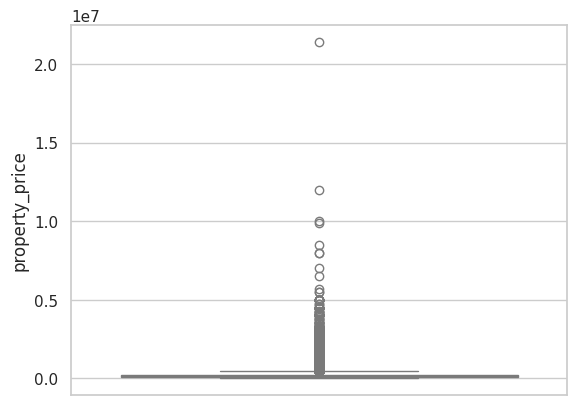

In [395]:
sns.boxplot(y=ds_train.property_price)

In [396]:
limite_rango_iq(ds_train, 'property_price')

(-115000.0, 305000.0)

Primero analizamos las anomalías más extremas, valores mayores o iguales a 8M.

In [397]:
# Observación anómala
outlier = ds_train[ds_train['property_price'] >= 8000000]
outlier

id  start_date    end_date created_on  \
85725   pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26   
248285  I3+CMvLB+tmeXtDg3XmSBA==  2021-09-13  2021-09-16 2021-09-13   
332190  PkbD1ixa/IWHlTjwozccRQ==  2021-09-17  2022-03-09 2021-09-17   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
156777  8ChrVZoOYyEqAJMIP/pXoQ==  2021-02-17  2021-02-19 2021-02-17   
148534  AExqjjuaRO2KtiPjC8BUiQ==  2021-05-12  2021-05-14 2021-05-12   
60073   uoM9HDKq3jZKQKgHXTIGkg==  2021-01-25  2022-05-13 2021-01-25   

          latitud   longitud     place_l3 property_type  property_rooms  \
85725  -34.572494 -58.462433     Belgrano          Casa        5.000000   
248285 -34.596801 -58.383768     Recoleta  Departamento        8.000000   
332190 -34.593634 -58.377164       Retiro          Casa        9.640813   
1140   -34.605781 -58.376705  San Nicolás  Departamento        3.556267   
156777 -34.608300 -58.371200    Monserrat          Casa        3.000000   
148534 -34.565947 -58.442326     Belgrano          Casa        9.000000   
60073  -34.616044 -58.458621    Caballito  Departamento        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
85725            4.000000                  3197.0                    3367.0   
248285           2.000000                   900.0                     150.0   
332190           2.079442                  1166.0                    1485.0   
1140             2.438251                 10500.0                   10500.0   
156777           2.000000                   225.0                      93.0   
148534           5.000000                  1763.0                    1763.0   
60073            1.987118                    68.0                      64.0   

        property_price  
85725       12000000.0  
248285       8000000.0  
332190      10000000.0  
1140         9900000.0  
156777       8500000.0  
148534       8000000.0  
60073       21400000.0

Buscando propiedades actualmente en venta en barrios y tamaños similares, parecería haber un error. Sin embargo, incluso haciendo un reducción de un decimo (valores más coherentes para esos varrios y tamaños de casas), estaríamos por sobre el límite intercuartil, asi que por ahora no haremos transformaciones.

Analicemos según barrio:

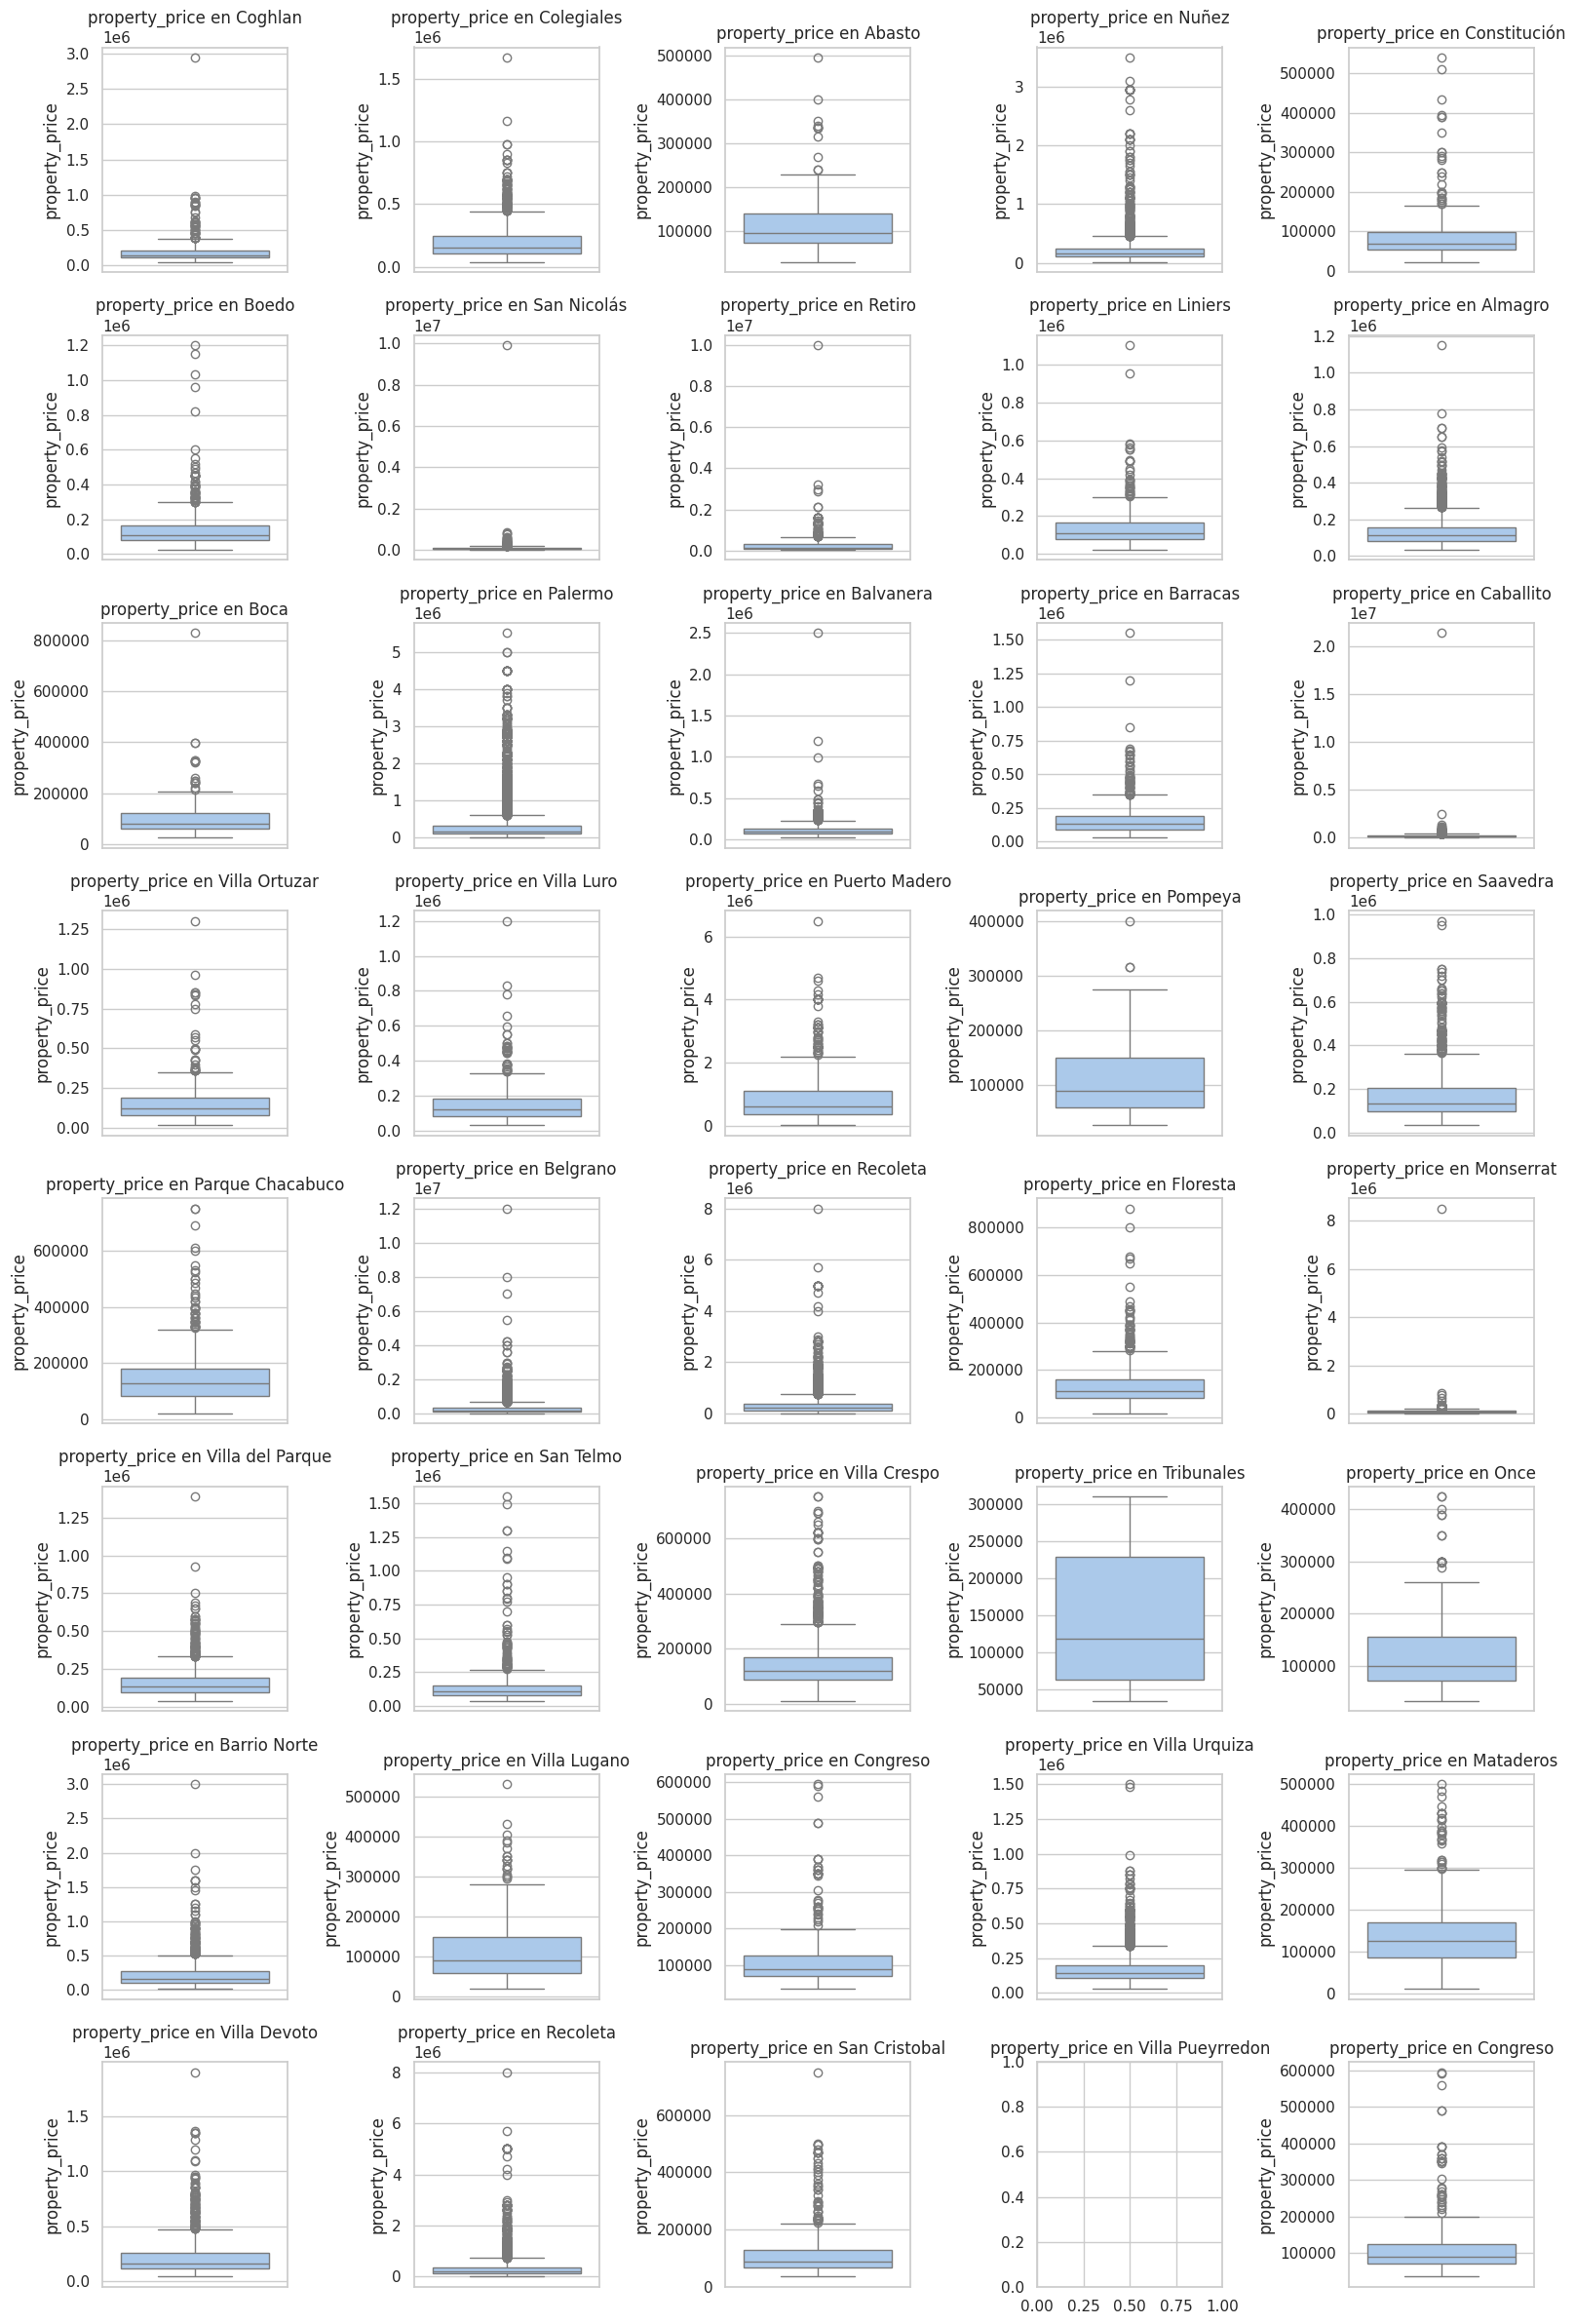

In [398]:
plot_por_barrio(ds_train, 'property_price')

Hasta el momento, este el analisis según barrio menos homogéneo. Si tomamos el limite superior intercuartil general (305m), se distorcionarían totalmente los datos de barrios como Palermo y Puerto Madero. Teniendo en cuenta lo relevante que es éste dato a la hora de que se establezca el precio de una propiedad, solo trabajaremos con los outliers que sean extremos en el contexto de cada barrio (analisis multivariado).

*Análisis según superficie cubierta (property_surface_covered)*

<Axes: ylabel='property_surface_covered'>

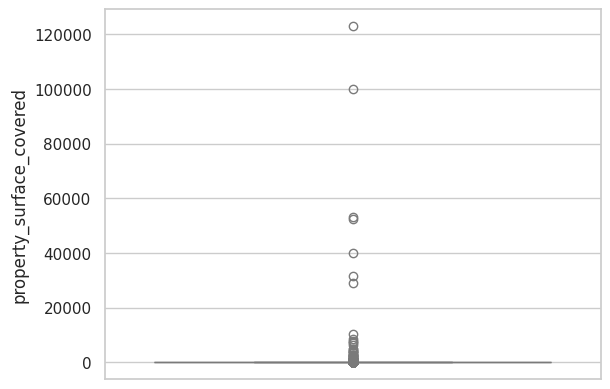

In [399]:
sns.boxplot(y=ds_train.property_surface_covered)

In [400]:
limite_rango_iq(ds_train, 'property_surface_covered')

(-32.0, 112.0)

In [401]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_covered'] <= 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [402]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_covered'].idxmin()
ds_train.loc[min_surface_index]

id                          NWN70rV/q2EBRj8mtV3Wxg==
start_date                                2021-01-12
end_date                                  2021-03-10
created_on                       2021-01-12 00:00:00
latitud                                   -34.570428
longitud                                  -58.477361
place_l3                               Villa Urquiza
property_type                                     PH
property_rooms                                   3.0
property_bedrooms                                2.0
property_surface_total                      24.42903
property_surface_covered                         1.0
property_price                              215000.0
Name: 41944, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [403]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
41944   NWN70rV/q2EBRj8mtV3Wxg==  2021-01-12  2021-03-10 2021-01-12   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
390248  6Gbfz2DtwYbdNMTk+C7wnw==  2021-05-05  2021-05-28 2021-05-05   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
...                          ...         ...         ...        ...   
189935  2OkFM1IVzd4mP500C4IeDw==  2021-06-04  2021-10-30 2021-06-04   
301212  /MNEruoihGzhMaUMEfP6TQ==  2021-08-10  2021-11-03 2021-08-10   
36467   CHlKVkRxO4yj7SuG1Rz1Sw==  2021-09-21  2021-10-28 2021-09-21   
247142  tKHkWjeUQhi1HBEgvRiCgA==  2021-10-08  2022-02-09 2021-10-08   
410186  u2sRiGL522AcO7BWzrA4Nw==  2021-03-19  2021-06-05 2021-03-19   

          latitud   longitud          place_l3 property_type  property_rooms  \
41944  -34.570428 -58.477361     Villa Urquiza            PH        3.000000   
168082 -34.606525 -58.430740         Caballito  Departamento        2.769911   
390248 -34.579943 -58.452158        Colegiales  Departamento        2.000000   
86014  -34.591110 -58.400685          Recoleta  Departamento        4.000000   
7869   -34.680073 -58.451069      Villa Lugano  Departamento        2.000000   
...           ...        ...               ...           ...             ...   
189935 -34.610109 -58.450791         Caballito  Departamento        1.000000   
301212 -34.680927 -58.475828      Villa Lugano            PH        3.000000   
36467  -34.582148 -58.427791           Palermo  Departamento        2.000000   
247142 -34.624284 -58.401358     San Cristobal  Departamento        3.000000   
410186 -34.633402 -58.445774  Parque Chacabuco  Departamento        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
41944            2.000000               24.429030                       1.0   
168082           1.820015               12.000000                      12.0   
390248           1.000000               41.000000                       3.0   
86014            3.401197              148.000000                      13.8   
7869             1.000000               11.096837                       1.0   
...                   ...                     ...                       ...   
189935           1.000000               39.000000                       5.0   
301212           2.000000              132.000000                      14.0   
36467            1.000000               50.000000                       5.0   
247142           2.000000               60.000000                       3.0   
410186           2.000000               28.542133                       5.0   

        property_price  
41944         215000.0  
168082         22000.0  
390248        114000.0  
86014         380000.0  
7869           35000.0  
...                ...  
189935         90000.0  
301212        180000.0  
36467         155000.0  
247142        109000.0  
410186        210000.0  

[66 rows x 13 columns]

Tenemos 147 registros de propiedades que tienen menos de 15m^2 cubiertos, y si bien según código urbanistico de la Ciudad de Buenos Aires no permite departamentos tan pequeños, sabemos que eso puede infringirse. Bajo estos supuestos, y viendo los registros que aparecen, vamos a reemplazar aquellos con superficies demasiado pequeñas (menores a 10m^2) por la superficie total.

In [404]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_covered'] = ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_total']

In [405]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
19478   J0/gRyRPvFY0WmEU0nY1Fw==  2021-01-27  2021-08-17 2021-01-27   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
104165  03zgVf+Yn3GtIEVJOn9I8g==  2021-05-28  2021-06-13 2021-05-28   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
301212  /MNEruoihGzhMaUMEfP6TQ==  2021-08-10  2021-11-03 2021-08-10   

          latitud   longitud          place_l3 property_type  property_rooms  \
168082 -34.606525 -58.430740         Caballito  Departamento        2.769911   
86014  -34.591110 -58.400685          Recoleta  Departamento        4.000000   
7869   -34.680073 -58.451069      Villa Lugano  Departamento        2.000000   
299    -34.597934 -58.376981            Retiro  Departamento        1.000000   
408338 -34.637323 -58.476409          Floresta  Departamento        1.000000   
268998 -34.554519 -58.491599          Saavedra  Departamento        2.000000   
326305 -34.606251 -58.384552       San Nicolás  Departamento        1.000000   
168108 -34.606525 -58.430740         Caballito  Departamento        2.769911   
41866  -34.611753 -58.516570      Villa Devoto  Departamento        1.000000   
41903  -34.579301 -58.465854     Villa Ortuzar  Departamento        1.000000   
72233  -34.597934 -58.376981            Retiro  Departamento        1.000000   
333830 -34.600456 -58.376960            Retiro  Departamento        1.000000   
227332 -34.633430 -58.480731          Floresta            PH        2.000000   
225485 -34.597825 -58.376983            Retiro  Departamento        1.000000   
42084  -34.583818 -58.495458  Villa Pueyrredón  Departamento        1.000000   
36421  -34.576061 -58.421289           Palermo  Departamento        3.000000   
178234 -34.609567 -58.384745         Monserrat  Departamento        1.000000   
216786 -34.621967 -58.372598         San Telmo  Departamento        1.000000   
140832 -34.588454 -58.385257          Recoleta  Departamento        5.000000   
19478  -34.602170 -58.412383            Abasto  Departamento        2.000000   
50425  -34.644446 -58.418263           Pompeya  Departamento        1.000000   
104165 -34.643724 -58.418383  Parque Patricios  Departamento        1.000000   
168064 -34.606525 -58.430740         Caballito  Departamento        2.769911   
38433  -34.600832 -58.390383        Tribunales  Departamento        1.000000   
301212 -34.680927 -58.475828      Villa Lugano            PH        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
168082           1.8200

Ahora nos quedan 84 outliers.

In [406]:
ds_train[ds_train['property_surface_covered'] > 15000]

id  start_date    end_date created_on  \
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   

          latitud   longitud       place_l3 property_type  property_rooms  \
72521  -34.600113 -58.403649      Balvanera  Departamento             2.0   
372779 -34.555278 -58.459786       Belgrano  Departamento             4.0   
72316  -34.578917 -58.429373        Palermo  Departamento             2.0   
117835 -34.550093 -58.483034       Saavedra  Departamento             2.0   
106598 -34.587320 -58.401556   Barrio Norte  Departamento             2.0   
405324 -34.569963 -58.481658  Villa Urquiza            PH             4.0   
352883 -34.550093 -58.483034       Saavedra  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
72521                 1.0                 33800.0                   31670.0   
372779                3.0                100068.0                  100051.0   
72316                 1.0                 61130.0                   53030.0   
117835                1.0                 43086.0                   40038.0   
106598                1.0                 56740.0                   52540.0   
405324                3.0                123000.0                  123000.0   
352883                1.0                 29064.0                   29064.0   

        property_price  
72521          66000.0  
372779        420000.0  
72316         225000.0  
117835        114000.0  
106598        175000.0  
405324        165000.0  
352883         87400.0

Los casos de propiedades con superficie cubierta mayor a 15000, parecen ser errores de escala que pueden solucionarse facilmente.

In [407]:
condition = ds_train['property_surface_covered'] > 15000
ds_train.loc[condition, 'property_surface_covered'] /= 1000

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 15000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [408]:
ds_train[ds_train['property_surface_covered'] > 4000]

id  start_date    end_date created_on  \
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
233699  McdySYNyXo2s4UZ2wypUig==  2021-03-20  2022-03-25 2021-03-20   
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
314541  /lzClyxH96pdJl/JI2ofKg==  2021-01-06  2021-01-09 2021-01-06   
94789   jXPtdq0ibrnXyePLhTi27g==  2021-09-24  2021-09-26 2021-09-24   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
398069  Z41Yr6x3GUjyoxu+Afv4og==  2021-02-13  2021-03-18 2021-02-13   

          latitud   longitud      place_l3 property_type  property_rooms  \
313745 -34.649174 -58.413106       Pompeya            PH        6.000000   
233699 -34.606260 -58.452737  Villa Crespo  Departamento        2.000000   
459841 -34.627876 -58.437996     Caballito  Departamento        3.000000   
314541 -34.555086 -58.459669      Belgrano  Departamento        1.000000   
94789  -34.614279 -58.361092     Caballito  Departamento        2.000000   
1140   -34.605781 -58.376705   San Nicolás  Departamento        3.556267   
405272 -34.634638 -58.473519      Floresta            PH        4.000000   
459842 -34.628397 -58.437706     Caballito  Departamento        3.000000   
459847 -34.628247 -58.437696     Caballito  Departamento        4.000000   
398069 -34.558309 -58.459923      Belgrano  Departamento        2.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
313745           2.000000                  8988.0                    7454.0   
233699           1.000000                  4224.0                    4224.0   
459841           2.000000                  7153.0                    7153.0   
314541           1.000000                  5741.0                    4276.0   
94789            1.000000                  5312.0                    4809.0   
1140             2.438251                 10500.0                   10500.0   
405272           3.000000                  8306.0                    7755.0   
459842           2.000000                  8136.0                    6472.0   
459847           3.000000                 18096.0                    8568.0   
398069           1.000000                  6470.0                    4664.0   

        property_price  
313745        125000.0  
233699        100000.0  
459841        177807.0  
314541         85144.0  
94789         145000.0  
1140         9900000.0  
405272        129000.0  
459842        203550.0  
459847        324558.0  
398069        149900.0

Mismo que con las propiedades con superficie cubierta mayor a 5000, parece ser un problema de escala.

In [409]:
condition = ds_train['property_surface_covered'] > 4000
ds_train.loc[condition, 'property_surface_covered'] /= 100

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 4000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [410]:
ds_train[ds_train['property_surface_covered'] > 1100]

id  start_date    end_date created_on  \
85725   pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26   
177181  q6PytfvCIgQ9xOWk3o+m1A==  2021-03-23  2021-06-05 2021-03-23   
264972  d99ugnqvWTu/psmVhGYVGw==  2021-11-19  2022-01-27 2021-11-19   
177140  KVFit7mVm+epRM497KAchw==  2021-03-23  2021-06-05 2021-03-23   
354376  oSruKb4+uOYztGpv3h5FKA==  2021-11-04  2022-01-27 2021-11-04   
332190  PkbD1ixa/IWHlTjwozccRQ==  2021-09-17  2022-03-09 2021-09-17   
148534  AExqjjuaRO2KtiPjC8BUiQ==  2021-05-12  2021-05-14 2021-05-12   
438160  mzH1lMHi7l9z9MTU0eMRVg==  2021-10-27  2022-01-04 2021-10-27   
409283  mpNfyaVZmVoa5okuzXnf+w==  2021-03-19  2021-06-05 2021-03-19   
293109  tB9+CF2yPvyRqYvdI5wVqg==  2021-02-23  2021-06-25 2021-02-23   
104177  rGOjA8tJXYsGapcTNwIKQA==  2021-05-28  2021-06-13 2021-05-28   
263173  YBglCjqyN6JqZ19HsNlLcQ==  2021-02-26  2021-03-27 2021-02-26   
165965  NzYulXk9Ddrc+qQoqAAGRw==  2021-04-30  2021-06-05 2021-04-30   

          latitud   longitud          place_l3 property_type  property_rooms  \
85725  -34.572494 -58.462433          Belgrano          Casa        5.000000   
177181 -34.626697 -58.373873         San Telmo          Casa        2.793818   
264972 -34.613827 -58.373096         San Telmo          Casa        2.912530   
177140 -34.627279 -58.373637          Barracas          Casa        2.793818   
354376 -34.579394 -58.453519        Colegiales  Departamento        3.000000   
332190 -34.593634 -58.377164            Retiro          Casa        9.640813   
148534 -34.565947 -58.442326          Belgrano          Casa        9.000000   
438160 -34.630704 -58.400901  Parque Patricios  Departamento        1.000000   
409283 -34.599678 -58.436474           Palermo  Departamento        2.875278   
293109 -34.603310 -58.419520           Almagro  Departamento        3.000000   
104177 -34.603992 -58.500042  Villa del Parque  Departamento        1.000000   
263173 -34.557749 -58.471384          Belgrano          Casa        8.000000   
165965 -34.557754 -58.471497           Coghlan          Casa        2.938908   

        property_bedrooms  property_surface_total  property_surface_covered  \
85725            4.000000             3197.000000               3367.000000   
177181           2.639057             2500.000000               2500.000000   
264972           1.932507             1993.000000               1900.000000   
177140           2.639057             2500.000000               2500.000000   
354376           2.000000               41.000000               3837.000000   
332190           2.079442             1166.000000               1485.000000   
148534           5.000000             1763.000000               1763.000000   
438160           1.000000               31.000000               2700.000000   
409283           1.903442             1545.027475               1481.000000   
293109           2.000000             5239.000000               2477.731988   
104177           1.000000             3623.000000               3615.000000   
263173           2.079442             2204.000000               2204.000000   
165965           1.952881             2266.000000               2266.000000   

        property_price  
85725       12000000.0  
177181       1550000.0  
264972       1150000.0  
177140       1550000.0  
354376         83000.0  
332190      10000000.0  
148534       8000000.0  
438160         71500.0  
409283       2800000.0  
293109        119000.0  
104177        110000.0  
263173       1400000.0  
165965       2950000.0

Entre las anomalías que persisten parecería haber un caso de error de escala. A su vez, en los casos donde las habitaciones son regulares (<=5.0) haremos una corrección logaritmica.

In [411]:
# Corección de error de tipeo/escala
ds_train.loc[ds_train['id'] == 'mzH1lMHi7l9z9MTU0eMRVg==', 'property_surface_covered'] /= 100
# Corrección logaritmica
ds_train.loc[(ds_train['property_bedrooms'] <= 5.0) & (ds_train['property_surface_covered'] > 1100), 'property_surface_covered'] = np.log(ds_train['property_surface_covered'])



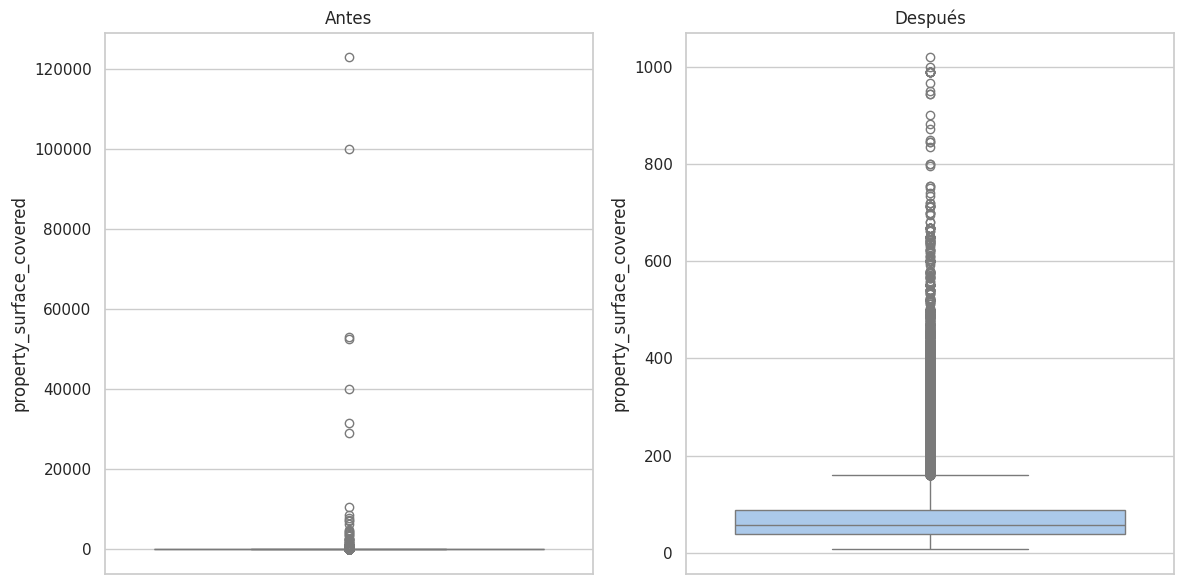

In [412]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_covered')

*Análisis según superficie total (property_surface_total)*



<Axes: ylabel='property_surface_total'>

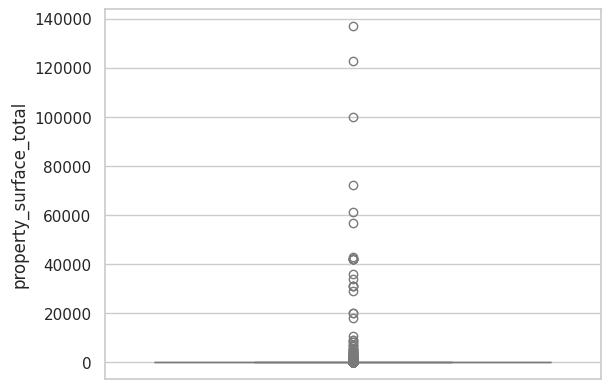

In [413]:
sns.boxplot(y=ds_train.property_surface_total)

In [414]:
limite_rango_iq(ds_train, 'property_surface_total')

(-45.0, 135.0)

In [415]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_total'] < 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [416]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_total'].idxmin()
ds_train.loc[min_surface_index]

id                          s4UQHlmed73o08wupnf2pg==
start_date                                2021-08-27
end_date                                  9999-12-31
created_on                       2021-08-27 00:00:00
latitud                                   -34.606251
longitud                                  -58.384552
place_l3                                 San Nicolás
property_type                           Departamento
property_rooms                                   1.0
property_bedrooms                                1.0
property_surface_total                      8.234446
property_surface_covered                    8.234446
property_price                               40548.0
Name: 326305, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [417]:
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
32068   4jwFTdGy7N11fF14hLplcw==  2021-05-17  2021-06-05 2021-05-17   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
41088   ngtAPqtsUhn8Y9+r/FgteA==  2021-07-19  9999-12-31 2021-07-19   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
168118  gsbwHqWC2NW1ywgCJd0xaQ==  2021-04-30  2021-06-03 2021-04-30   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
21153   us/N38vEYZarzdFzep5a9A==  2021-03-15  2021-03-25 2021-03-15   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
41192   jLK6eCdVrULnEhLxS2kgUg==  2021-01-12  2021-02-05 2021-01-12   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
190609  /MC0i98hQuKwdP9/I6NdRg==  2021-10-09  2022-01-27 2021-10-09   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
104165  03zgVf+Yn3GtIEVJOn9I8g==  2021-05-28  2021-06-13 2021-05-28   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
154950  /4B1aoAn2OzWObpjXevrmg==  2021-02-03  2022-09-01 2021-02-03   
180380  i16eZUm9vHNMrQMT82+9hQ==  2021-02-16  2021-12-09 2021-02-16   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   

          latitud   longitud          place_l3 property_type  property_rooms  \
32068  -34.571979 -58.446945          Belgrano  Departamento        3.000000   
168082 -34.606525 -58.430740         Caballito  Departamento        2.769911   
41088  -34.614573 -58.480650  Villa del Parque  Departamento        2.000000   
7869   -34.680073 -58.451069      Villa Lugano  Departamento        2.000000   
168118 -34.606525 -58.430740         Caballito  Departamento        2.773312   
299    -34.597934 -58.376981            Retiro  Departamento        1.000000   
21153  -34.633819 -58.504568        Villa Luro  Departamento        3.000000   
408338 -34.637323 -58.476409          Floresta  Departamento        1.000000   
268998 -34.554519 -58.491599          Saavedra  Departamento        2.000000   
326305 -34.606251 -58.384552       San Nicolás  Departamento        1.000000   
168108 -34.606525 -58.430740         Caballito  Departamento        2.769911   
41866  -34.611753 -58.516570      Villa Devoto  Departamento        1.000000   
41903  -34.579301 -58.465854     Villa Ortuzar  Departamento        1.000000   
72233  -34.597934 -58.376981            Retiro  Departamento        1.000000   
333830 -34.600456 -58.376960            Retiro  Departamento        1.000000   
227332 -34.633430 -58.480731          Floresta            PH        2.000000   
225485 -34.597825 -58.376983            Retiro  Departamento        1.000000   
42084  -34.583818 -58.495458  Villa Pueyrredón  Departamento        1.000000   
178234 -34.609567 -58.384745         Monserrat  Departamento        1.000000   
41192  -34.635506 -58.417926             Boedo            PH        4.000000   
216786 -34.621967 -58.372598         San Telmo  Departamento        1.000000   
190609 -34.568710 -58.473026          Saavedra  Departamento        1.000000   
50425  -34.644446 -58.418263           Pompeya  Departamento        1.000000   
104165 -34.643724 -58.418383  Parque Patricios  De

Por las razones ya expuestas y teniendo en cuenta que son todos departamentos, decidimos reemplazar los datos de superficie total por los de superficie cubierta.

In [418]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_total'] = ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_covered']

In [419]:
# Revisamos y solo quedan aquellos casos donde la superficie cubierta también era menor a 15.
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
104165  03zgVf+Yn3GtIEVJOn9I8g==  2021-05-28  2021-06-13 2021-05-28   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   

          latitud   longitud          place_l3 property_type  property_rooms  \
168082 -34.606525 -58.430740         Caballito  Departamento        2.769911   
7869   -34.680073 -58.451069      Villa Lugano  Departamento        2.000000   
299    -34.597934 -58.376981            Retiro  Departamento        1.000000   
408338 -34.637323 -58.476409          Floresta  Departamento        1.000000   
268998 -34.554519 -58.491599          Saavedra  Departamento        2.000000   
326305 -34.606251 -58.384552       San Nicolás  Departamento        1.000000   
168108 -34.606525 -58.430740         Caballito  Departamento        2.769911   
41866  -34.611753 -58.516570      Villa Devoto  Departamento        1.000000   
41903  -34.579301 -58.465854     Villa Ortuzar  Departamento        1.000000   
72233  -34.597934 -58.376981            Retiro  Departamento        1.000000   
333830 -34.600456 -58.376960            Retiro  Departamento        1.000000   
227332 -34.633430 -58.480731          Floresta            PH        2.000000   
225485 -34.597825 -58.376983            Retiro  Departamento        1.000000   
42084  -34.583818 -58.495458  Villa Pueyrredón  Departamento        1.000000   
178234 -34.609567 -58.384745         Monserrat  Departamento        1.000000   
216786 -34.621967 -58.372598         San Telmo  Departamento        1.000000   
50425  -34.644446 -58.418263           Pompeya  Departamento        1.000000   
104165 -34.643724 -58.418383  Parque Patricios  Departamento        1.000000   
168064 -34.606525 -58.430740         Caballito  Departamento        2.769911   
38433  -34.600832 -58.390383        Tribunales  Departamento        1.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
168082           1.820015               12.000000                 12.000000   
7869             1.000000               11.096837                 11.096837   
299              1.000000               14.000000                 14.000000   
408338           1.000000               11.319273                 11.319273   
268998           1.000000               12.125113                 12.125113   
326305           1.000000                8.234446                  8.234446   
168108           1.820015               12.000000                 12.000000   
41866            1.000000                8.234446                  8.234446   
41903            1.000000                8.234446                  8.234446   
72233            1.000000               14.000000                 1

In [420]:
ds_train[ds_train['property_surface_total'] > 100000]

id  start_date    end_date created_on  \
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
129214  tJ7TjXeyIl+4KPkaPqyAYA==  2021-07-01  9999-12-31 2021-07-01   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   

          latitud   longitud       place_l3 property_type  property_rooms  \
372779 -34.555278 -58.459786       Belgrano  Departamento             4.0   
129214 -34.599421 -58.386867   Barrio Norte  Departamento             5.0   
405324 -34.569963 -58.481658  Villa Urquiza            PH             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
372779                3.0                100068.0                   100.051   
129214                3.0                137000.0                   135.000   
405324                3.0                123000.0                   123.000   

        property_price  
372779        420000.0  
129214        390000.0  
405324        165000.0

En el caso de la propiedad de Parque Chacabuco, ninguno de los datos tiene coherencia al mirarlos en conjunto: una casa de 22.75 ambientes, y 17.23 habitaciones, con una superficie cubierta de 217.0 y total de 177198m^2. Tendriamos que imputar todos estos datos lo cual no tendría sentido, nos quedariamos con poco material real.

En los otros dos casos, parece ser más un error de escala asi que lo normalizamos.

In [421]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_surface_total'] > 170000].index
ds_train.drop(id_outlier,inplace=True)

<ipython-input-421-5a202d8d3887>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [422]:
# Modificamos los otros
condition = ds_train['property_surface_total'] > 100000
ds_train.loc[condition, 'property_surface_total'] /= 1000

ds_train[ds_train['property_surface_total'] > 100000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [423]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
370918  rnFgWleVdid1Czn05PkodA==  2021-04-24  2021-06-05 2021-04-24   
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
263945  xTMT4WGUrto9Ee8CBjxUxw==  2021-02-26  2021-02-28 2021-02-26   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
126869  MYZD6oNPlLhMzVLoEbL9jw==  2021-10-05  2021-11-04 2021-10-05   
237392  wGXDCrWhpDX+JQBrC+7jpA==  2021-02-27  2021-03-03 2021-02-27   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   

          latitud   longitud      place_l3 property_type  property_rooms  \
72521  -34.600113 -58.403649     Balvanera  Departamento        2.000000   
370918 -34.571747 -58.422612       Palermo  Departamento        4.000000   
313745 -34.649174 -58.413106       Pompeya            PH        6.000000   
370922 -34.571747 -58.422612       Palermo  Departamento        5.000000   
459841 -34.627876 -58.437996     Caballito  Departamento        3.000000   
370917 -34.571747 -58.422612       Palermo  Departamento        4.000000   
84073  -34.588175 -58.396261      Recoleta  Departamento        1.000000   
219021 -34.636532 -58.376406      Barracas  Departamento        4.000000   
275253 -34.579163 -58.455725    Colegiales  Departamento        1.000000   
300394 -34.579163 -58.455725    Colegiales  Departamento        1.000000   
370932 -34.571747 -58.422612       Palermo  Departamento        4.000000   
324541 -34.628721 -58.421383         Boedo            PH        4.000000   
72316  -34.578917 -58.429373       Palermo  Departamento        2.000000   
1140   -34.605781 -58.376705   San Nicolás  Departamento        3.556267   
370919 -34.571747 -58.422612       Palermo  Departamento        5.000000   
405272 -34.634638 -58.473519      Floresta            PH        4.000000   
117835 -34.550093 -58.483034      Saavedra  Departamento        2.000000   
106598 -34.587320 -58.401556  Barrio Norte  Departamento        2.000000   
263945 -34.576096 -58.441278       Palermo  Departamento        3.000000   
459842 -34.628397 -58.437706     Caballito  Departamento        3.000000   
126869 -34.579163 -58.455725    Colegiales  Departamento        1.000000   
237392 -34.628721 -58.421383         Boedo            PH        4.000000   
459847 -34.628247 -58.437696     Caballito  Departamento        4.000000   
352883 -34.550093 -58.483034      Saavedra  Departamento        1.000000   
370921 -34.571747 -58.422612       Palermo  Departamento        5.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
72521            1.000000                 33800.0                    31.670   
370918           3.000000                 42110.

Se ve una tendencia entre la superficie total y la superficie cubierta que indicaría un error de escala. Vamos a corregirlo.

In [424]:
# Buscamos las filas donde property_surface_total / 100 == property_surface_covered y hacemos una máscara.
mask = ds_train['property_surface_total'] / 100 == ds_train['property_surface_covered']

# Reemplazamos property_surface_total con property_surface_covered en esos casos
ds_train.loc[mask, 'property_surface_total'] = ds_train.loc[mask, 'property_surface_covered']

In [425]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
370918  rnFgWleVdid1Czn05PkodA==  2021-04-24  2021-06-05 2021-04-24   
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
263945  xTMT4WGUrto9Ee8CBjxUxw==  2021-02-26  2021-02-28 2021-02-26   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
126869  MYZD6oNPlLhMzVLoEbL9jw==  2021-10-05  2021-11-04 2021-10-05   
237392  wGXDCrWhpDX+JQBrC+7jpA==  2021-02-27  2021-03-03 2021-02-27   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   

          latitud   longitud      place_l3 property_type  property_rooms  \
72521  -34.600113 -58.403649     Balvanera  Departamento             2.0   
370918 -34.571747 -58.422612       Palermo  Departamento             4.0   
313745 -34.649174 -58.413106       Pompeya            PH             6.0   
370922 -34.571747 -58.422612       Palermo  Departamento             5.0   
370917 -34.571747 -58.422612       Palermo  Departamento             4.0   
84073  -34.588175 -58.396261      Recoleta  Departamento             1.0   
219021 -34.636532 -58.376406      Barracas  Departamento             4.0   
275253 -34.579163 -58.455725    Colegiales  Departamento             1.0   
300394 -34.579163 -58.455725    Colegiales  Departamento             1.0   
370932 -34.571747 -58.422612       Palermo  Departamento             4.0   
324541 -34.628721 -58.421383         Boedo            PH             4.0   
72316  -34.578917 -58.429373       Palermo  Departamento             2.0   
370919 -34.571747 -58.422612       Palermo  Departamento             5.0   
405272 -34.634638 -58.473519      Floresta            PH             4.0   
117835 -34.550093 -58.483034      Saavedra  Departamento             2.0   
106598 -34.587320 -58.401556  Barrio Norte  Departamento             2.0   
263945 -34.576096 -58.441278       Palermo  Departamento             3.0   
459842 -34.628397 -58.437706     Caballito  Departamento             3.0   
126869 -34.579163 -58.455725    Colegiales  Departamento             1.0   
237392 -34.628721 -58.421383         Boedo            PH             4.0   
459847 -34.628247 -58.437696     Caballito  Departamento             4.0   
352883 -34.550093 -58.483034      Saavedra  Departamento             1.0   
370921 -34.571747 -58.422612       Palermo  Departamento             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
72521                 1.0                 33800.0                    31.670   
370918                3.0                 42110.0                   307.000   
313745                2.0                  8988.0                    74.540   
370922                4.0                 42110.0                   307.000   
370917                3.0                 42110.0                   222.000   
84073                 1.0 

Algunos registros específicos parecen ser errores de tipeo/escala. Los corregimos manualmente y el resto serán corregidos logaritmicamente.

In [426]:
# Corección de error de tipeo/escala
condition = (ds_train['property_surface_total'] == 31000) & (ds_train['property_surface_covered'] == 26)
condition2 = (ds_train['property_surface_total'] == 42110.0) & (ds_train['property_surface_covered'] == 307)
ds_train.loc[condition, 'property_surface_total'] /= 1000
ds_train.loc[condition2, 'property_surface_total'] /= 100


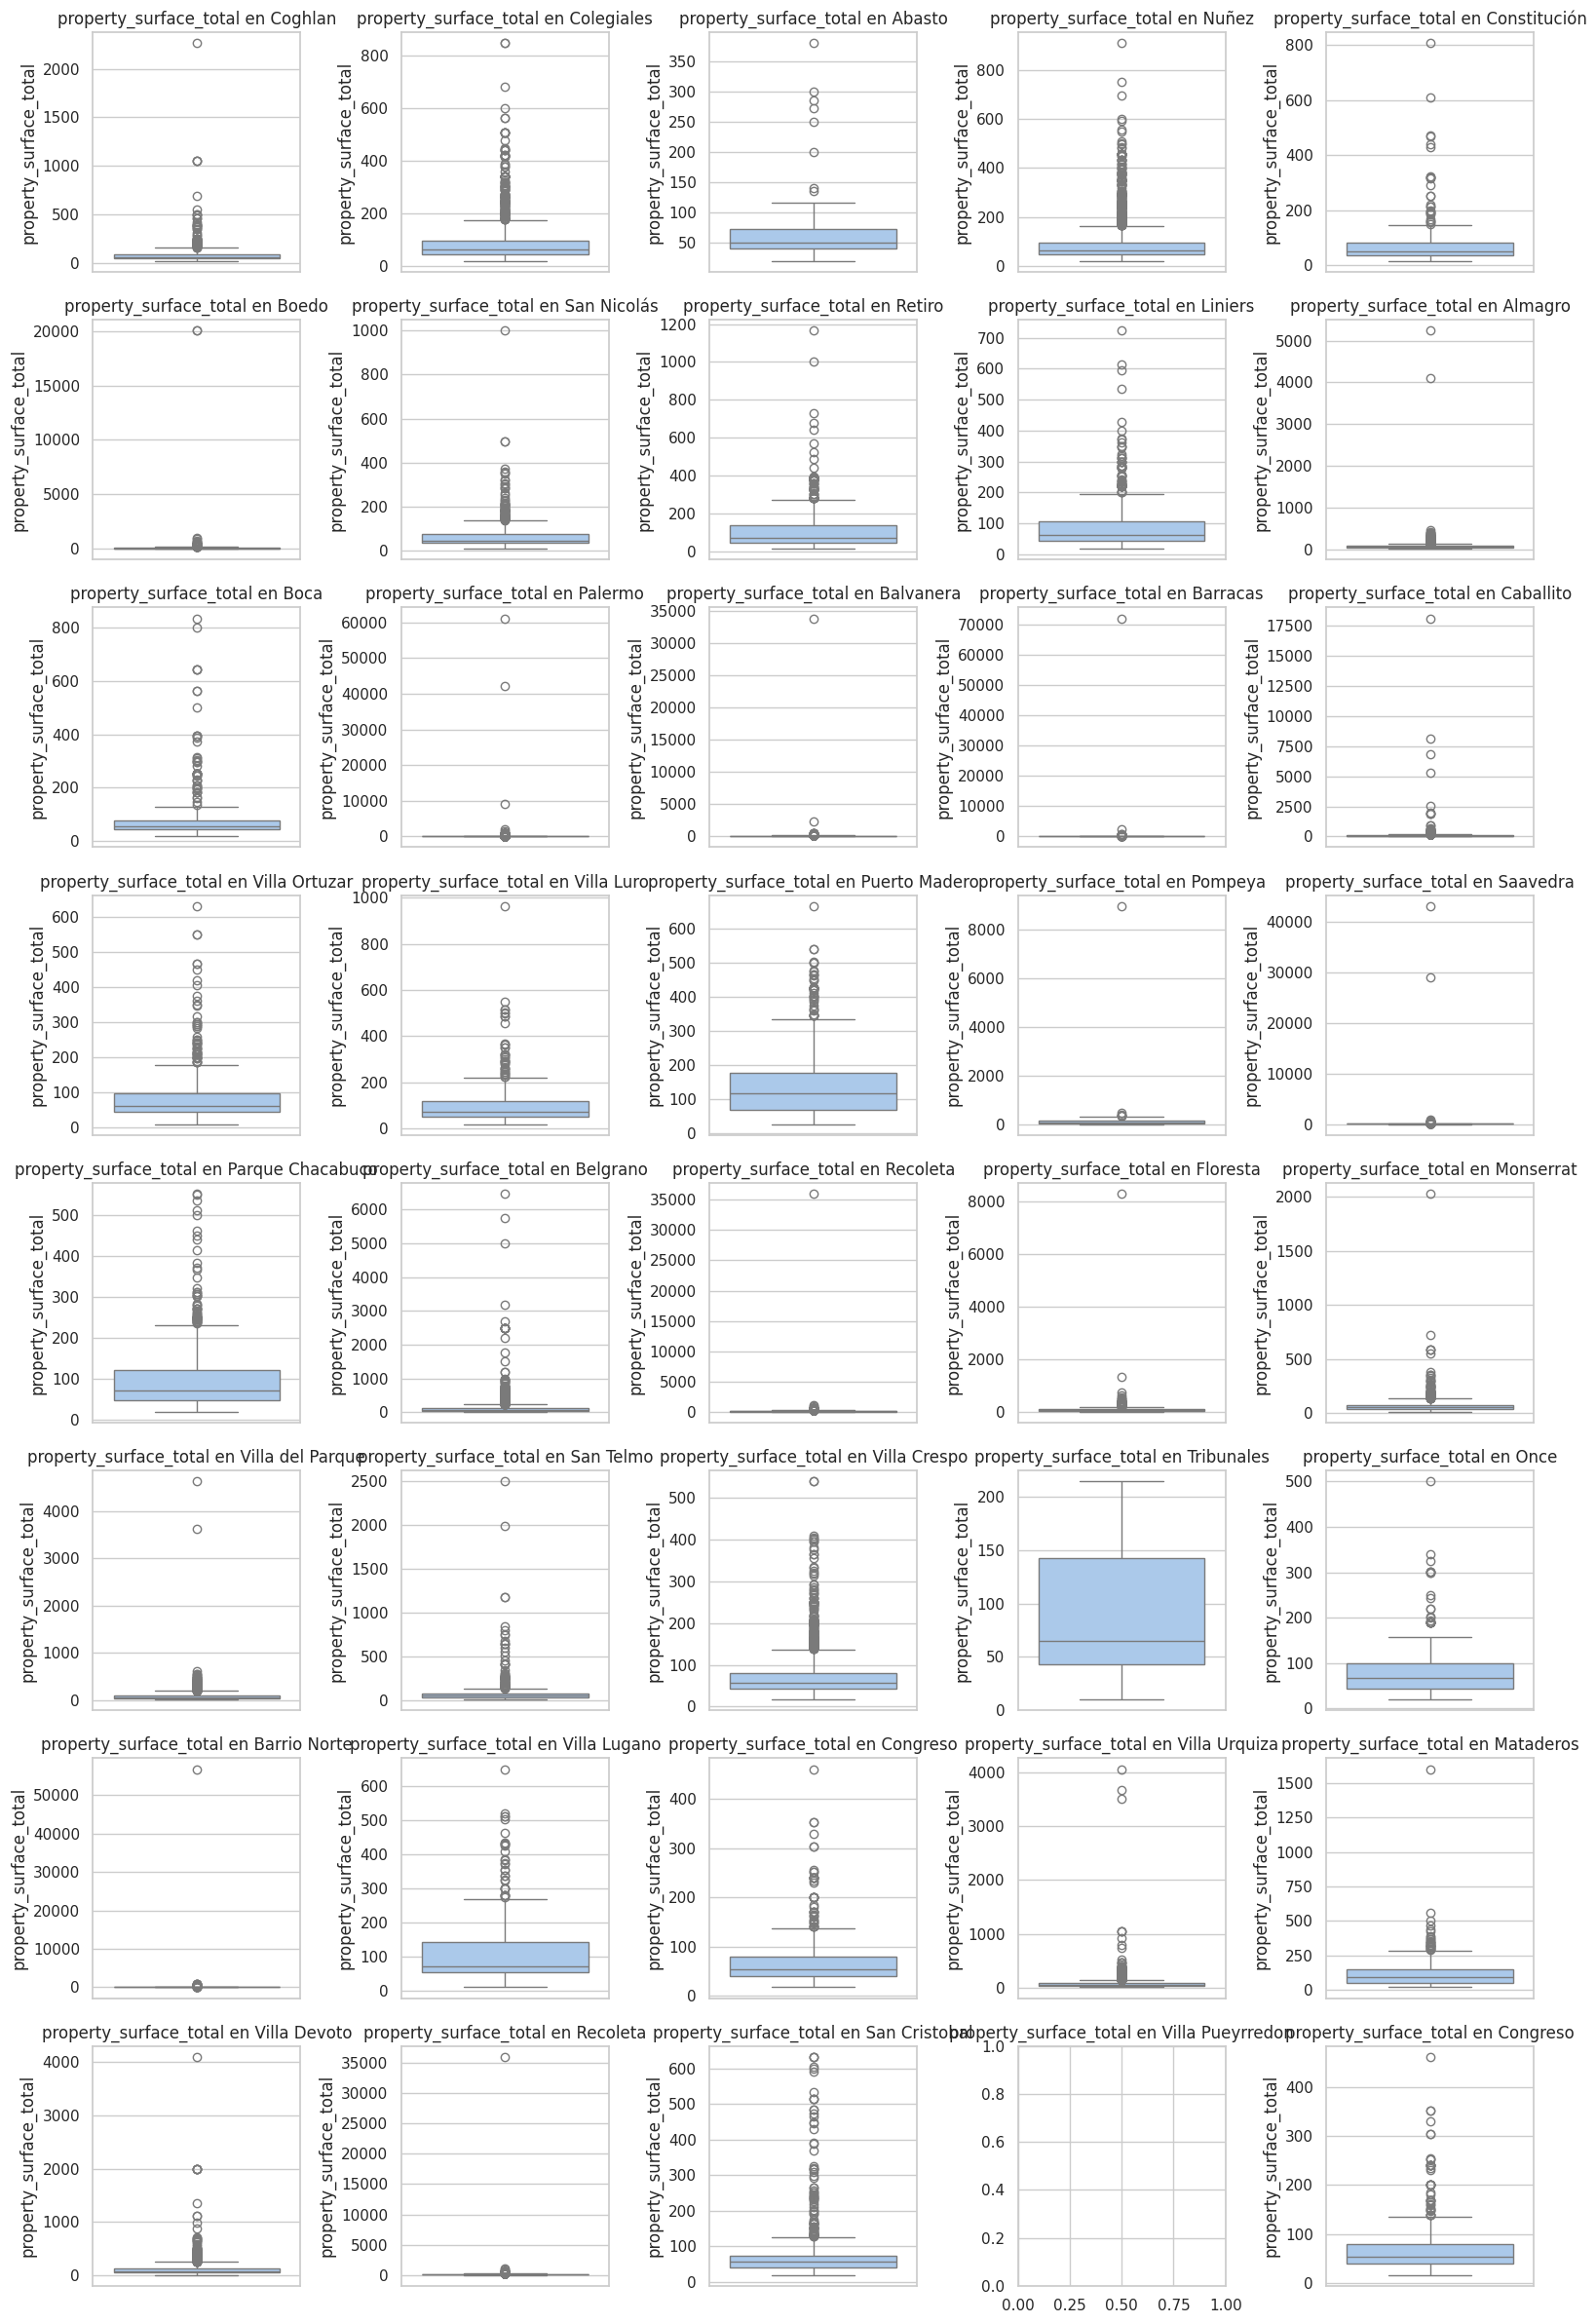

In [427]:
plot_por_barrio(ds_train, 'property_surface_total')

Podemos ver en las comparaciones de los barrios que incluso en aquellos que tienen más variaciones de tamaño de superficie total, los valores por encima de 3000 son outliers extremos, asi que normalizaremos esos valores.

In [428]:
# Corrección logaritmica
ds_train.loc[(ds_train['property_surface_total'] > 3000.0), 'property_surface_total'] = np.log(ds_train['property_surface_total'])

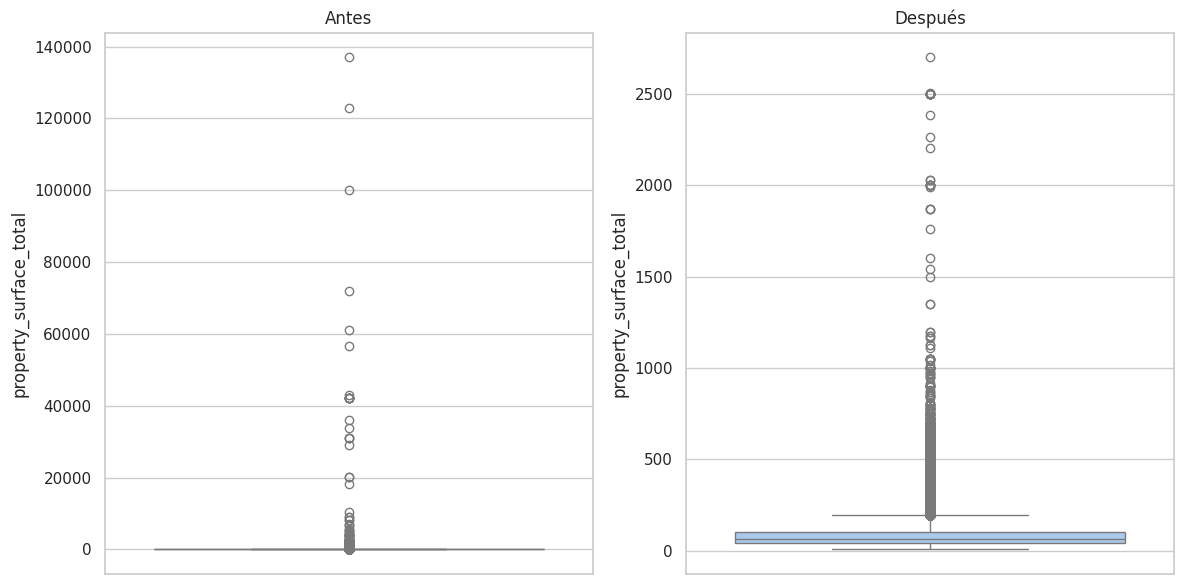

In [429]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_total')

**Z-Score, normal y modificado**

In [430]:
def plot_z(df, variable):
  plt.hist(df[variable])
  plt.title("Histograma Z-Score "+ variable)
  plt.xlabel("Z-Score "+variable)
  plt.tight_layout()
  plt.show()
  return

<ipython-input-431-1ce1084e760a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-431-1ce1084e760a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



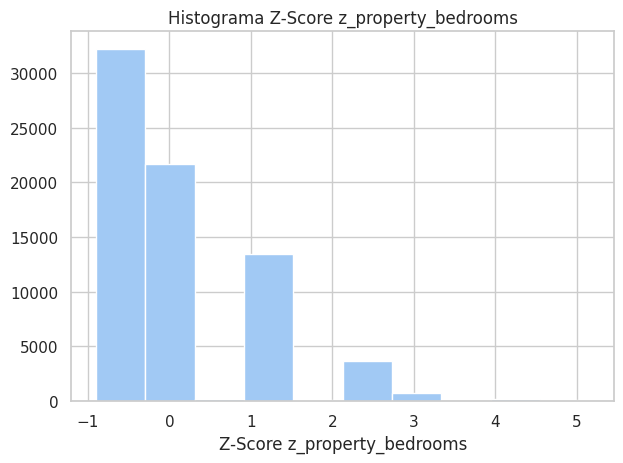

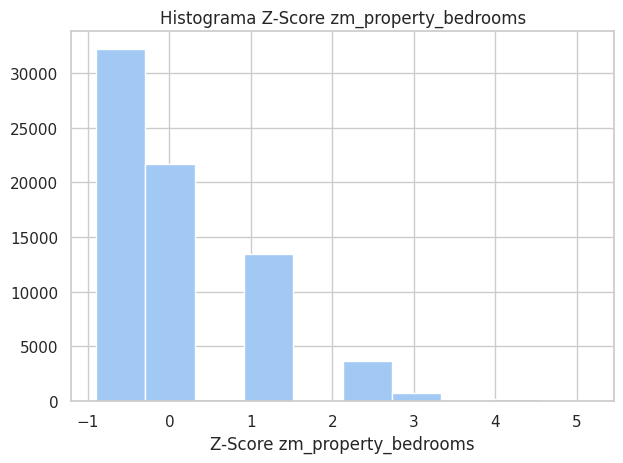

In [431]:
# Z Score property_bedrooms
ds_train['z_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)
ds_train['zm_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)

plot_z(ds_train, 'z_property_bedrooms')
plot_z(ds_train, 'zm_property_bedrooms')


In [432]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
173292  B4KF6i41skR/iRDonXESLA==  2021-05-11  2021-05-12 2021-05-11   
338774  +OlRqaMH9p1Z9IPpkiPABg==  2021-06-01  2021-06-19 2021-06-01   
318490  UwWoDgDmF+EEoIaqV2cMCA==  2021-03-17  2021-05-14 2021-03-17   
...                          ...         ...         ...        ...   
336451  FlzfC9jJJq01vtNEXDc7XQ==  2021-07-21  2022-02-09 2021-07-21   
400593  0Lbm+Vj9jfOZVnRvwFk+Tw==  2021-06-17  9999-12-31 2021-06-17   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   
171569  zKrvUbrB7p50rDDxMp2yrw==  2021-04-19  2021-06-05 2021-04-19   
131807  4r6l9NRJFMELyoka+FxGsQ==  2021-05-27  2021-06-18 2021-05-27   

          latitud   longitud       place_l3 property_type  property_rooms  \
239181 -34.572554 -58.469842       Belgrano          Casa         8.00000   
354636 -34.641514 -58.367007           Boca            PH        10.00000   
173292 -34.622091 -58.508864   Monte Castro          Casa         8.00000   
338774 -34.562157 -58.464230       Belgrano          Casa         7.00000   
318490 -34.604677 -58.463811       Paternal          Casa         7.37771   
...           ...        ...            ...           ...             ...   
336451 -34.601997 -58.383625    San Nicolás  Departamento         4.00000   
400593 -34.623815 -58.407262  San Cristobal            PH         7.00000   
303903 -34.593316 -58.377201         Retiro  Departamento         9.00000   
171569 -34.617993 -58.361880  Puerto Madero  Departamento         4.00000   
131807 -34.609881 -58.384535      Monserrat  Departamento         6.00000   

        property_bedrooms  property_surface_total  property_surface_covered  \
239181                7.0                   400.0                     400.0   
354636                7.0                   123.0                     118.0   
173292                6.0                   360.0                     282.0   
338774                7.0                   118.0                     118.0   
318490                6.0                   209.0                     140.0   
...                   ...                     ...                       ...   
336451                6.0                   284.0                     284.0   
400593                6.0                   445.0                     445.0   
303903                7.0                   380.0                     350.0   
171569                6.0                   253.0                     253.0   
131807                6.0                   141.0                     125.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
239181        920000.0             5.150925              5.150925  
354636        150000.0             5.150925              5.150925  
173292        395000.0             4.142691              4.142691  
338774        175000.0             5.150925              5.150925  
318490        299500.0             4.142691              4.142691  
...                ...                  ...                   ...  
336451        560000.0             4.142691              4.142691  
400593        353000.0             4.142691              4.142691  
303903        690000.0             5.150925              5.150925  
171569       1780000.0             4.142691              4.142691  
131807        160000.0             4.142691              4.142691  

[275 rows x 15 columns]

In [433]:
ds_train[(ds_train['zm_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
173292  B4KF6i41skR/iRDonXESLA==  2021-05-11  2021-05-12 2021-05-11   
338774  +OlRqaMH9p1Z9IPpkiPABg==  2021-06-01  2021-06-19 2021-06-01   
318490  UwWoDgDmF+EEoIaqV2cMCA==  2021-03-17  2021-05-14 2021-03-17   
...                          ...         ...         ...        ...   
336451  FlzfC9jJJq01vtNEXDc7XQ==  2021-07-21  2022-02-09 2021-07-21   
400593  0Lbm+Vj9jfOZVnRvwFk+Tw==  2021-06-17  9999-12-31 2021-06-17   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   
171569  zKrvUbrB7p50rDDxMp2yrw==  2021-04-19  2021-06-05 2021-04-19   
131807  4r6l9NRJFMELyoka+FxGsQ==  2021-05-27  2021-06-18 2021-05-27   

          latitud   longitud       place_l3 property_type  property_rooms  \
239181 -34.572554 -58.469842       Belgrano          Casa         8.00000   
354636 -34.641514 -58.367007           Boca            PH        10.00000   
173292 -34.622091 -58.508864   Monte Castro          Casa         8.00000   
338774 -34.562157 -58.464230       Belgrano          Casa         7.00000   
318490 -34.604677 -58.463811       Paternal          Casa         7.37771   
...           ...        ...            ...           ...             ...   
336451 -34.601997 -58.383625    San Nicolás  Departamento         4.00000   
400593 -34.623815 -58.407262  San Cristobal            PH         7.00000   
303903 -34.593316 -58.377201         Retiro  Departamento         9.00000   
171569 -34.617993 -58.361880  Puerto Madero  Departamento         4.00000   
131807 -34.609881 -58.384535      Monserrat  Departamento         6.00000   

        property_bedrooms  property_surface_total  property_surface_covered  \
239181                7.0                   400.0                     400.0   
354636                7.0                   123.0                     118.0   
173292                6.0                   360.0                     282.0   
338774                7.0                   118.0                     118.0   
318490                6.0                   209.0                     140.0   
...                   ...                     ...                       ...   
336451                6.0                   284.0                     284.0   
400593                6.0                   445.0                     445.0   
303903                7.0                   380.0                     350.0   
171569                6.0                   253.0                     253.0   
131807                6.0                   141.0                     125.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
239181        920000.0             5.150925              5.150925  
354636        150000.0             5.150925              5.150925  
173292        395000.0             4.142691              4.142691  
338774        175000.0             5.150925              5.150925  
318490        299500.0             4.142691              4.142691  
...                ...                  ...                   ...  
336451        560000.0             4.142691              4.142691  
400593        353000.0             4.142691              4.142691  
303903        690000.0             5.150925              5.150925  
171569       1780000.0             4.142691              4.142691  
131807        160000.0             4.142691              4.142691  

[275 rows x 15 columns]

In [434]:
ds_train[(ds_train['z_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

In [435]:
ds_train[(ds_train['zm_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

Siguiendo el Z score, podemos ver que no existen outliers negativos, incluso usando un valor mínimo de -1. Usando la regla de oro de 3.5, podemos ver que si lo existen positivos y en una cantidad bastante significativa (275 registros). Vamos a ampliar ligeramente este factor.

In [436]:
ds_train[(ds_train['z_property_bedrooms'] > 5)]

id  start_date    end_date created_on  \
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
338774  +OlRqaMH9p1Z9IPpkiPABg==  2021-06-01  2021-06-19 2021-06-01   
353761  T0kixYWXY/Anuassk+UQug==  2021-11-04  2022-01-27 2021-11-04   
342818  mqoxNDn8Gn/UkxbHPo7iOA==  2021-08-11  2021-09-01 2021-08-11   
...                          ...         ...         ...        ...   
439064  5jWVAodcZ9d6tVGrcMV3iA==  2021-04-23  2021-07-03 2021-04-23   
115164  LRNvV58vN16ANMg0WmEEgw==  2021-12-07  2022-01-27 2021-12-07   
72640   RBSIx9grSfooVB473NbCfA==  2021-05-29  2021-07-22 2021-05-29   
446881  FCKQIqoZzcZ7V9FAbGTc7g==  2021-05-22  2021-06-07 2021-05-22   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   

          latitud   longitud           place_l3 property_type  property_rooms  \
239181 -34.572554 -58.469842           Belgrano          Casa        8.000000   
354636 -34.641514 -58.367007               Boca            PH       10.000000   
338774 -34.562157 -58.464230           Belgrano          Casa        7.000000   
353761 -34.646550 -58.464703  Parque Avellaneda          Casa        2.397895   
342818 -34.616128 -58.394715          Balvanera          Casa        8.000000   
...           ...        ...                ...           ...             ...   
439064 -34.616128 -58.394715          Balvanera          Casa        8.000000   
115164 -34.639049 -58.423623          Caballito            PH       10.000000   
72640  -34.602843 -58.386216        San Nicolás  Departamento        8.000000   
446881 -34.629273 -58.418845              Boedo          Casa        2.484907   
303903 -34.593316 -58.377201             Retiro  Departamento        9.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
239181                7.0                   400.0                     400.0   
354636                7.0                   123.0                     118.0   
338774                7.0                   118.0                     118.0   
353761                7.0                   897.0                     605.0   
342818                7.0                   164.0                     143.0   
...                   ...                     ...                       ...   
439064                7.0                   164.0                     143.0   
115164                7.0                   525.0                     430.0   
72640                 7.0                   195.0                     190.0   
446881                7.0                   500.0                     500.0   
303903                7.0                   380.0                     350.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
239181        920000.0             5.150925              5.150925  
354636        150000.0             5.150925              5.150925  
338774        175000.0             5.150925              5.150925  
353761        990000.0             5.150925              5.150925  
342818        230000.0             5.150925              5.150925  
...                ...                  ...                   ...  
439064        230000.0             5.150925              5.150925  
115164        270000.0             5.150925              5.150925  
72640         198000.0             5.150925              5.150925  
446881        450000.0             5.150925              5.150925  
303903        690000.0             5.150925              5.150925  

[86 rows x 15 columns]

No podemos sacar ninguna conclusión de los registros, así que esperaremos al análisis multivariado para tomar decisiones al respecto de estos outliers.

### Análisis multivariado

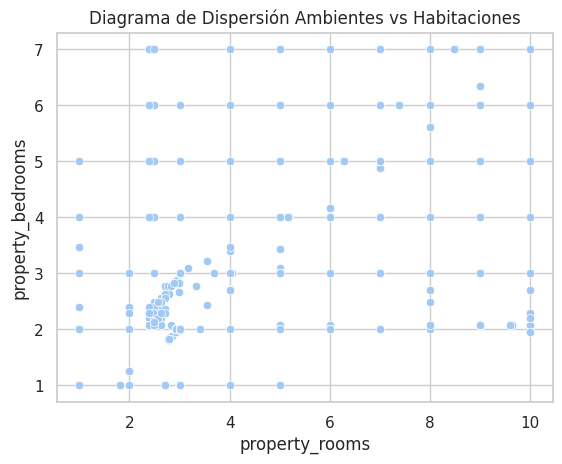

In [437]:
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones")
plt.show()

En el analisis univariado solucionamos los outliers imposibles.  

In [438]:
ds_train[(ds_train['property_rooms'] < ds_train['property_bedrooms'])]

id  start_date    end_date created_on  \
432011  s14IJlvWuE+oZmMurxiGpw==  2021-12-16  2022-02-09 2021-12-16   
23358   zL5KK2OBBmJmmTGavTpnNw==  2021-10-01  2021-12-24 2021-10-01   
256054  p9fZU+NpJf8X7OeTQU4qSg==  2021-11-03  2022-09-17 2021-11-03   
353761  T0kixYWXY/Anuassk+UQug==  2021-11-04  2022-01-27 2021-11-04   
34828   sch/BnXqfoyuYHqM+FgZRg==  2021-02-08  2021-03-18 2021-02-08   
...                          ...         ...         ...        ...   
171575  DTZbmjvIiJ4P/Wz5r3lm4g==  2021-04-19  2021-06-05 2021-04-19   
225101  BvEsXFS0YlkCOSqwO00UjQ==  2021-09-14  2022-02-09 2021-09-14   
115473  qVgRSdIhCyeGtOETFWUy4A==  2021-12-07  2022-01-27 2021-12-07   
336451  FlzfC9jJJq01vtNEXDc7XQ==  2021-07-21  2022-02-09 2021-07-21   
171569  zKrvUbrB7p50rDDxMp2yrw==  2021-04-19  2021-06-05 2021-04-19   

          latitud   longitud           place_l3 property_type  property_rooms  \
432011 -34.643086 -58.435170   Parque Chacabuco            PH        3.000000   
23358  -34.595985 -58.401429       Barrio Norte  Departamento        1.000000   
256054 -34.609558 -58.419209            Almagro  Departamento        2.397895   
353761 -34.646550 -58.464703  Parque Avellaneda          Casa        2.397895   
34828  -34.580328 -58.451753         Colegiales            PH        2.397895   
...           ...        ...                ...           ...             ...   
171575 -34.621530 -58.361752      Puerto Madero  Departamento        3.000000   
225101 -34.624302 -58.396088       Constitución            PH        2.000000   
115473 -34.613037 -58.360984      Puerto Madero  Departamento        3.000000   
336451 -34.601997 -58.383625        San Nicolás  Departamento        4.000000   
171569 -34.617993 -58.361880      Puerto Madero  Departamento        4.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
432011                4.0                   106.0                     106.0   
23358                 2.0                    58.0                      58.0   
256054                5.0                   239.0                     239.0   
353761                7.0                   897.0                     605.0   
34828                 4.0                   269.0                     269.0   
...                   ...                     ...                       ...   
171575                4.0                   122.0                     116.0   
225101                3.0                    53.0                      53.0   
115473                4.0                   170.0                     166.0   
336451                6.0                   284.0                     284.0   
171569                6.0                   253.0                     253.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
432011         89800.0             2.126223              2.126223  
23358         149000.0             0.109755              0.109755  
256054        425000.0             3.134457              3.134457  
353761        990000.0             5.150925              5.150925  
34828         499400.0             2.126223              2.126223  
...                ...                  ...                   ...  
171575        590000.0             2.126223              2.126223  
225101         83000.0             1.117989              1.117989  
115473        900000.0             2.126223              2.126223  
336451        560000.0             4.142691              4.142691  
171569       1780000.0             4.142691              4.142691  

[133 rows x 15 columns]

Tenemos 130 registros en los que el número de habitaciones es mayor que el de ambientes.

In [439]:
# Caso: más habitaciones que ambientes
condition= (ds_train['property_rooms'] < ds_train['property_bedrooms'])
ds_train[condition]

id  start_date    end_date created_on  \
432011  s14IJlvWuE+oZmMurxiGpw==  2021-12-16  2022-02-09 2021-12-16   
23358   zL5KK2OBBmJmmTGavTpnNw==  2021-10-01  2021-12-24 2021-10-01   
256054  p9fZU+NpJf8X7OeTQU4qSg==  2021-11-03  2022-09-17 2021-11-03   
353761  T0kixYWXY/Anuassk+UQug==  2021-11-04  2022-01-27 2021-11-04   
34828   sch/BnXqfoyuYHqM+FgZRg==  2021-02-08  2021-03-18 2021-02-08   
...                          ...         ...         ...        ...   
171575  DTZbmjvIiJ4P/Wz5r3lm4g==  2021-04-19  2021-06-05 2021-04-19   
225101  BvEsXFS0YlkCOSqwO00UjQ==  2021-09-14  2022-02-09 2021-09-14   
115473  qVgRSdIhCyeGtOETFWUy4A==  2021-12-07  2022-01-27 2021-12-07   
336451  FlzfC9jJJq01vtNEXDc7XQ==  2021-07-21  2022-02-09 2021-07-21   
171569  zKrvUbrB7p50rDDxMp2yrw==  2021-04-19  2021-06-05 2021-04-19   

          latitud   longitud           place_l3 property_type  property_rooms  \
432011 -34.643086 -58.435170   Parque Chacabuco            PH        3.000000   
23358  -34.595985 -58.401429       Barrio Norte  Departamento        1.000000   
256054 -34.609558 -58.419209            Almagro  Departamento        2.397895   
353761 -34.646550 -58.464703  Parque Avellaneda          Casa        2.397895   
34828  -34.580328 -58.451753         Colegiales            PH        2.397895   
...           ...        ...                ...           ...             ...   
171575 -34.621530 -58.361752      Puerto Madero  Departamento        3.000000   
225101 -34.624302 -58.396088       Constitución            PH        2.000000   
115473 -34.613037 -58.360984      Puerto Madero  Departamento        3.000000   
336451 -34.601997 -58.383625        San Nicolás  Departamento        4.000000   
171569 -34.617993 -58.361880      Puerto Madero  Departamento        4.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
432011                4.0                   106.0                     106.0   
23358                 2.0                    58.0                      58.0   
256054                5.0                   239.0                     239.0   
353761                7.0                   897.0                     605.0   
34828                 4.0                   269.0                     269.0   
...                   ...                     ...                       ...   
171575                4.0                   122.0                     116.0   
225101                3.0                    53.0                      53.0   
115473                4.0                   170.0                     166.0   
336451                6.0                   284.0                     284.0   
171569                6.0                   253.0                     253.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
432011         89800.0             2.126223              2.126223  
23358         149000.0             0.109755              0.109755  
256054        425000.0             3.134457              3.134457  
353761        990000.0             5.150925              5.150925  
34828         499400.0             2.126223              2.126223  
...                ...                  ...                   ...  
171575        590000.0             2.126223              2.126223  
225101         83000.0             1.117989              1.117989  
115473        900000.0             2.126223              2.126223  
336451        560000.0             4.142691              4.142691  
171569       1780000.0             4.142691              4.142691  

[133 rows x 15 columns]

Varios de estos registros tienen valores irracionales para una habitación (2.397... en vez de números enteros) y podrían haber sido resultados de imputaciones y transformaciones anteriores.
Una solución podría ser copiar los valores de habitaciones a ambientes, pero previniendo que algunos puedan ser valores verdaderos y para que no se pierdan, probaremos invirtiendo las columnas de estos casos en específico ya que muchos tienen sentido de esa manera (casas con 6 ambientes y 4 habitaciones, departamentos de 2 ambientes y una habitación, por dar unos ejemplos). Es un cambio riesgoso pero se tendrá en cuenta por si llegara a haber discrepancias en resultados futuros.

In [440]:
# Creamos una máscara booleana para nuestra condición
mask = ds_train['property_rooms'] < ds_train['property_bedrooms']

# Invertimos los valores usando la máscara
ds_train.loc[mask, ['property_rooms', 'property_bedrooms']] = ds_train.loc[mask, ['property_bedrooms', 'property_rooms']].values


In [441]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
239181  rFNKIoID3USomIB5PDqfKw==  2021-05-21  2021-06-05 2021-05-21   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
173292  B4KF6i41skR/iRDonXESLA==  2021-05-11  2021-05-12 2021-05-11   
338774  +OlRqaMH9p1Z9IPpkiPABg==  2021-06-01  2021-06-19 2021-06-01   
318490  UwWoDgDmF+EEoIaqV2cMCA==  2021-03-17  2021-05-14 2021-03-17   
...                          ...         ...         ...        ...   
336451  FlzfC9jJJq01vtNEXDc7XQ==  2021-07-21  2022-02-09 2021-07-21   
400593  0Lbm+Vj9jfOZVnRvwFk+Tw==  2021-06-17  9999-12-31 2021-06-17   
303903  FzaCrwAN9oMUXFSzKYOQtw==  2021-04-15  2021-06-05 2021-04-15   
171569  zKrvUbrB7p50rDDxMp2yrw==  2021-04-19  2021-06-05 2021-04-19   
131807  4r6l9NRJFMELyoka+FxGsQ==  2021-05-27  2021-06-18 2021-05-27   

          latitud   longitud       place_l3 property_type  property_rooms  \
239181 -34.572554 -58.469842       Belgrano          Casa         8.00000   
354636 -34.641514 -58.367007           Boca            PH        10.00000   
173292 -34.622091 -58.508864   Monte Castro          Casa         8.00000   
338774 -34.562157 -58.464230       Belgrano          Casa         7.00000   
318490 -34.604677 -58.463811       Paternal          Casa         7.37771   
...           ...        ...            ...           ...             ...   
336451 -34.601997 -58.383625    San Nicolás  Departamento         6.00000   
400593 -34.623815 -58.407262  San Cristobal            PH         7.00000   
303903 -34.593316 -58.377201         Retiro  Departamento         9.00000   
171569 -34.617993 -58.361880  Puerto Madero  Departamento         6.00000   
131807 -34.609881 -58.384535      Monserrat  Departamento         6.00000   

        property_bedrooms  property_surface_total  property_surface_covered  \
239181                7.0                   400.0                     400.0   
354636                7.0                   123.0                     118.0   
173292                6.0                   360.0                     282.0   
338774                7.0                   118.0                     118.0   
318490                6.0                   209.0                     140.0   
...                   ...                     ...                       ...   
336451                4.0                   284.0                     284.0   
400593                6.0                   445.0                     445.0   
303903                7.0                   380.0                     350.0   
171569                4.0                   253.0                     253.0   
131807                6.0                   141.0                     125.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
239181        920000.0             5.150925              5.150925  
354636        150000.0             5.150925              5.150925  
173292        395000.0             4.142691              4.142691  
338774        175000.0             5.150925              5.150925  
318490        299500.0             4.142691              4.142691  
...                ...                  ...                   ...  
336451        560000.0             4.142691              4.142691  
400593        353000.0             4.142691              4.142691  
303903        690000.0             5.150925              5.150925  
171569       1780000.0             4.142691              4.142691  
131807        160000.0             4.142691              4.142691  

[275 rows x 15 columns]

267 registros permanecen como outliers.

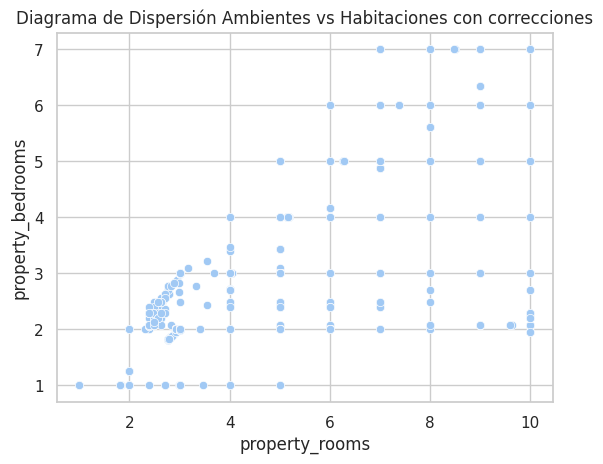

In [442]:
# Visualización después de correcciones
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones con correcciones")
plt.show()


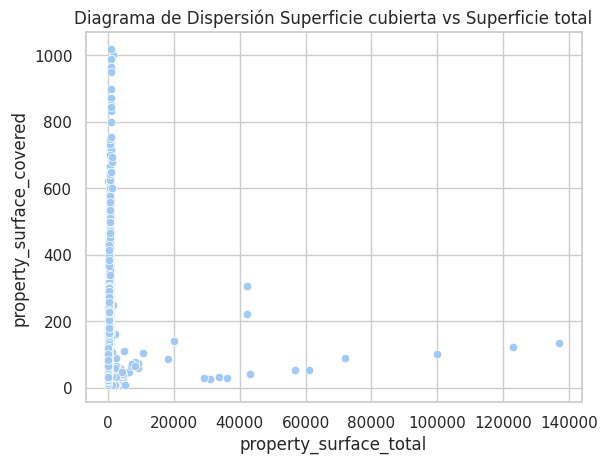

In [443]:
sns.scatterplot(y=ds_train["property_surface_covered"], x=df["property_surface_total"])
plt.title("Diagrama de Dispersión Superficie cubierta vs Superficie total")
plt.show()

En primer lugar, vamos a distinguir los casos triviales donde la superficie cubierta es mayor a la superficie total.

In [444]:
# Casos donde la superficie cubierta es mayor a la total
ds_train[(ds_train['property_surface_total'] < ds_train['property_surface_covered'])]

id  start_date    end_date created_on  \
43870   D4qgaLS6Wt83Etd36gb2Kw==  2021-11-23  2022-01-27 2021-11-23   
363704  BahrCD/XEQdKS8eiqexZrA==  2021-01-16  2021-06-05 2021-01-16   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
303198  0hpwCXcMVgeEJhZW4DvFag==  2021-08-26  2021-10-16 2021-08-26   
404968  YJNgqYQEyxG02iVSBP/lGA==  2021-08-13  9999-12-31 2021-08-13   
...                          ...         ...         ...        ...   
394318  RVAt2OvHQzZyz1J2TkZBOw==  2021-02-13  2021-06-24 2021-02-13   
111421  S95QnRJChUMqZAzO+yiqlw==  2021-10-19  9999-12-31 2021-10-19   
114948  8bYxGAYXGHGum6jpHIenuQ==  2021-12-07  2022-01-27 2021-12-07   
164318  GYgdHynWDFxtuA1WQTarTw==  2021-06-07  2021-08-03 2021-06-07   
352552  sJBfZM1Juv7/PZJ/Y/5J+A==  2021-06-25  2021-11-04 2021-06-25   

          latitud   longitud          place_l3 property_type  property_rooms  \
43870  -34.616667 -58.416936           Almagro  Departamento             7.0   
363704 -34.630233 -58.402472  Parque Patricios            PH             4.0   
72521  -34.600113 -58.403649         Balvanera  Departamento             2.0   
303198 -34.603625 -58.387768       San Nicolás  Departamento             2.0   
404968 -34.592975 -58.403200      Barrio Norte  Departamento             2.0   
...           ...        ...               ...           ...             ...   
394318 -34.651600 -58.527395           Liniers          Casa             4.0   
111421 -34.596390 -58.407688      Barrio Norte  Departamento             4.0   
114948 -34.565605 -58.470017          Belgrano  Departamento             2.0   
164318 -34.613556 -58.367984         San Telmo  Departamento             3.0   
352552 -34.581930 -58.427033           Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
43870                 4.0              140.000000                158.966004   
363704                3.0               78.000000                 87.332634   
72521                 1.0               10.428216                 31.670000   
303198                1.0               41.000000                 41.255362   
404968                1.0               32.000000                 37.061726   
...                   ...                     ...                       ...   
394318                3.0              205.000000                221.000000   
111421                3.0               92.000000                 93.856069   
114948                1.0               40.000000                 40.789403   
164318                1.0               53.000000                 61.009623   
352552                1.0               35.000000                 38.459604   

        property_price  z_property_bedrooms  zm_property_bedrooms  
43870         340000.0             2.126223              2.126223  
363704        138000.0             1.117989              1.117989  
72521          66000.0            -0.898478             -0.898478  
303198         70000.0            -0.898478             -0.898478  
404968         80000.0            -0.898478             -0.898478  
...                ...                  ...                   ...  
394318        575000.0             1.117989              1.117989  
111421        185000.0             1.117989              1.117989  
114948         85000.0            -0.898478             -0.898478  
164318        100000.0            -0.898478             -0.898478  
352552        130000.0            -0.898478             -0.898478  

[712 rows x 15 columns]

**Isolation forest**

In [445]:
# Cargo los datos
X =ds_train.copy()
X.head()

id  start_date    end_date created_on  \
45748   MAewqGlr+bEVCoz1BmrrVA==  2021-05-02  2021-06-05 2021-05-02   
173359  D7yJnGrID2bxDTkuca6LYA==  2021-05-11  2022-02-09 2021-05-11   
255728  9YqLDx1M2/a+dn6jUriUmA==  2021-11-03  2022-09-17 2021-11-03   
328392  +I/B18XvSK8LXIJrA8qlaQ==  2021-12-14  2022-01-27 2021-12-14   
397628  w8Ade7GPHXOZwfOFRgnIag==  2021-02-13  2021-03-01 2021-02-13   

          latitud   longitud          place_l3 property_type  property_rooms  \
45748  -34.603915 -58.416817           Almagro  Departamento             4.0   
173359 -34.636153 -58.425937  Parque Chacabuco          Casa             6.0   
255728 -34.629834 -58.463767            Flores  Departamento             3.0   
328392 -34.599342 -58.488135  Villa del Parque  Departamento             3.0   
397628 -34.590965 -58.425679           Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
45748                 3.0              110.768805                      72.0   
173359                4.0              262.000000                     175.0   
255728                2.0              106.000000                      69.0   
328392                2.0               78.000000                      59.0   
397628                1.0               59.000000                      52.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
45748         165000.0             1.117989              1.117989  
173359        360000.0             2.126223              2.126223  
255728        240000.0             0.109755              0.109755  
328392        146000.0             0.109755              0.109755  
397628        195000.0            -0.898478             -0.898478

In [446]:
# Limpio el dataset
X.drop(columns=['latitud', 'longitud', 'created_on', 'end_date', 'start_date', 'z_property_bedrooms', 'zm_property_bedrooms'], inplace=True)
X.head()

id          place_l3 property_type  \
45748   MAewqGlr+bEVCoz1BmrrVA==           Almagro  Departamento   
173359  D7yJnGrID2bxDTkuca6LYA==  Parque Chacabuco          Casa   
255728  9YqLDx1M2/a+dn6jUriUmA==            Flores  Departamento   
328392  +I/B18XvSK8LXIJrA8qlaQ==  Villa del Parque  Departamento   
397628  w8Ade7GPHXOZwfOFRgnIag==           Palermo  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
45748              4.0                3.0              110.768805   
173359             6.0                4.0              262.000000   
255728             3.0                2.0              106.000000   
328392             3.0                2.0               78.000000   
397628             2.0                1.0               59.000000   

        property_surface_covered  property_price  
45748                       72.0        165000.0  
173359                     175.0        360000.0  
255728                      69.0        240000.0  
328392                      59.0        146000.0  
397628                      52.0        195000.0

In [447]:
# Label encoding de los nombres de las ciudades y el tipo de propiedad

label_encoder = LabelEncoder()
X['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
ds_train['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
X['type_encoded'] = label_encoder.fit_transform(X['property_type'])
ds_train['type_encoded'] = label_encoder.fit_transform(X['place_l3'])

X

<ipython-input-447-64ff5b082a66>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-447-64ff5b082a66>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id          place_l3 property_type  \
45748   MAewqGlr+bEVCoz1BmrrVA==           Almagro  Departamento   
173359  D7yJnGrID2bxDTkuca6LYA==  Parque Chacabuco          Casa   
255728  9YqLDx1M2/a+dn6jUriUmA==            Flores  Departamento   
328392  +I/B18XvSK8LXIJrA8qlaQ==  Villa del Parque  Departamento   
397628  w8Ade7GPHXOZwfOFRgnIag==           Palermo  Departamento   
...                          ...               ...           ...   
327713  aGni+DURgb1BMP3MVxyCXA==          Floresta  Departamento   
352552  sJBfZM1Juv7/PZJ/Y/5J+A==           Palermo  Departamento   
118831  UN3IlNudTn8lBVtbq7N5rg==          Belgrano  Departamento   
209159  oyQAdxMCe/mz2nXAkrL/eg==           Palermo  Departamento   
220936  pRr6SZRztSyLqUrMBUeyZQ==           Palermo  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
45748              4.0           3.000000              110.768805   
173359             6.0           4.000000              262.000000   
255728             3.0           2.000000              106.000000   
328392             3.0           2.000000               78.000000   
397628             2.0           1.000000               59.000000   
...                ...                ...                     ...   
327713             2.0           1.000000               68.000000   
352552             2.0           1.000000               35.000000   
118831             3.0           1.987109               66.000000   
209159             1.0           1.000000               42.000000   
220936             3.0           2.000000               69.000000   

        property_surface_covered  property_price  place_encoded  type_encoded  
45748                  72.000000        165000.0              2             1  
173359                175.000000        360000.0             30             0  
255728                 69.000000        240000.0             18             1  
328392                 59.000000        146000.0             58             1  
397628                 52.000000        195000.0             27             1  
...                          ...             ...            ...           ...  
327713                 39.000000         63000.0             19             1  
352552                 38.459604        130000.0             27             1  
118831                 60.000000        179000.0              7             1  
209159                 42.000000         99500.0             27             1  
220936                 60.000000        130000.0             27             1  

[72277 rows x 10 columns]

In [448]:
X.drop(columns=['place_l3', 'property_type', 'id'], inplace=True)

In [449]:
# Creo el modelo
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=5,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

# Entreno y genero la predicción
pred = iforest.fit_predict(X)

# Almaceno scores y etiquetas
X["scores"] = iforest.decision_function(X)
X["outlier_label"] = pred

# Observaciones anómalas
X[X.outlier_label == -1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



property_rooms  property_bedrooms  property_surface_total  \
173359             6.0                4.0              262.000000   
412896             6.0                4.0              214.000000   
7664               9.0                4.0              668.000000   
256749             5.0                3.0              600.000000   
158363             6.0                4.0              306.911654   
...                ...                ...                     ...   
342091             4.0                2.0              220.000000   
24739              5.0                4.0              305.000000   
141496             6.0                5.0              597.000000   
362458             7.0                4.0              285.095426   
153306             5.0                4.0              289.000000   

        property_surface_covered  property_price  place_encoded  type_encoded  \
173359                     175.0        360000.0             30             0   
412896                     147.0        270000.0             57             2   
7664                       668.0       5000000.0             36             1   
256749                     600.0       1800000.0              7             0   
158363                     247.0        675000.0             25             0   
...                          ...             ...            ...           ...   
342091                     220.0       1680000.0             35             1   
24739                      135.0        580000.0             58             1   
141496                     287.0        700000.0             52             0   
362458                     223.0        590000.0             36             1   
153306                     289.0        800000.0              7             1   

          scores  outlier_label  
173359 -0.007660             -1  
412896 -0.019204             -1  
7664   -0.170987             -1  
256749 -0.157253             -1  
158363 -0.030289             -1  
...          ...            ...  
342091 -0.017111             -1  
24739  -0.007321             -1  
141496 -0.120242             -1  
362458 -0.001578             -1  
153306 -0.025842             -1  

[3614 rows x 9 columns]

In [450]:
# Cantidad de obs. anómalas
X.outlier_label.value_counts()

outlier_label
 1    68663
-1     3614
Name: count, dtype: int64

Obtuvimos 3611 anomalías. Visualizamos.

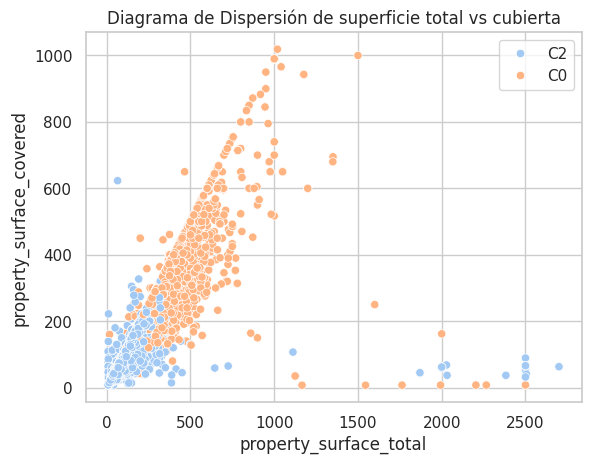

In [451]:
# Grafico dispersograma
color = [f"C{n+1}" for n in (X["outlier_label"].values)]

sns.scatterplot(x=X["property_surface_total"], y=X["property_surface_covered"], hue=color)
plt.title("Diagrama de Dispersión de superficie total vs cubierta")
plt.show()

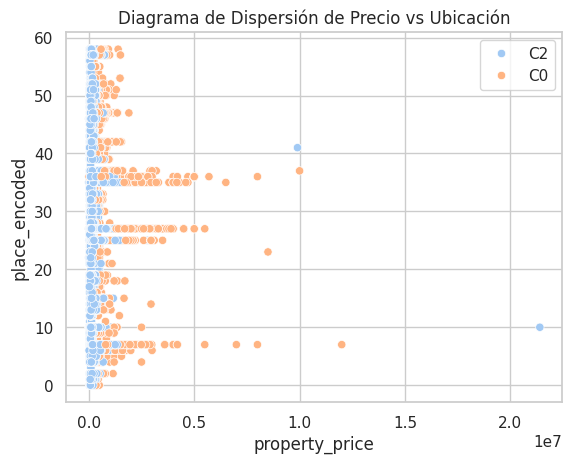

In [452]:
sns.scatterplot(x=X["property_price"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Precio vs Ubicación")
plt.show()

In [453]:
# # Selecciono el árbol
# estimator = iforest.estimators_[5]

# # Grafico
# plt.figure(figsize=(25, 25))
# sk.tree.plot_tree(estimator, feature_names=X.columns, filled=True, max_depth=3)
# plt.show()

PENDIENTE no se que hacer con estos resultados :))))

**LOF**

Vamos a intentar detectar outliers multivariados usando LOF.

In [454]:
def lof(df, var1, var2, name):
  radius = calculo_lof(df, var1, var2, name)
  grafico_lof(df, var1, var2, name, radius)
  return


def calculo_lof(df, var1, var2, name):
  # CÁLCULO
  # Conjunto de entrenamiento
  X = df[[var1, var2]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=20)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df[name] = clf.negative_outlier_factor_

  #VISUALIZACION
  # Calculo radio para plotear score
  radius = (df[name].max() - df[name]) / (df[name].max() - df[name].min())
  return radius


def grafico_lof(df, var1, var2, name, radius):
  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)" + name)
  plt.scatter(
      df[var1].values,
      df[var2].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df[var1].values,
      df[var2].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return

In [455]:
def lof_per_barrio(df, var1, var2, name):
  # Lista de barrios
  barrios = ['Coghlan','Colegiales','Abasto','Nuñez','Constitución',
              'Boedo', 'San Nicolás', 'Retiro', 'Liniers', 'Almagro',
              'Boca', 'Palermo', 'Balvanera','Barracas', 'Caballito',
              'Villa Ortuzar', 'Villa Luro', 'Puerto Madero', 'Pompeya', 'Saavedra',
              'Parque Chacabuco', 'Belgrano', 'Recoleta', 'Floresta', 'Monserrat',
              'Villa del Parque', 'San Telmo', 'Villa Crespo', 'Tribunales', 'Once',
              'Barrio Norte', 'Villa Lugano', 'Congreso', 'Villa Urquiza', 'Mataderos',
              'Villa Devoto', 'Recoleta', 'San Cristobal', 'Villa Pueyrredon', 'Congreso']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, barrio in enumerate(barrios):
      filtered_data = ds_train[ds_train['place_l3'] == barrio]

      # CÁLCULO
      # Conjunto de entrenamiento
      X = filtered_data[var1,var2].values
      # Creo el clasificador
      clf = LocalOutlierFactor(n_neighbors=20)
      # Genero prediccion
      y_pred = clf.fit_predict(X)
      # Guardo los scores
      filtered_data[name] = clf.negative_outlier_factor_

      #VISUALIZACION
      # Calculo radio para plotear score
      radius = (filtered_data[name].max() - filtered_data[name]) / (filtered_data[name].max() - filtered_data[name].min())

      # Grafico LOF
      plt.figure(figsize=(10, 10))
      plt.scatter(
          filtered_data[var1].values,
          filtered_data[var2].values,
          edgecolor="grey",
          s=30,
          label="datos",
          facecolors="none",
      )
      plt.scatter(
          filtered_data[var1].values,
          filtered_data[var2].values,
          s=1300 * radius,
          edgecolors="red",
          facecolors="none",
          label="Outlier scores",
      )
      legend = plt.legend(loc="upper left")
      legend.legendHandles[0]._sizes = [10]
      legend.legendHandles[1]._sizes = [20]


      axs[i].set_title(f'{var1}, {var2} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return

#### Superficie cubierta vs superficie total

<ipython-input-454-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-454-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-454-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



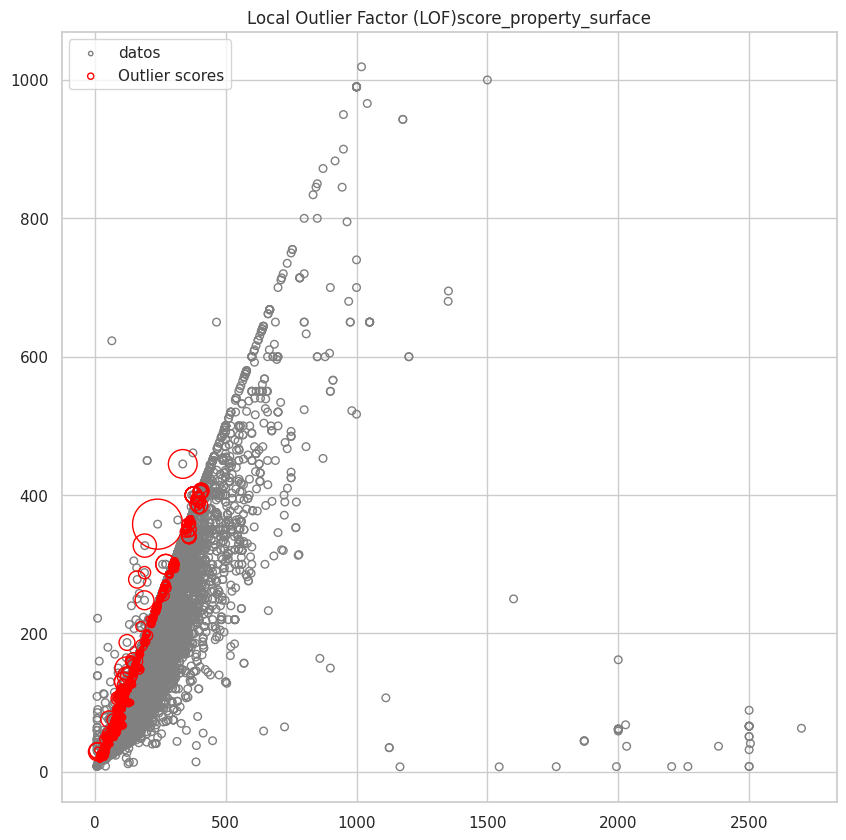

In [456]:
lof(ds_train, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

Precio vs Superficie total

<ipython-input-454-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-454-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-454-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



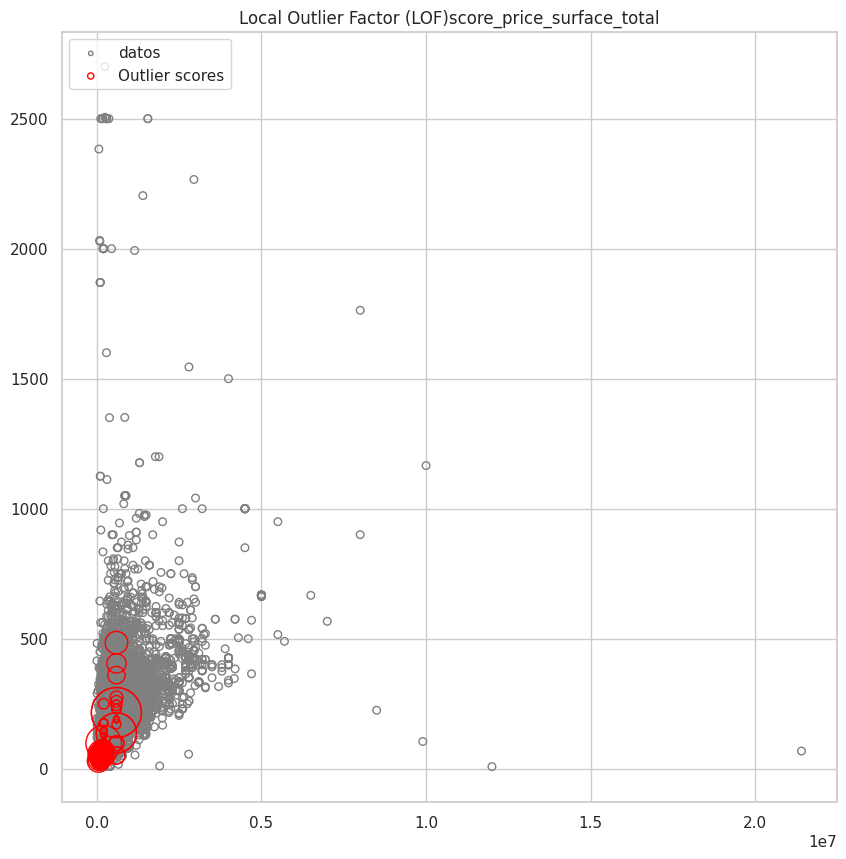

In [457]:
lof(ds_train, 'property_price', 'property_surface_total', 'score_price_surface_total')

<ipython-input-454-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-454-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-454-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



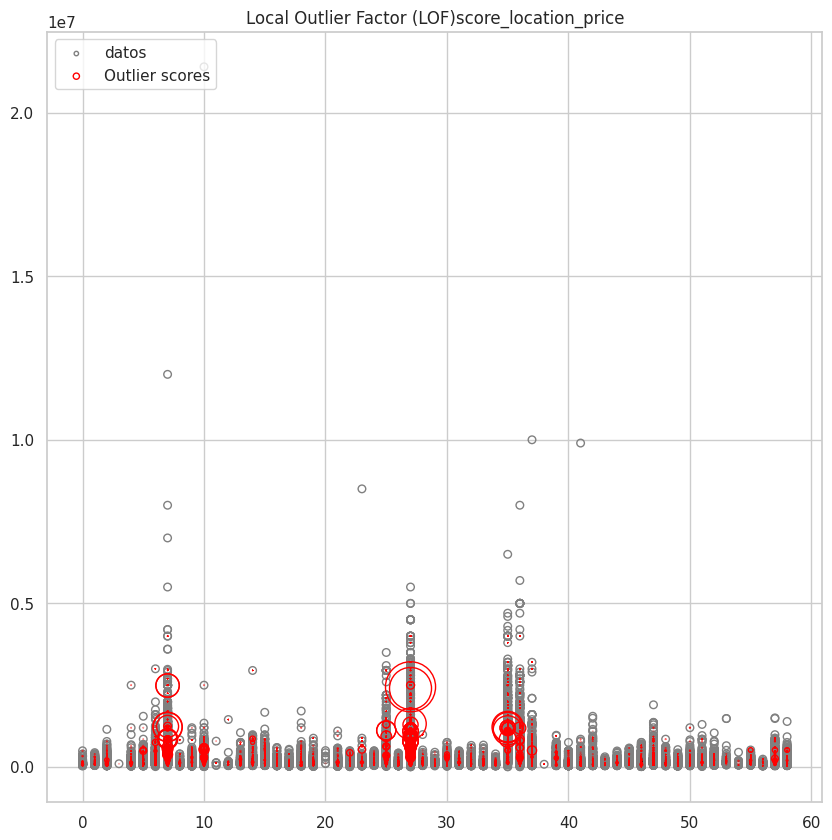

In [458]:
lof(ds_train, 'place_encoded', 'property_price', 'score_location_price')

<ipython-input-454-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-454-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-454-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



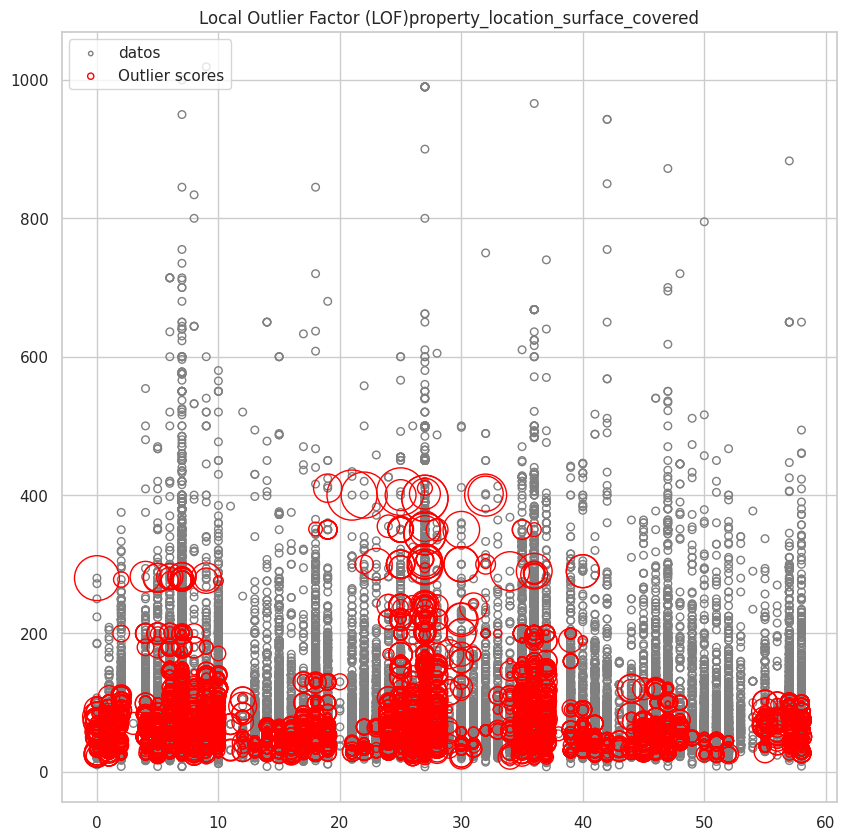

In [459]:
lof(ds_train, 'place_encoded', 'property_surface_covered', 'property_location_surface_covered')

### Relación precio de venta-metros de superficie



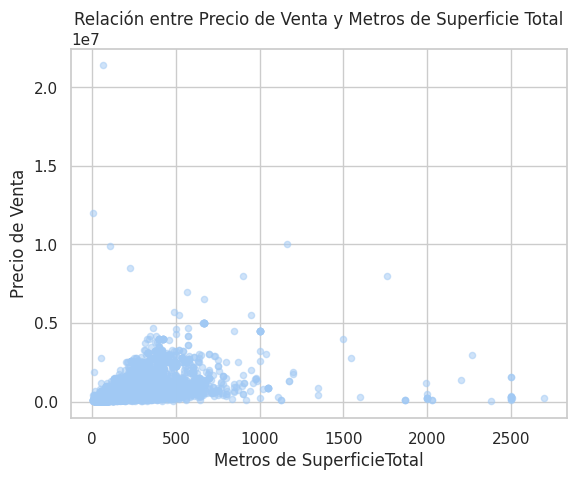

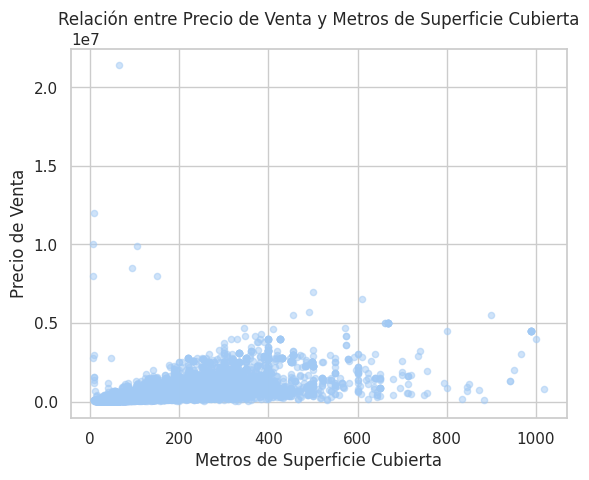

In [460]:
ds_train.plot.scatter(x='property_surface_total', y='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()


ds_train.plot.scatter(x='property_surface_covered', y='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Cubierta')
plt.xlabel('Metros de Superficie Cubierta')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()

Podemos ver algunos datos atípicos donde a pesar de muchos precios de superficie, el precio es demasiado bajo, y su opuesto, precio muy alto para supercie muy limitada.

PENDIENTE